In [1]:
import multi_locus_analysis.finite_window as fw

In [2]:
import numpy as np
import matplotlib as mpl
import seaborn as sns
bpj_template_linewidth = 3.132
half_width_figure_ratio = 3/4
golden_ratio = (1 + np.sqrt(5))/2
full_width_figure_ratio = 1/golden_ratio

rcParams = mpl.rcParams
# text should be about 6–8 pt at the desired print size
rcParams['xtick.labelsize'] = 6
rcParams['ytick.labelsize'] = 6
rcParams['axes.titlesize'] = 8  # realistically never use these anyway...
rcParams['axes.labelsize'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.title_fontsize'] = 7
rcParams['text.usetex'] = False
rcParams['font.sans-serif'] = 'Arial'
rcParams['font.family'] = 'sans-serif'
rcParams['figure.figsize'] = (
    bpj_template_linewidth,
    half_width_figure_ratio * bpj_template_linewidth
)
rcParams['figure.dpi'] = 600
rcParams['axes.prop_cycle'] = mpl.cycler(color=sns.color_palette('colorblind'))

figure_size = {
    'two-by-half column, three legend entries above': (
        # using 3:4 Axes aspect ratio
        bpj_template_linewidth, 1.668346712646744
    ),
    'two-by-half column, four legend entries above': (
        # using 3:4 Axes aspect ratio
        bpj_template_linewidth, 1.8093177076747775
    ),
    'full column': (
        # using 1:golden_ratio aspect ratio
        bpj_template_linewidth, 1.9955783784046215
    ),
    'full column, three legend entries above': (
        # using 1:golden_ratio aspect ratio
        bpj_template_linewidth, 2.5860977029744037
    ),
    'full column, four legend entries above': (
        # using 1:golden_ratio aspect ratio
        bpj_template_linewidth, 2.7138292533549935
    )
}

In [607]:
desired_aspect_ratio = (3/4)

figwidth = fig.get_figwidth()
figheight = fig.get_figheight()
ax_bbox = ax.get_position()
ax_width = ax_bbox.width*figwidth
ax_height = ax_bbox.height*figheight


ax_height_desired = ax_width*desired_aspect_ratio
fig_height_desired = figheight + (ax_height_desired - ax_height)

print(fig_height_desired)

1.8093177076747775


## Tutorial

### Generating AB Trajectories

First let's simply define two random variables to correspond to the "true" `A` and `B` waiting times. For convenience, we package them together with metadata that will be helpful for making pretty plots below, but notice that the only thing we *need* is the `scipy.stats.beta.rvs` function.

In [125]:
class Variable:
    def __init__(self, rv, **kwargs):
        self.rv = rv
        self.__dict__.update({
            key: getattr(rv, key) for key in dir(rv)
        })
        self.__dict__.update(kwargs)

In [182]:
{var.name: var.mean() for var in wait_vars}

{'Exp(2)': 2.0, 'Exp(4)': 4.0}

In [282]:
import scipy.stats
import numpy as np

colors = sns.color_palette('colorblind')[2:4]
linestyles = [':', '--']
wait_params = [10, 10]
example_window = 3
focus = '10'

# wait_vars = [
#     Variable(scipy.stats.pareto(b),
#              name=f'Pareto(b={b})',
#              pretty_name=f'$f_X(t) = {b}t^{{-{b + 1}}}$',
#              ls=linestyles[i], color=colors[i])
#     for i, b in enumerate(wait_params)
# ]
wait_vars = [
    Variable(scipy.stats.expon(scale=1/lam),
             name=f'Exp({lam})',
             pretty_name=f'Exp$(\lambda=' + f'{lam})$',
             ls=linestyles[i], color=colors[i])
    for i, lam in enumerate(wait_params)
]

km_color = sns.color_palette('colorblind')[0]
interior_color = sns.color_palette('colorblind')[1]
interior_linestyle = '-.'

In [281]:
trajs = fw.ab_window(
    [var.rvs for var in wait_vars],
    window_size=example_window, 
    offset=-100*np.sum([var.mean() for var in wait_vars]),
    num_replicates=1_000,  
    states=[var.name for var in wait_vars]
)
waits = trajs \
    .groupby('replicate') \
    .apply(fw.traj_to_waits)
del waits['replicate']
waits.head()

state  start_time  end_time  window_start  window_end  \
replicate rank_order                                                            
0         0           Exp(10)    0.000000  0.007203             0           3   
          1           Exp(10)    0.007203  0.196224             0           3   
          2           Exp(10)    0.196224  0.250537             0           3   
          3           Exp(10)    0.250537  0.304850             0           3   
          4           Exp(10)    0.304850  0.688459             0           3   

                      wait_time  window_size      wait_type  
replicate rank_order                                         
0         0            0.007203            3  left exterior  
          1            0.189021            3       interior  
          2            0.054313            3       interior  
          3            0.054313            3       interior  
          4            0.383609            3       interior

### Single fits

In [283]:
cdf_int_to_ext_cdf = {}

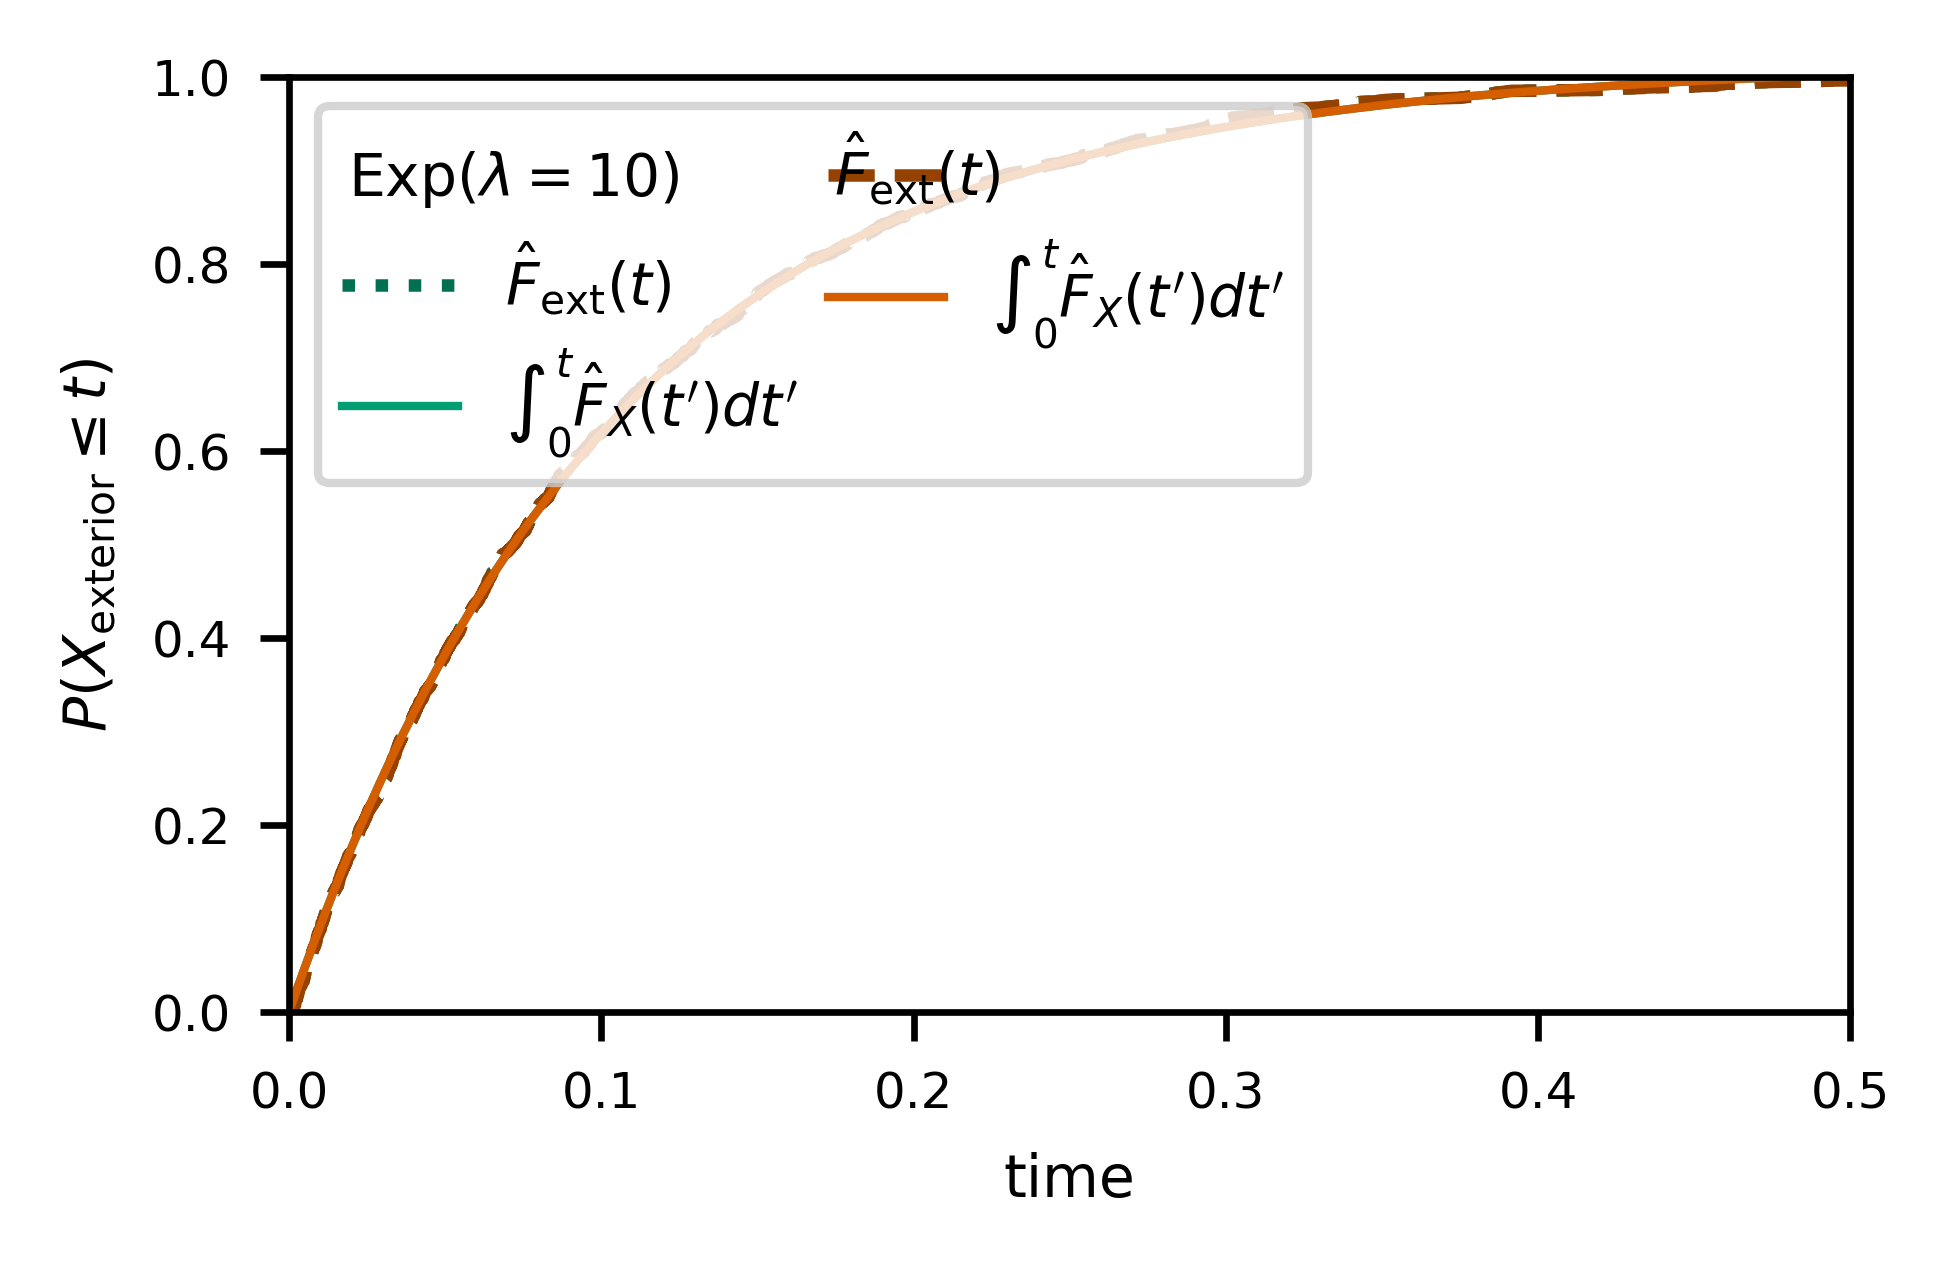

In [284]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = waits.window_size.max()
for var in wait_vars:
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    x_int, cdf_int = fw.ecdf_windowed(
        interior.wait_time.values, 
        interior.window_size.values,
        pad_left_at_x=0
    )
    # now compute integral of CDF w.r.t. 
    cdf_mid = (cdf_int[1:] + cdf_int[:-1]) / 2
    int_cdf = np.zeros_like(cdf_int)
    int_cdf[1:] = np.cumsum(cdf_mid * np.diff(x_int))
    
    exterior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] != 'interior') \
        & (waits['wait_type'] != 'full exterior'),
        ['wait_time', 'window_size']
    ]
    x_ext, cdf_ext = fw.ecdf(
        exterior.wait_time.values, 
        pad_left_at_x=0
    )
    
    t_all = np.sort(np.concatenate((x_int, x_ext)))
    resampled_int_cdf = np.interp(t_all, x_int, int_cdf)
    resampled_ext_cdf = np.interp(t_all, x_ext, cdf_ext)
    def err_f(ab, t, integrated_cdf, exterior_cdf):
        return np.linalg.norm(ab[0] * t + ab[1] * integrated_cdf - exterior_cdf)

    opt_out = scipy.optimize.minimize(
        err_f,
        x0=[1, -1],
        args=(t_all, resampled_int_cdf, resampled_ext_cdf),
        bounds=((0, np.inf), (-np.inf, 0)),
    )
    if not opt_out.success:
        raise ValueError("Unable to compute F_X(T)!")
    a, b = opt_out.x
    cdf_int_to_ext_cdf[var.name] = {'a': a, 'b': b}

    line, = ax.plot(x_ext, cdf_ext, c=0.7*np.array(var.color), ls=var.ls,
                    lw=1.5,
                    label='$\hat{F}_\mathrm{ext}(t)$')
    legend_entries[var.name].append(line)
    
    line, = ax.plot(x_int, a*x_int + b*int_cdf, c=var.color, ls='-',
                    lw=1,
                    label="$\int_0^t \hat{F}_X(t')dt'$")
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{exterior} \leq t)$')
ax.set_xlim([0, np.min([T, 5*max([var.mean() for var in wait_vars])])])
ax.set_ylim([0, 1])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, loc='upper left', ncol=2, columnspacing=0.5)

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

In [285]:
cdf_int_to_ext_cdf

{'Exp(10)': {'a': 9.669594268765326, 'b': -9.605659620465964}}

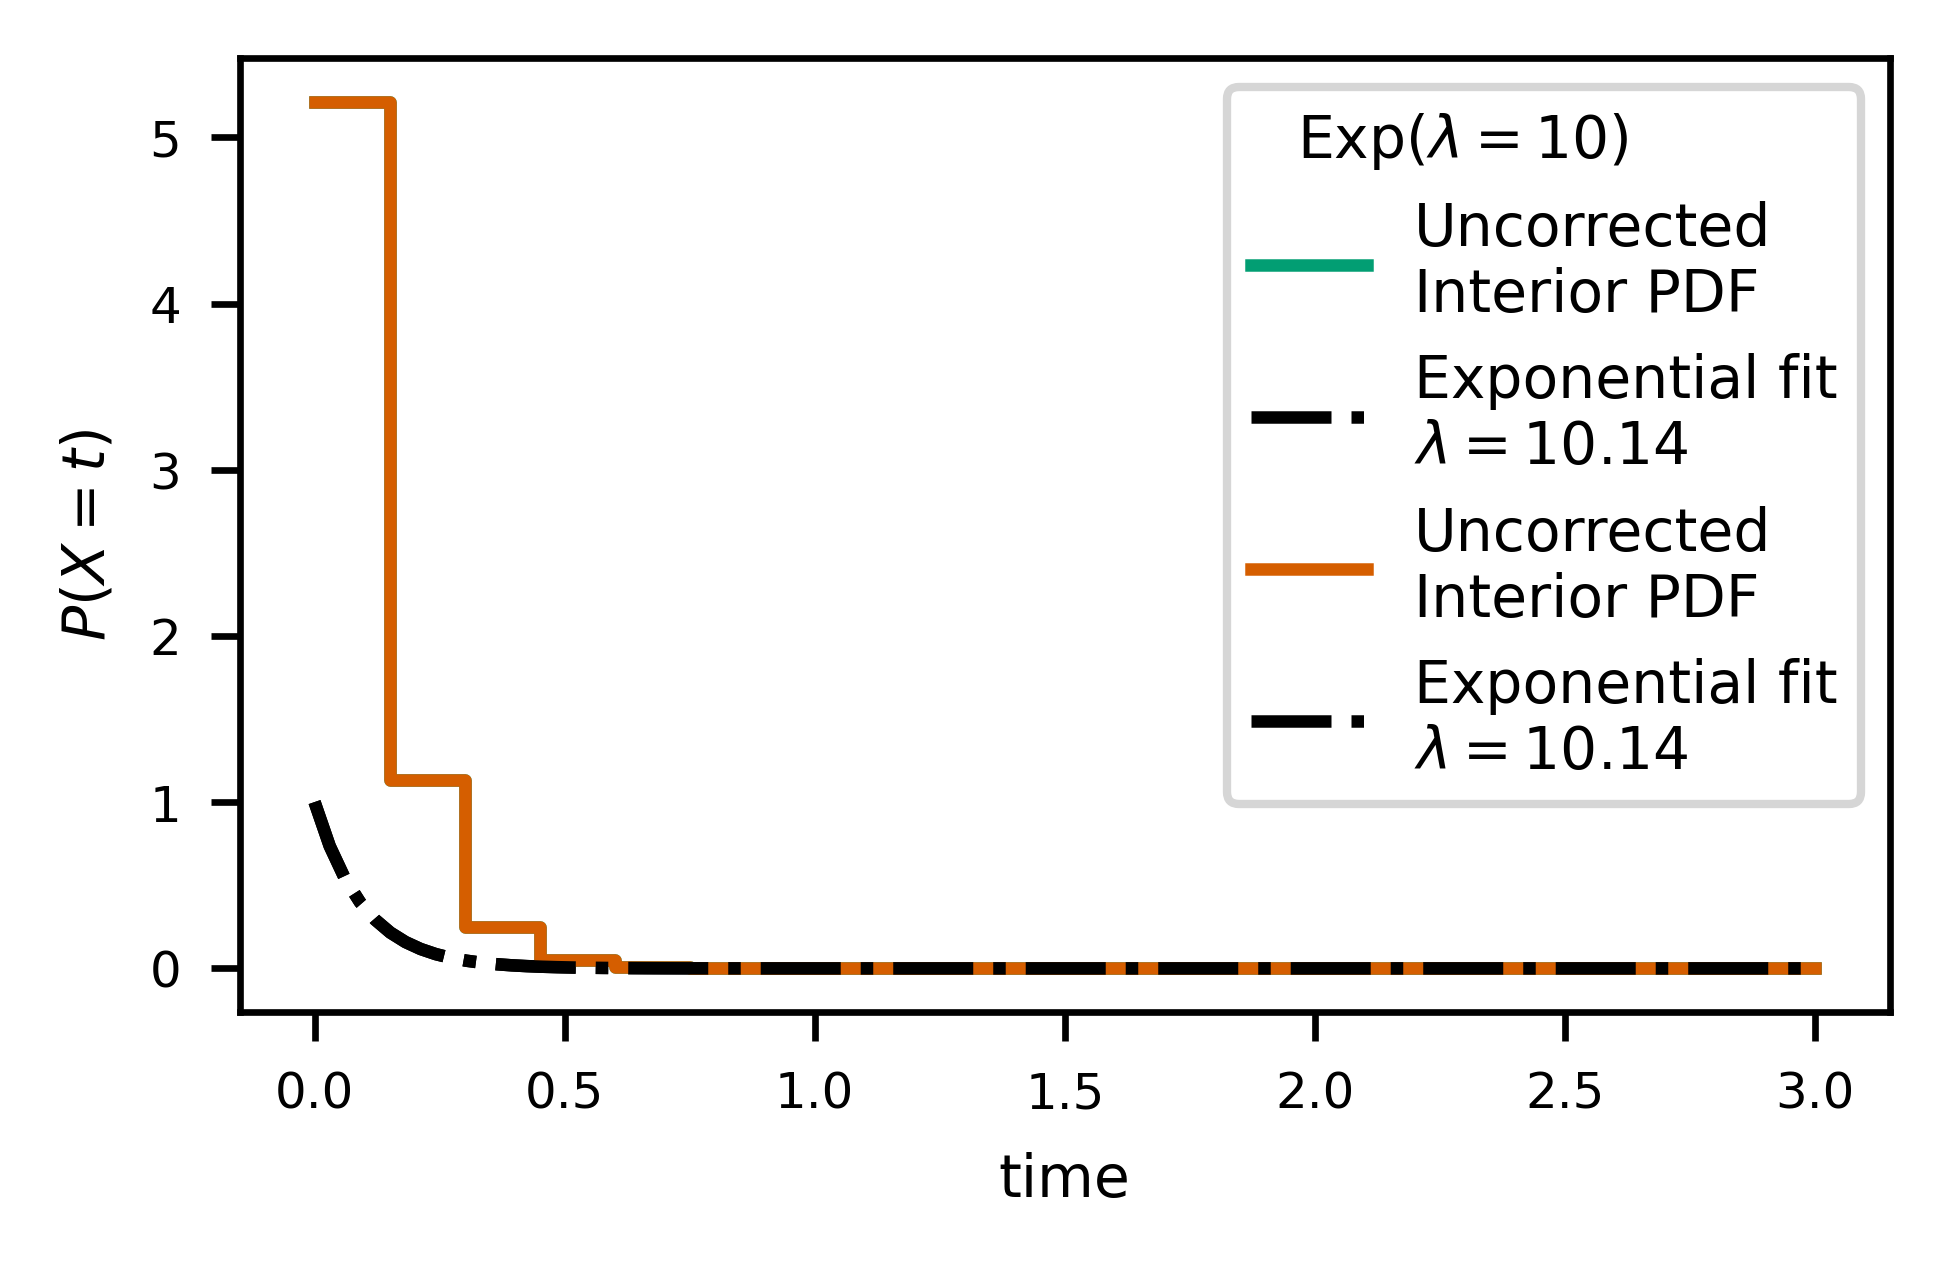

In [286]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)
legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars if var.name.find(focus) != -1 }
T = waits.window_size.max()

for var in wait_vars:
    if var.name.find(focus) == -1:
        continue

    # now compute the empirical distribution of the "interior" times
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        'wait_time'
    ].values
    x, cdf = fw.ecdf(interior, pad_left_at_x=0)
    
    t_bins = np.linspace(0, T, 21)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        interior, 
        bins=t_bins,
        density=1
    )
    X, Y = fw.bars_given_hist(y, t_bins)
    line, = ax.plot(X, Y, c=var.color, label='Uncorrected\nInterior PDF')
    legend_entries[var.name].append(line)
    log10Y = np.log10(Y)
#     idx = np.isfinite(X) & np.isfinite(log10Y) & (X > 1)
#     slope, intercept, _, _, _ = scipy.stats.linregress(X[idx], log10Y[idx])
    idx = X > 0
    (lam, D), std = scipy.optimize.curve_fit(exp_fit, x, 1 - cdf)
    t = np.linspace(0, T, 100)
    line, = ax.plot(t, exp_fit(t, lam, D), 'k-.', 
                    label='Exponential fit\n$\\lambda = ' + f'{lam:0.2f}$')
    legend_entries[var.name].append(line)
    # prettify the plot
#     ax.set_xlim([0, waits.window_size.max()])
#     ax.set_ylim([0, 1])
    ax.set_xlabel('time')
    ax.set_ylabel(r'1 - Cumulative probability')
    


ax.set_xlabel('time')
ax.set_ylabel(r'$P(X = t)$')
# ax.set_xlim([0, T])
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim([10**(-4), ax.get_ylim()[1]])

handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=1)
    # align bottom of legend 2% ax height above axis, filling full axis width
#     bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#     ncol=1, mode="expand", borderaxespad=0.
# )   
# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in np.array(vpack.get_children())[[0]]:
        hpack.get_children()[0].set_width(0)
        
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide1-uncorrected-exp.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide2-uncorrected-exp.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide0-uncorrected-exp.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide1m-uncorrected-exp.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide2m-correct-uncorrected-exp.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/fig2-slide2-exp-fit.pdf')

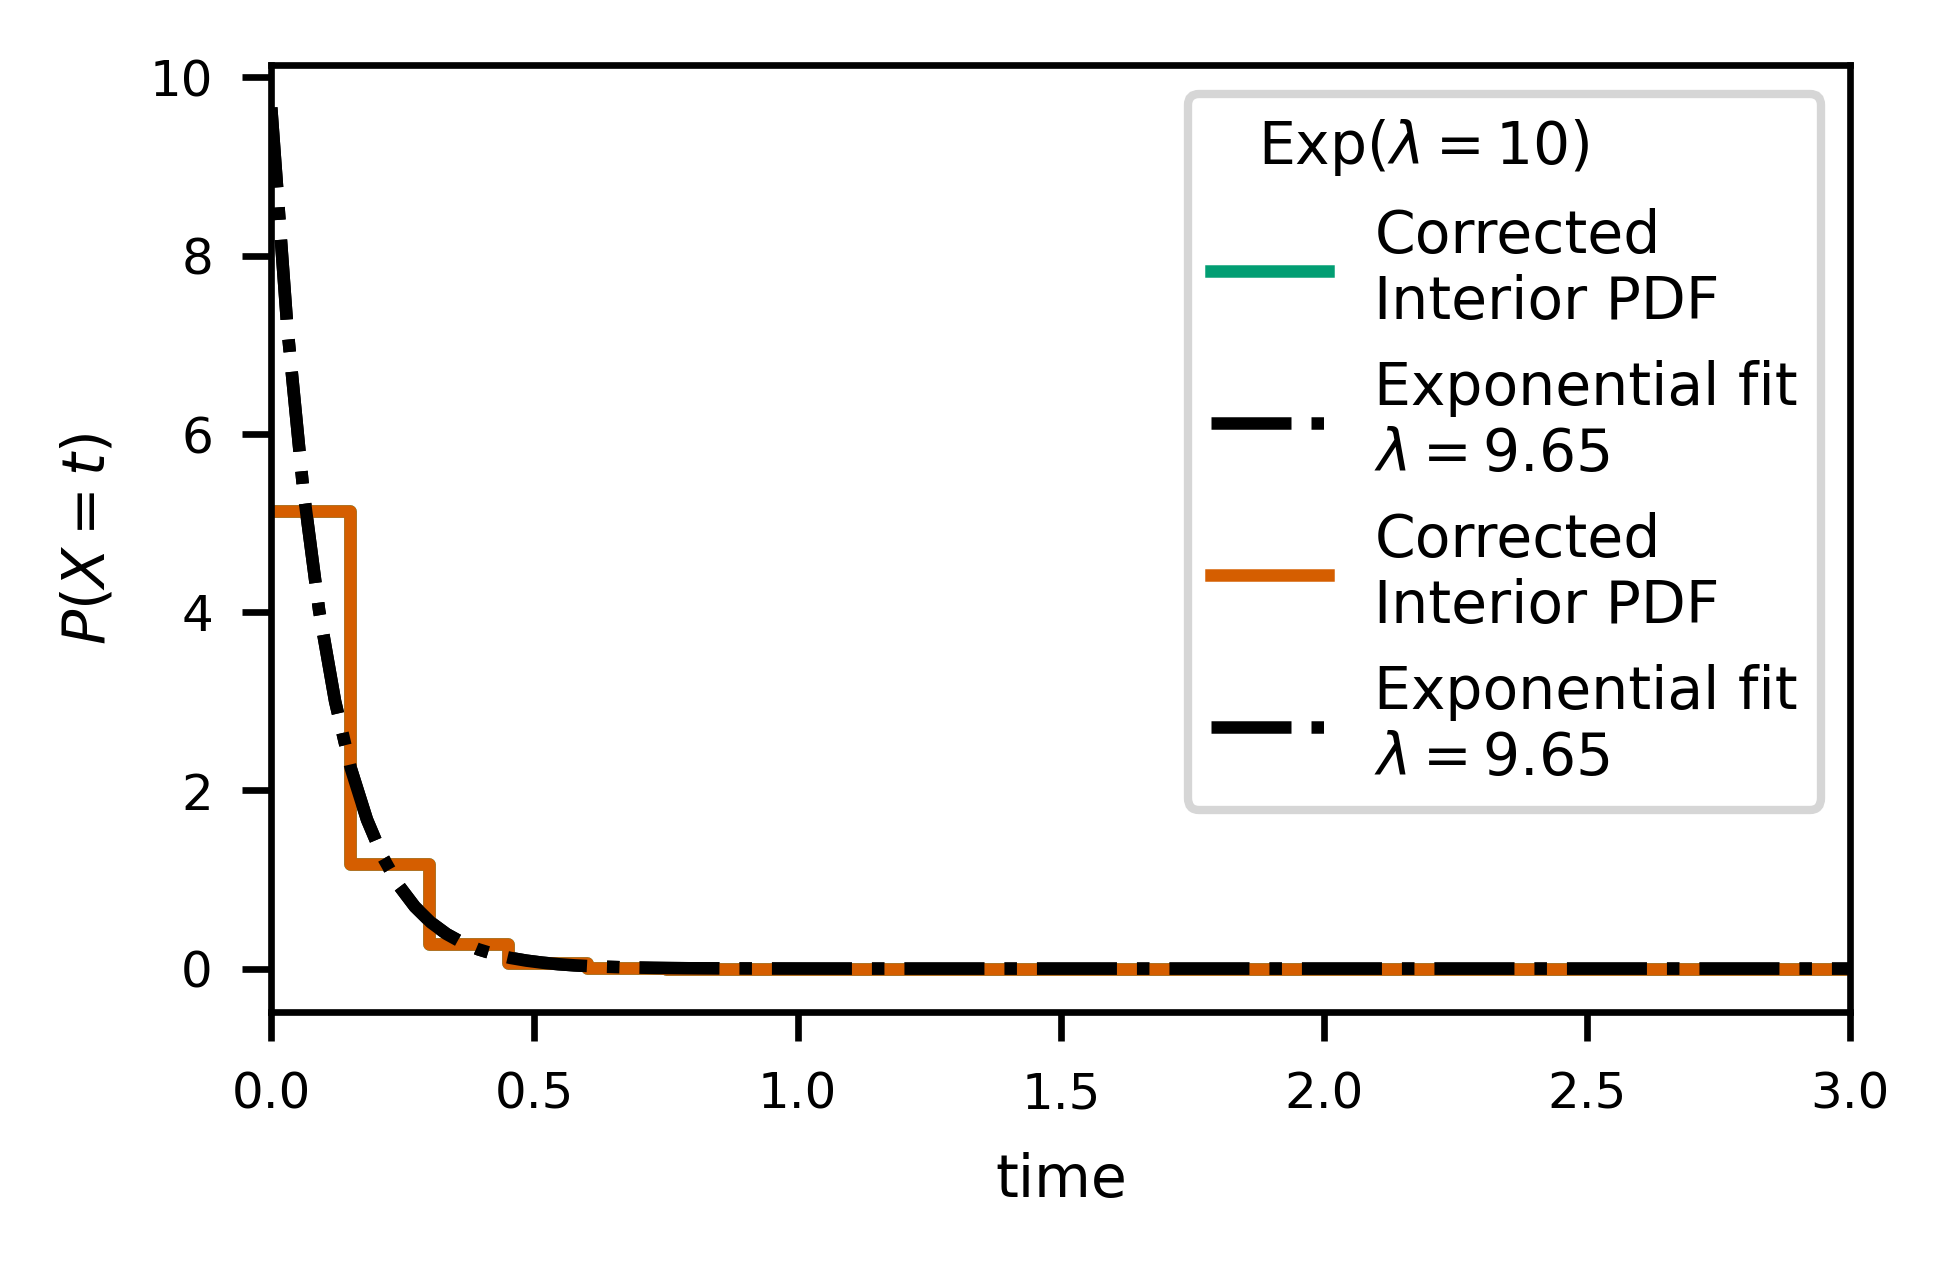

In [287]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)
legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars if var.name.find(focus) != -1 }
T = waits.window_size.max()

for var in wait_vars:
    if var.name.find(focus) == -1:
        continue

    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    interior['correction'] = 1/(interior.window_size - interior.wait_time)
    
    t_bins = np.linspace(0, T, 21)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        interior.wait_time.values, 
        weights=interior.correction / np.sum(interior.correction),
        bins=t_bins
    )
    y = y / dt
    X, Y = fw.bars_given_hist(y, t_bins)
    line, = ax.plot(X, Y, c=var.color, label='Corrected\nInterior PDF')
    legend_entries[var.name].append(line)
    X = (t_bins[1:] + t_bins[:-1]) / 2
    Y = y
    idx = X > 0
    x, cdf = fw.ecdf_windowed(interior.wait_time, interior.window_size, pad_left_at_x=0)
    a = cdf_int_to_ext_cdf[var.name]['a']
    b = cdf_int_to_ext_cdf[var.name]['b']    
    (lam, D), std = scipy.optimize.curve_fit(exp_fit, x, a + b*cdf)
    t = np.linspace(0, T, 100)
    line, = ax.plot(t, exp_fit(t, lam, D), 'k-.', 
                    label='Exponential fit\n$\\lambda = ' + f'{lam:0.2f}$')

    legend_entries[var.name].append(line)

    # prettify the plot
    ax.set_xlim([0, waits.window_size.max()])
#     ax.set_ylim([0, 1])
    ax.set_xlabel('time')
    ax.set_ylabel(r'1 - Cumulative probability')


ax.set_xlabel('time')
ax.set_ylabel(r'$P(X = t)$')
ax.set_xlim([0, T])
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim([10**(-4), ax.get_ylim()[1]])

handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=1)
    # align bottom of legend 2% ax height above axis, filling full axis width
#     bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#     ncol=1, mode="expand", borderaxespad=0.
# )   
# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
        
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide1-corrected-exp.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide0-corrected-exp.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide2-corrected-exp.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide1m-corrected-exp.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide2m-correct-corrected-exp.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/fig2-slide2-exp-fit.pdf')

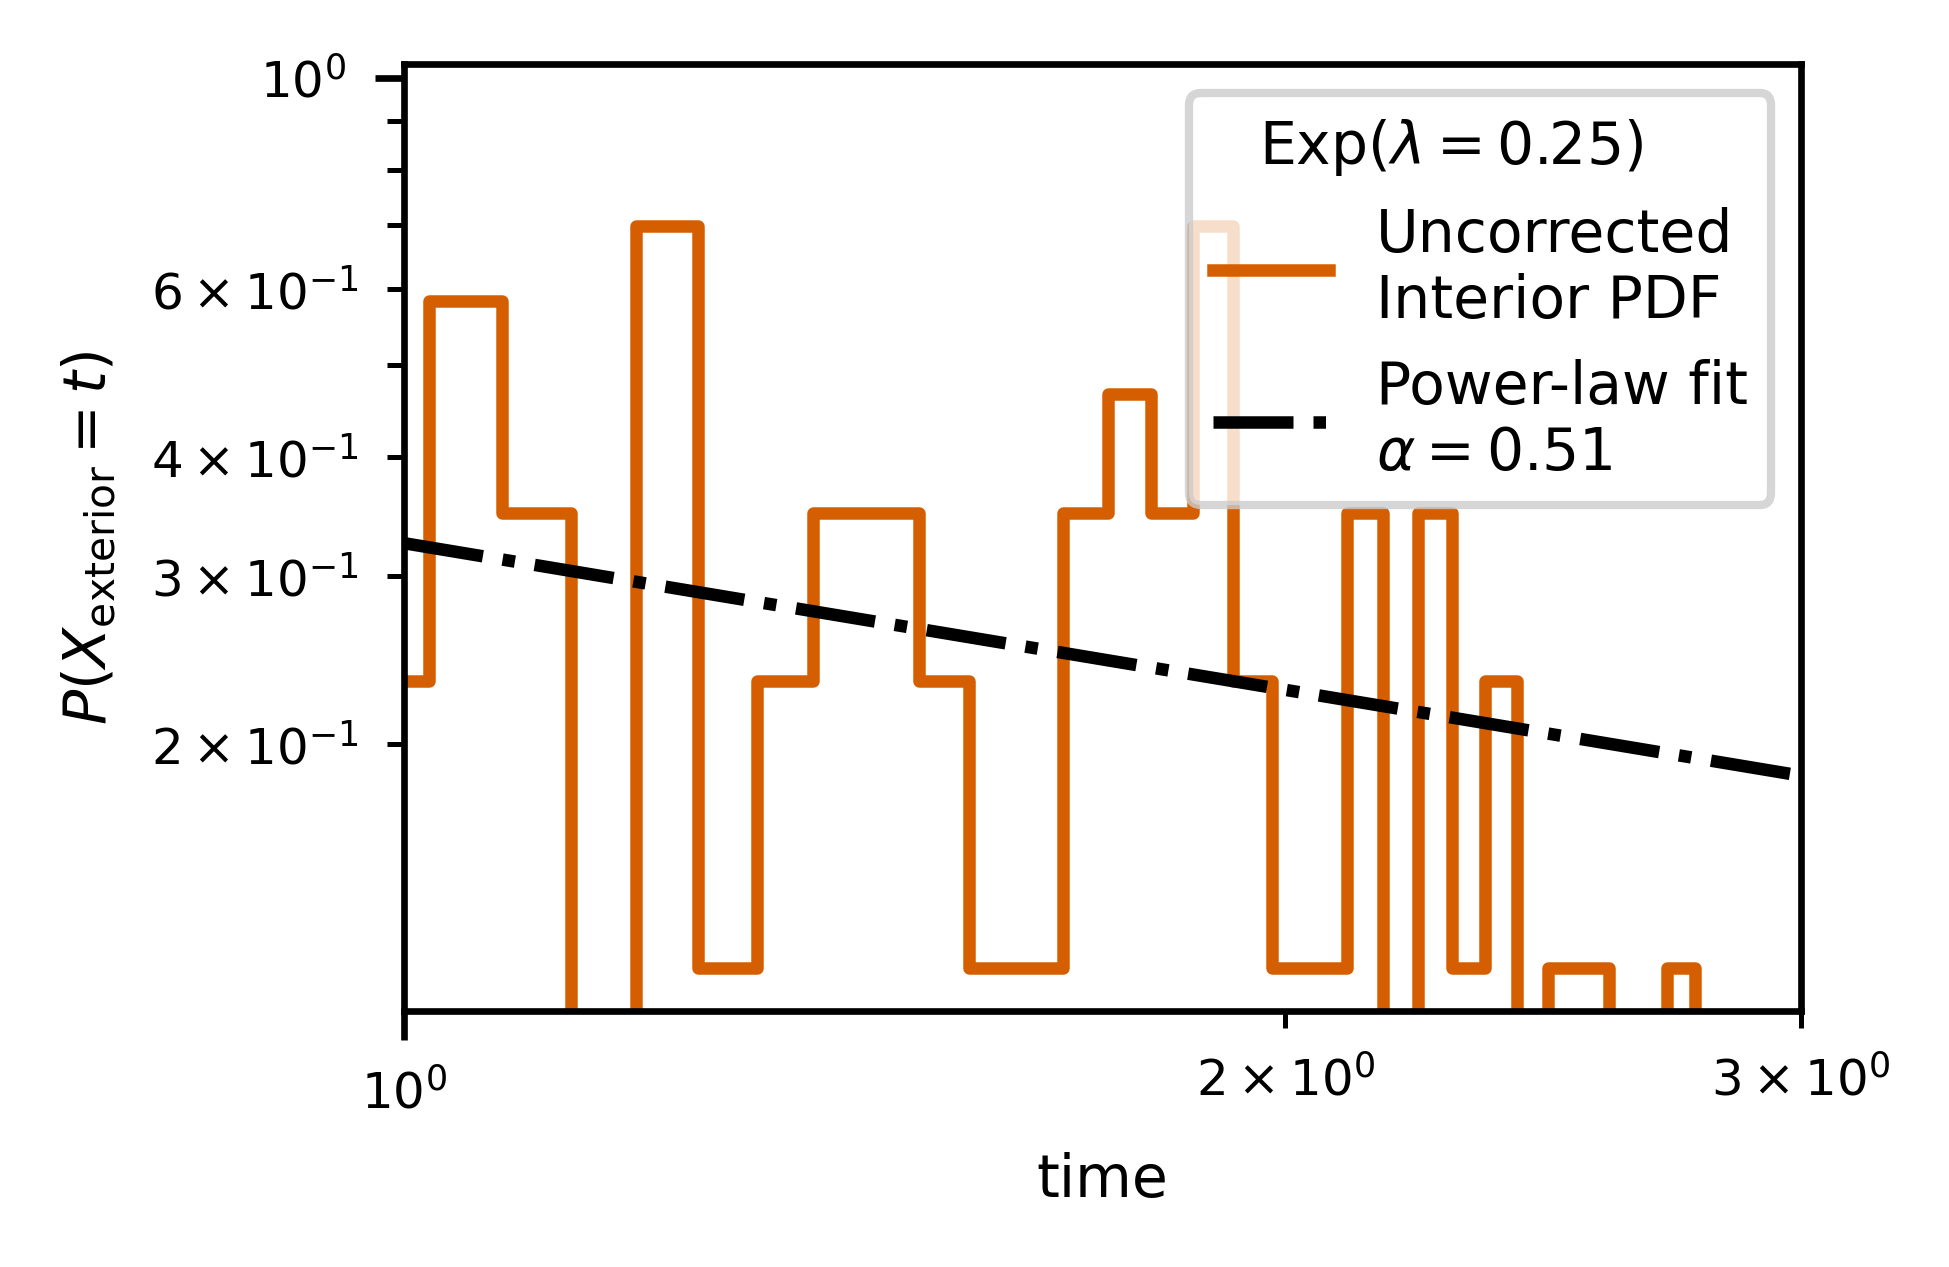

In [202]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)
legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars if var.name.find(focus) != -1 }
T = waits.window_size.max()

for var in wait_vars:
    if var.name.find(focus) == -1:
        continue

    # now compute the empirical distribution of the "interior" times
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        'wait_time'
    ].values
    x, cdf = fw.ecdf(interior, pad_left_at_x=0)
    
    t_bins = np.linspace(0, T, 51)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        interior, 
        bins=t_bins,
        density=1
    )
    X, Y = fw.bars_given_hist(y, t_bins)
    line, = ax.plot(X, Y, c=var.color, label='Uncorrected\nInterior PDF')
    legend_entries[var.name].append(line)
    log10X = np.log10(X)
    log10Y = np.log10(Y)
    idx = np.isfinite(log10X) & np.isfinite(log10Y)
    slope, intercept, _, _, _ = scipy.stats.linregress(log10X[idx], log10Y[idx])
    t = np.linspace(1, T, 100)
    line, = ax.plot(t, 10**(slope*np.log10(t) + intercept), 'k-.',                    
                    label='Power-law fit\n$\\alpha = ' + f'{-slope:0.2f}$')

    legend_entries[var.name].append(line)

    # prettify the plot
    ax.set_xlim([0, waits.window_size.max()])
#     ax.set_ylim([0, 1])
    ax.set_xlabel('time')
    ax.set_ylabel(r'1 - Cumulative probability')


ax.set_xlabel('time')
ax.set_ylabel(r'$P(X = t)$')
ax.set_xlim([1, T])
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim([10**(-4), ax.get_ylim()[1]])

handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=1)
    # align bottom of legend 2% ax height above axis, filling full axis width
#     bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#     ncol=1, mode="expand", borderaxespad=0.
# )   
# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
        
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide1-uncorrected-power.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide2-uncorrected-power.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/fig2-slide2-power-fit.pdf')

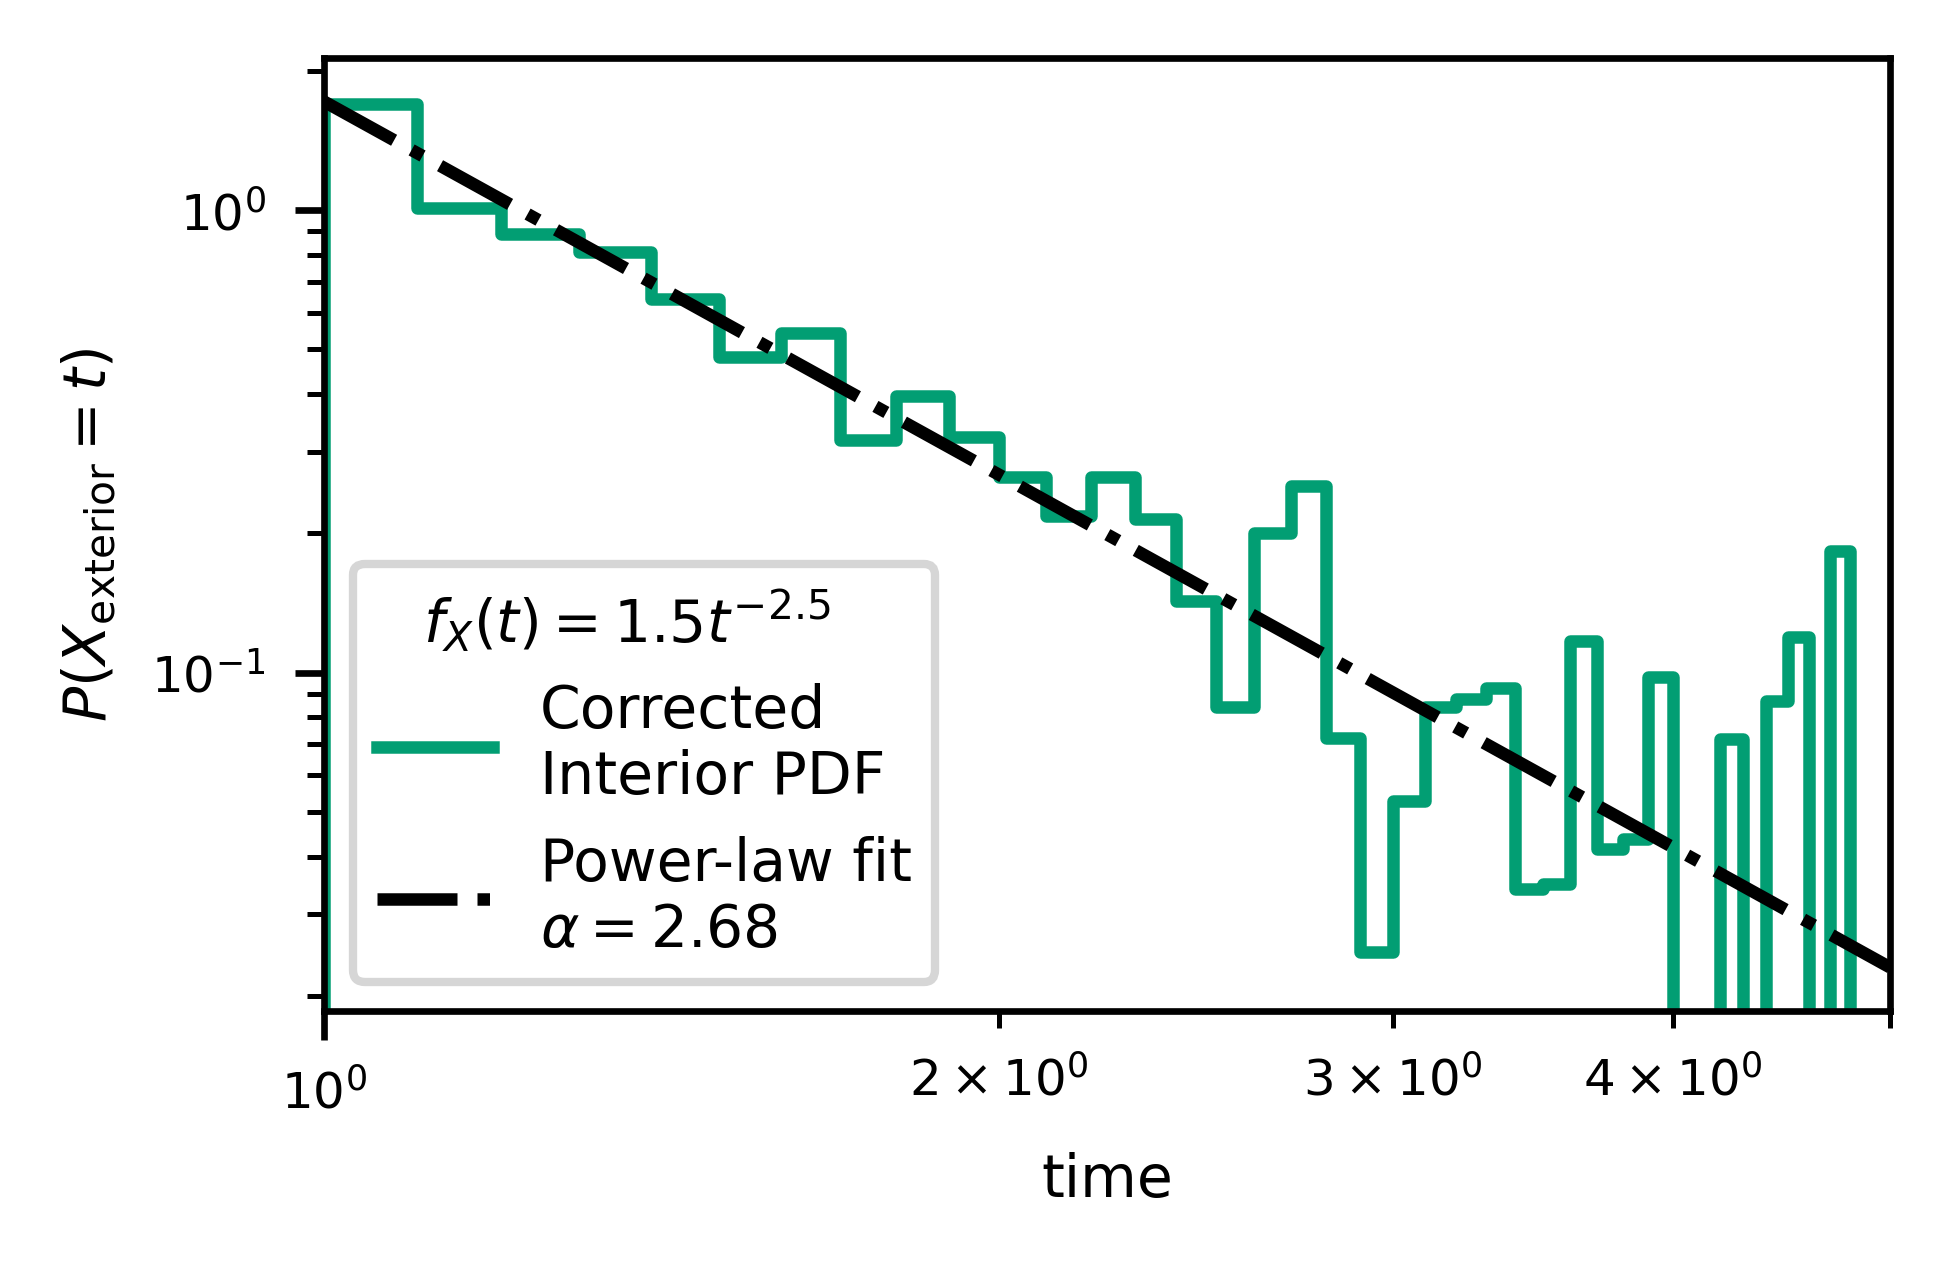

In [168]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)
legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars if var.name.find(focus) != -1 }
T = waits.window_size.max()

for var in wait_vars:
    if var.name.find(focus) == -1:
        continue

    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    interior['correction'] = 1/(interior.window_size - interior.wait_time)
    
    t_bins = np.linspace(0, T, 51)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        interior.wait_time.values, 
        weights=interior.correction / np.sum(interior.correction),
        bins=t_bins
    )
    y = y / dt
    X, Y = fw.bars_given_hist(y, t_bins)
    line, = ax.plot(X, Y, c=var.color, label='Corrected\nInterior PDF')
    legend_entries[var.name].append(line)
    X = (t_bins[1:] + t_bins[:-1]) / 2
    Y = y
    log10X = np.log10(X)
    log10Y = np.log10(Y)
    idx = np.isfinite(log10X) & np.isfinite(log10Y) & (X <= 4)
    slope, intercept, _, _, _ = scipy.stats.linregress(log10X[idx], log10Y[idx])
    t = np.linspace(1, T, 100)
    line, = ax.plot(t, 10**(slope*np.log10(t) + intercept), 'k-.',
                    label='Power-law fit\n$\\alpha = ' + f'{-slope:0.2f}$')
    legend_entries[var.name].append(line)

    # prettify the plot
    ax.set_xlim([0, waits.window_size.max()])
#     ax.set_ylim([0, 1])
    ax.set_xlabel('time')
    ax.set_ylabel(r'1 - Cumulative probability')


ax.set_xlabel('time')
ax.set_ylabel(r'$P(X = t)$')
ax.set_xlim([1, T])
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim([10**(-4), ax.get_ylim()[1]])

handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=1)
    # align bottom of legend 2% ax height above axis, filling full axis width
#     bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#     ncol=1, mode="expand", borderaxespad=0.
# )   
# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
        
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide1-corrected-power.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/figS4-slide2-corrected-power.pdf')
# plt.savefig('/home/bbeltr1/Documents/work/ajspakow/presentations/lab-meeting-2020-12-15/figures/fig2-slide2-exp-fit.pdf')

### Many fits

In [300]:
import pandas as pd
from multiprocessing import Pool

window_size = 1
num_repeats = 1
num_replicates = 1_000
lam_to_try = np.logspace(-2, 2, 5)
uncorrected_fits = pd.DataFrame([], columns=['real_lam', 'lam_fit', 'num_replicates'])
corrected_fits = uncorrected_fits.copy()
control_fits = uncorrected_fits.copy()


def get_three_fits(lam):
    wait_vars = [
        Variable(scipy.stats.expon(scale=1/lam), name='A'),
        Variable(scipy.stats.expon(scale=1/lam), name='B')
    ]
    trajs = fw.ab_window(
        [var.rvs for var in wait_vars],
        window_size=window_size, 
        offset=-100*np.sum([var.mean() for var in wait_vars]),
        num_replicates=num_replicates,  
        states=[var.name for var in wait_vars]
    )
    waits = trajs \
        .groupby('replicate') \
        .apply(fw.traj_to_waits)
    interior = waits.loc[
        waits['wait_type'] == 'interior',
        ['wait_time', 'window_size']
    ]
    corr_lam, _, _ = corrected_exponential_fit(interior)
    uncorr_lam, _, _ = uncorrected_exponential_fit(interior.wait_time)
    
    control_lam, _, _ = uncorrected_exponential_fit(
        scipy.stats.expon(scale=1/lam).rvs(size=(num_replicates,))
    )
    return lam, corr_lam, uncorr_lam, control_lam
        
for lam in lam_to_try:
    for _ in range(num_repeats):
        print(get_three_fits(lam))

(0.01, nan, nan, 0.010493813289778815)


/home/bbeltr1/.miniconda/envs/finite_window/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(0.1, 157.64414263984486, 2.994482973827153, 0.09801184086617849)
(1.0, 5.755335456784828, 3.1207826758147807, 0.986407729049906)
(10.0, 16.146362817431626, 11.145403382532056, 9.999842427883026)
(100.0, 99.46068394889775, 101.53416261181256, 97.09510383095963)


In [ ]:
from multiprocessing import Pool
import pandas as pd

window_size = 1
num_repeats = 1
num_replicates = 1_000
lam_to_try = np.logspace(-2, 1, 4)
    
def get_fits(*args, **wargs):
    fits = []
    for lam in lam_to_try:
        wait_vars = [
            Variable(scipy.stats.expon(scale=1/lam), name='A'),
            Variable(scipy.stats.expon(scale=1/lam), name='B')
        ]
        trajs = fw.ab_window(
            [var.rvs for var in wait_vars],
            window_size=window_size, 
            offset=-100*np.sum([var.mean() for var in wait_vars]),
            num_replicates=num_replicates,  
            states=[var.name for var in wait_vars]
        )
        waits = trajs \
            .groupby('replicate') \
            .apply(fw.traj_to_waits)
        interior = waits.loc[
            waits['wait_type'] == 'interior',
            ['wait_time', 'window_size']
        ]
        df = pd.DataFrame([], columns=['real_lam', 'lam_fit', 'num_replicates', 'type'])
        lam_fit, D, std = corrected_exponential_fit(interior)
        df = df.append(
            {'real_lam': lam, 'lam_fit': lam_fit, 'num_replicates': num_replicates,
             'type': 'corrected interior'},
            ignore_index=True
        )
        lam_fit, D, std = uncorrected_exponential_fit(interior.wait_time)
        df = df.append(
            {'real_lam': lam, 'lam_fit': lam_fit, 'num_replicates': num_replicates,
             'type': 'uncorrected'},
            ignore_index=True
        )
        lam_fit, D, std = uncorrected_exponential_fit(
            scipy.stats.expon(scale=1/lam).rvs(size=(num_replicates,))
        )
        df = df.append(
            {'real_lam': lam, 'lam_fit': lam_fit, 'num_replicates': num_replicates,
             'type': 'control'},
            ignore_index=True
        )
        fits.append(df)
    fits = pd.concat(fits)
    return fits

with Pool(12) as p:
    fits = pd.concat(p.map(get_fits, range(num_repeats)))

In [319]:
import pandas as pd

window_size = 1
num_repeats = 1
num_replicates = 1_000
lam_to_try = np.logspace(-2, 1, 4)
fits = []
for lam in lam_to_try:
    for _ in range(num_repeats):
        wait_vars = [
            Variable(scipy.stats.expon(scale=1/lam), name='A'),
            Variable(scipy.stats.expon(scale=1/lam), name='B')
        ]
        trajs = fw.ab_window(
            [var.rvs for var in wait_vars],
            window_size=window_size, 
            offset=-100*np.sum([var.mean() for var in wait_vars]),
            num_replicates=num_replicates,  
            states=[var.name for var in wait_vars]
        )
        waits = trajs \
            .groupby('replicate') \
            .apply(fw.traj_to_waits)
        interior = waits.loc[
            waits['wait_type'] == 'interior',
            ['wait_time', 'window_size']
        ]
        df = pd.DataFrame([], columns=['real_lam', 'lam_fit', 'num_replicates', 'type'])
        lam_fit, D, std = corrected_exponential_fit(interior)
        df = df.append(
            {'real_lam': lam, 'lam_fit': lam_fit, 'num_replicates': num_replicates,
             'type': 'corrected interior'},
            ignore_index=True
        )
        lam_fit, D, std = uncorrected_exponential_fit(interior.wait_time)
        df = df.append(
            {'real_lam': lam, 'lam_fit': lam_fit, 'num_replicates': num_replicates,
             'type': 'uncorrected'},
            ignore_index=True
        )
        lam_fit, D, std = uncorrected_exponential_fit(
            scipy.stats.expon(scale=1/lam).rvs(size=(num_replicates,))
        )
        df = df.append(
            {'real_lam': lam, 'lam_fit': lam_fit, 'num_replicates': num_replicates,
             'type': 'control'},
            ignore_index=True
        )
        fits.append(df)
fits = pd.concat(fits)

In [320]:
fits.sort_values(['real_lam', 'type'])

,real_lam,lam_fit,num_replicates,type
2,0.01,0.010026,1000,control
0,0.01,NaN,1000,corrected interior
1,0.01,NaN,1000,uncorrected
2,0.10,0.094937,1000,control
0,0.10,0.474392,1000,corrected interior
1,0.10,2.934536,1000,uncorrected
2,1.00,1.002412,1000,control
0,1.00,0.969471,1000,corrected interior
1,1.00,3.209752,1000,uncorrected
2,10.00,9.649221,1000,control


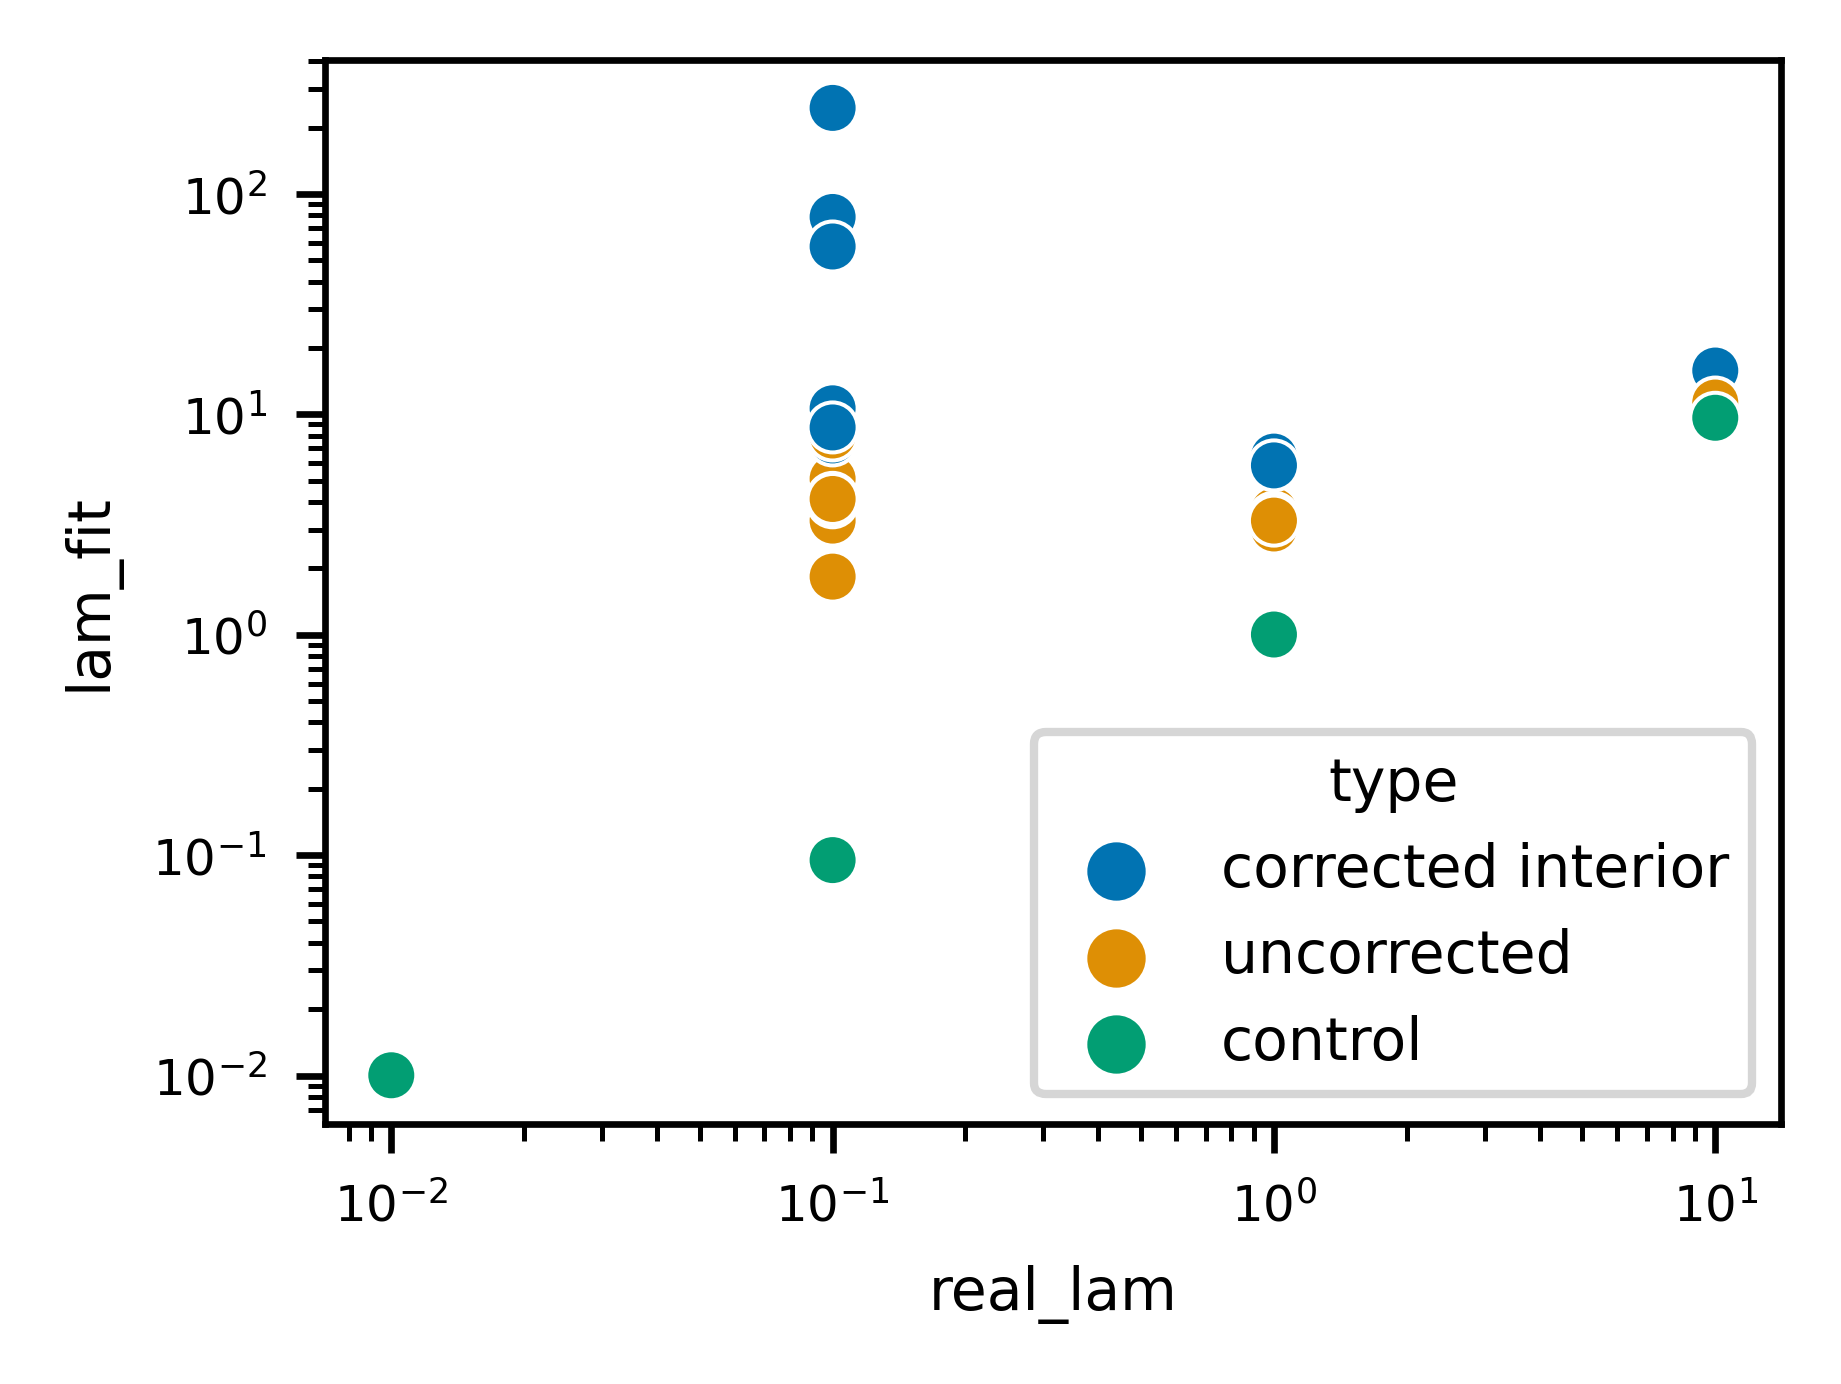

In [316]:
import seaborn as sns
sns.scatterplot(x='real_lam', y='lam_fit', hue='type', data=fits)
plt.yscale('log')
plt.xscale('log')

In [299]:
corrected_fits

,real_lam,lam_fit,num_replicates
0,0.01,NaN,1000.0
1,0.10,0.339444,1000.0
2,1.00,0.991216,1000.0
3,10.00,10.103885,1000.0
4,100.00,100.918215,1000.0


In [290]:
corrected_fits

,real_lam,lam_fit,num_replicates
0,0.01,NaN,1000.0
1,0.10,0.301154,1000.0
2,1.00,0.838862,1000.0
3,10.00,9.916213,1000.0
4,100.00,97.491029,1000.0


In [291]:
uncorrected_fits

,real_lam,lam_fit,num_replicates
0,0.01,NaN,1000.0
1,0.10,3.460415,1000.0
2,1.00,3.366376,1000.0
3,10.00,11.348787,1000.0
4,100.00,98.834110,1000.0


In [294]:
def exp_fit(x, lam, D):
    return D*np.exp(-lam*x)

def uncorrected_exponential_fit(interior):
    if len(interior) < 3:
        return 3*[np.nan]
    x, cdf = fw.ecdf(interior, pad_left_at_x=0)
    (lam, D), std = scipy.optimize.curve_fit(exp_fit, x, 1 - cdf)
    return lam, D, std

def corrected_exponential_fit(interior):
    if len(interior) < 3:
        return 3*[np.nan]
    x_int, cdf_int = fw.ecdf_windowed(
        interior.wait_time, 
        interior.window_size,
        pad_left_at_x=0
    )
    # now compute integral of CDF w.r.t. 
    cdf_mid = (cdf_int[1:] + cdf_int[:-1]) / 2
    int_cdf = np.zeros_like(cdf_int)
    int_cdf[1:] = np.cumsum(cdf_mid * np.diff(x_int))
    exterior = waits.loc[
        (waits['wait_type'] != 'interior') & (waits['wait_type'] != 'full exterior'),
        ['wait_time', 'window_size']
    ]
    x_ext, cdf_ext = fw.ecdf(
        exterior.wait_time.values, 
        pad_left_at_x=0
    )
    
    t_all = np.sort(np.concatenate((x_int, x_ext)))
    resampled_int_cdf = np.interp(t_all, x_int, int_cdf)
    resampled_ext_cdf = np.interp(t_all, x_ext, cdf_ext)
    def err_f(ab, t, integrated_cdf, exterior_cdf):
        return np.linalg.norm(ab[0] * t + ab[1] * integrated_cdf - exterior_cdf)

    opt_out = scipy.optimize.minimize(
        err_f,
        x0=[1, -1],
        args=(t_all, resampled_int_cdf, resampled_ext_cdf),
        bounds=((0, np.inf), (-np.inf, 0)),
    )
    if not opt_out.success:
        raise ValueError("Unable to compute F_X(T)!")
    a, b = opt_out.x
    
    (lam, D), std = scipy.optimize.curve_fit(exp_fit, x_int, a + b*cdf_int)
    return lam, D, std
    
    

### Naive histograms and Meier Kaplan

In [12]:
import lifelines
kmfs = {
    name: lifelines.KaplanMeierFitter() \
    .fit(state['wait_time'].values,
         event_observed=(state['wait_type'] == 'interior').values,
         label='Meier-Kaplan Estimator, $\pm$95% conf int')
    for name, state in waits.groupby('state')
}

/home/bbeltr1/.miniconda/envs/finite_window/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home/bbeltr1/.miniconda/envs/finite_window/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


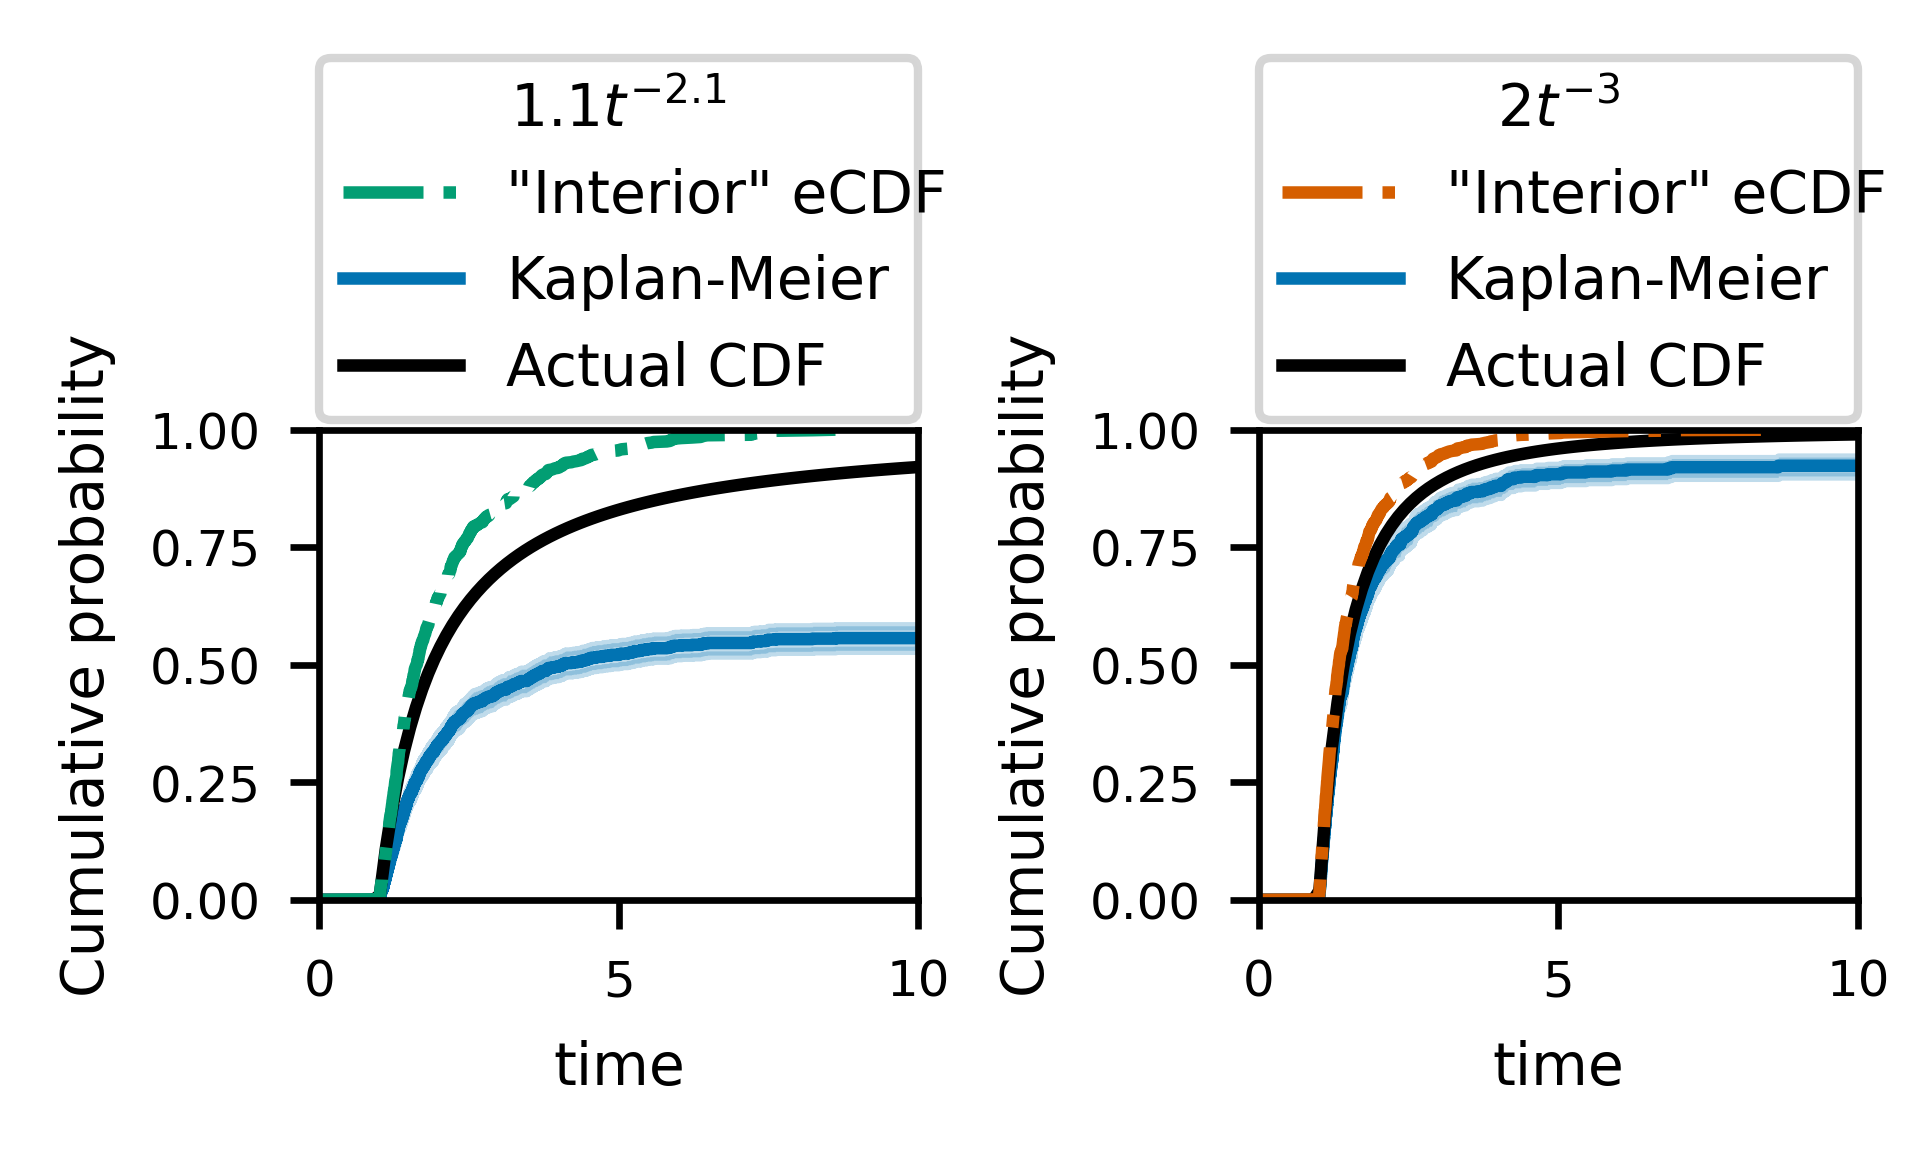

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(
    figsize=figure_size['two-by-half column, four legend entries above'], 
    constrained_layout=True
)
axs = fig.subplot_mosaic([[var.name for var in wait_vars]])
T = waits.window_size.max()
for var in wait_vars:
    # lifelines insists on returning a new Axes object....
    km_l = mpl.lines.Line2D([], [], color=km_color, label='Kaplan-Meier')
    ax = kmfs[var.name].plot_cumulative_density(
        color=km_color, ax=axs[var.name]
    )

    # plot actual distribution
    t = np.linspace(0, T, 100)
    analytical_l,  = ax.plot(
        t, var.cdf(t), color='k', label='Actual CDF'
    )

    # now compute the empirical distribution of the "interior" times
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        'wait_time'
    ].values
    x, cdf = fw.ecdf(interior, pad_left_at_x=0)
    
    interior_l, = ax.plot(
        x, cdf, c=var.color, ls=interior_linestyle,
        label='"Interior" eCDF'
    )

    # prettify the plot
    ax.set_xlim([0, waits.window_size.max()])
    ax.set_ylim([0, 1])
    ax.set_xlabel('time')
    ax.set_ylabel(r'Cumulative probability')

    # an empty handle acts effectively as a legend "title"
#     empty_handle = mpl.patches.Patch(alpha=0, label=var.pretty_name)
    legend = ax.legend(
        title=var.pretty_name,
        handles=[interior_l, km_l, analytical_l],
        # align bottom of legend 2% ax height above axis, filling full axis width
        bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
        ncol=1, mode="expand", borderaxespad=0.
    )
#     legend.get_texts()[0].set_ha('right')
#     legend.get_texts()[0].set_position((-160, 0))

In [35]:
{var.name: var.mean() for var in wait_vars}

{'Pareto(b=1.5)': 3.0, 'Pareto(b=2)': 2.0}

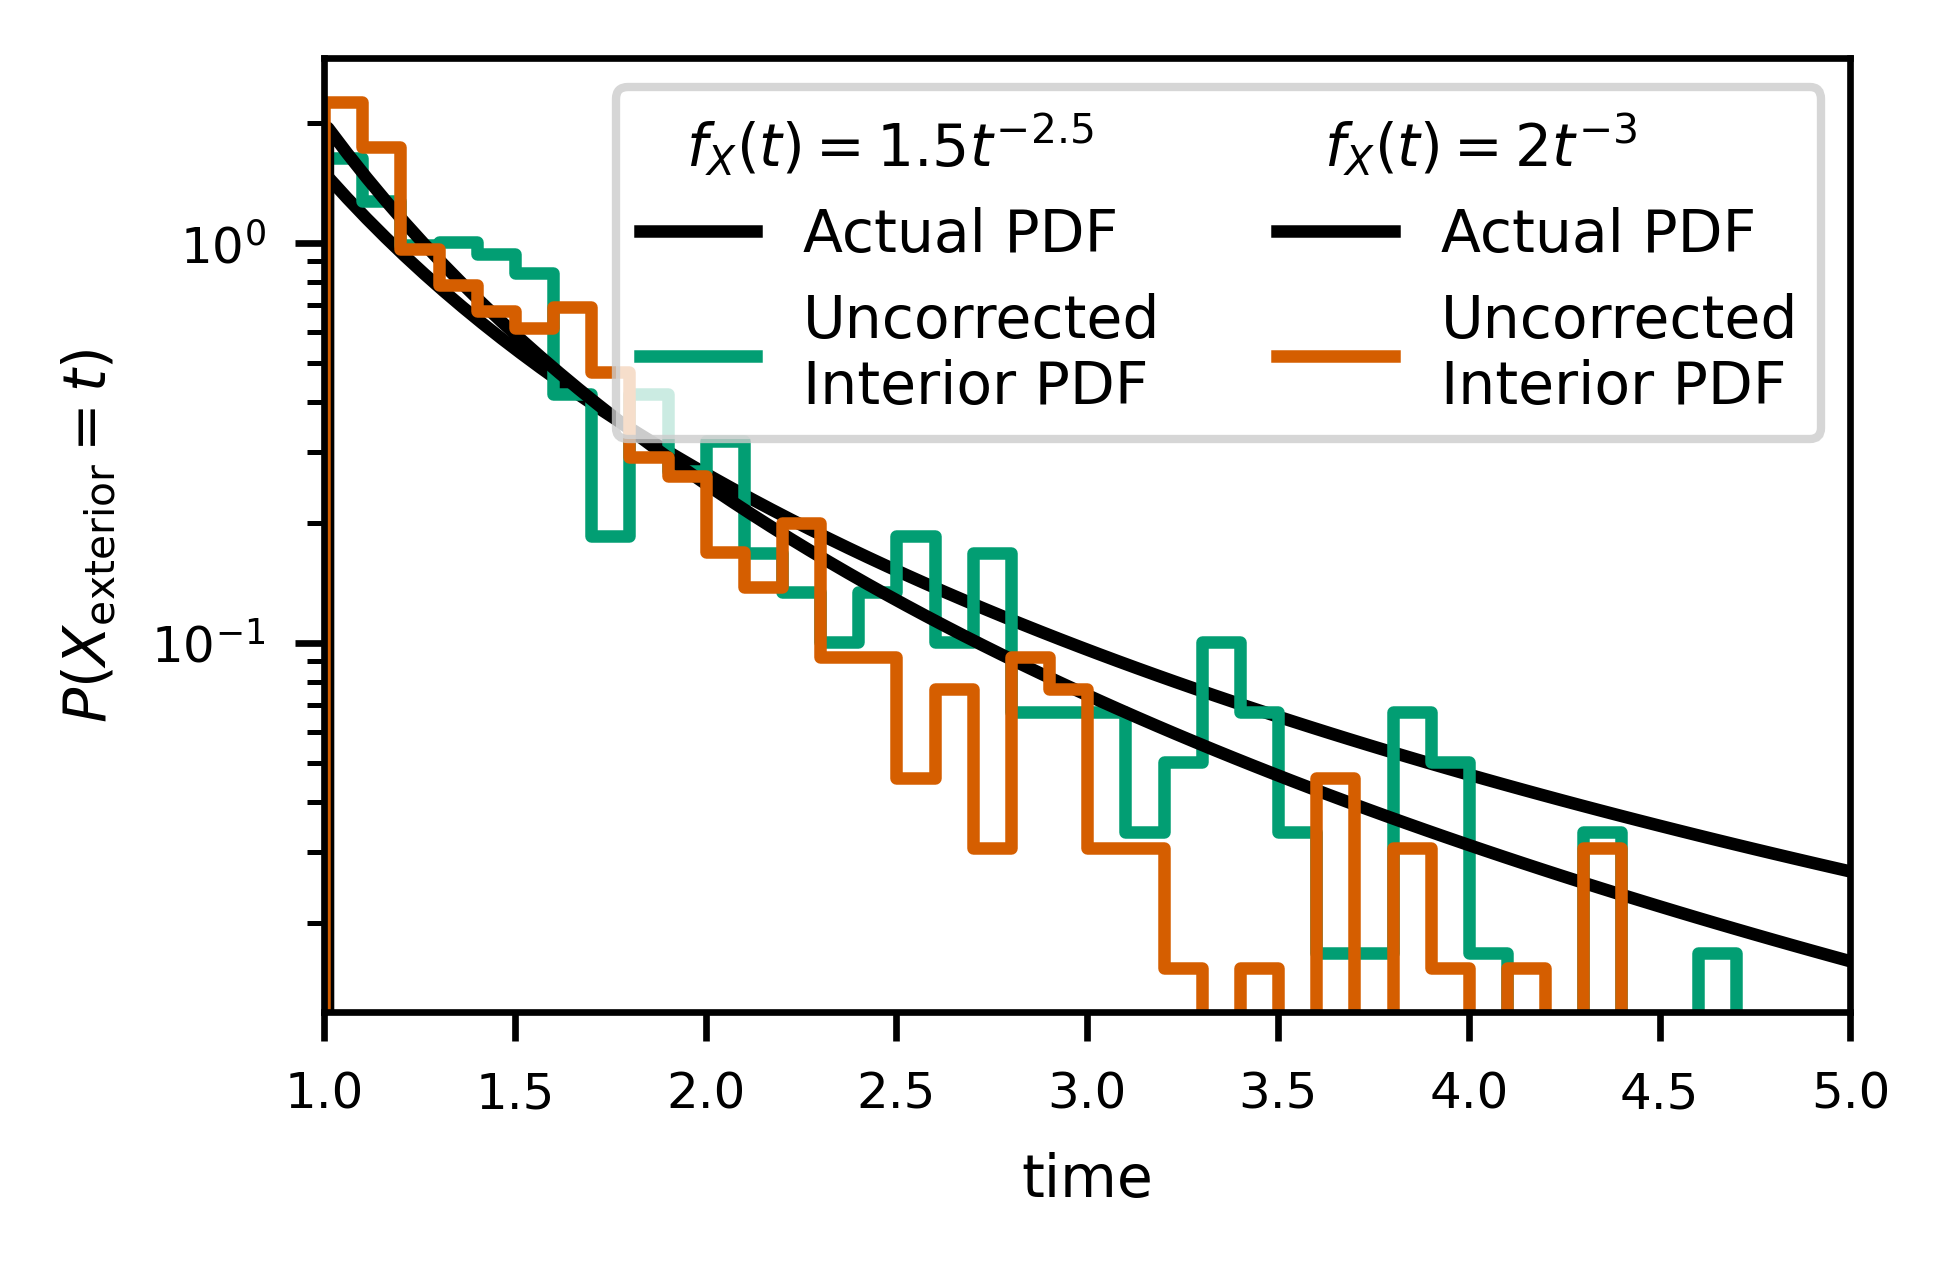

In [40]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)
legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = waits.window_size.max()

for var in wait_vars:
    # plot actual distribution
    t = np.linspace(0, T, 100)
    analytical_l,  = ax.plot(
        t, var.pdf(t), color='k', label='Actual PDF'
    )
    legend_entries[var.name].append(analytical_l)

    # now compute the empirical distribution of the "interior" times
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        'wait_time'
    ].values
    x, cdf = fw.ecdf(interior, pad_left_at_x=0)
    
    t_bins = np.linspace(0, T, 51)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        interior, 
        bins=t_bins,
        density=1
    )
    X, Y = fw.bars_given_hist(y, t_bins)
    line, = ax.plot(X, Y, c=var.color, label='Uncorrected\nInterior PDF')
    legend_entries[var.name].append(line)

    # prettify the plot
    ax.set_xlim([0, waits.window_size.max()])
#     ax.set_ylim([0, 1])
    ax.set_xlabel('time')
    ax.set_ylabel(r'1 - Cumulative probability')


ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{exterior} = t)$')
ax.set_xlim([1, T])
ax.set_yscale('log')
# ax.set_ylim([10**(-4), ax.get_ylim()[1]])

handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=2)
    # align bottom of legend 2% ax height above axis, filling full axis width
#     bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#     ncol=1, mode="expand", borderaxespad=0.
# )   
# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)

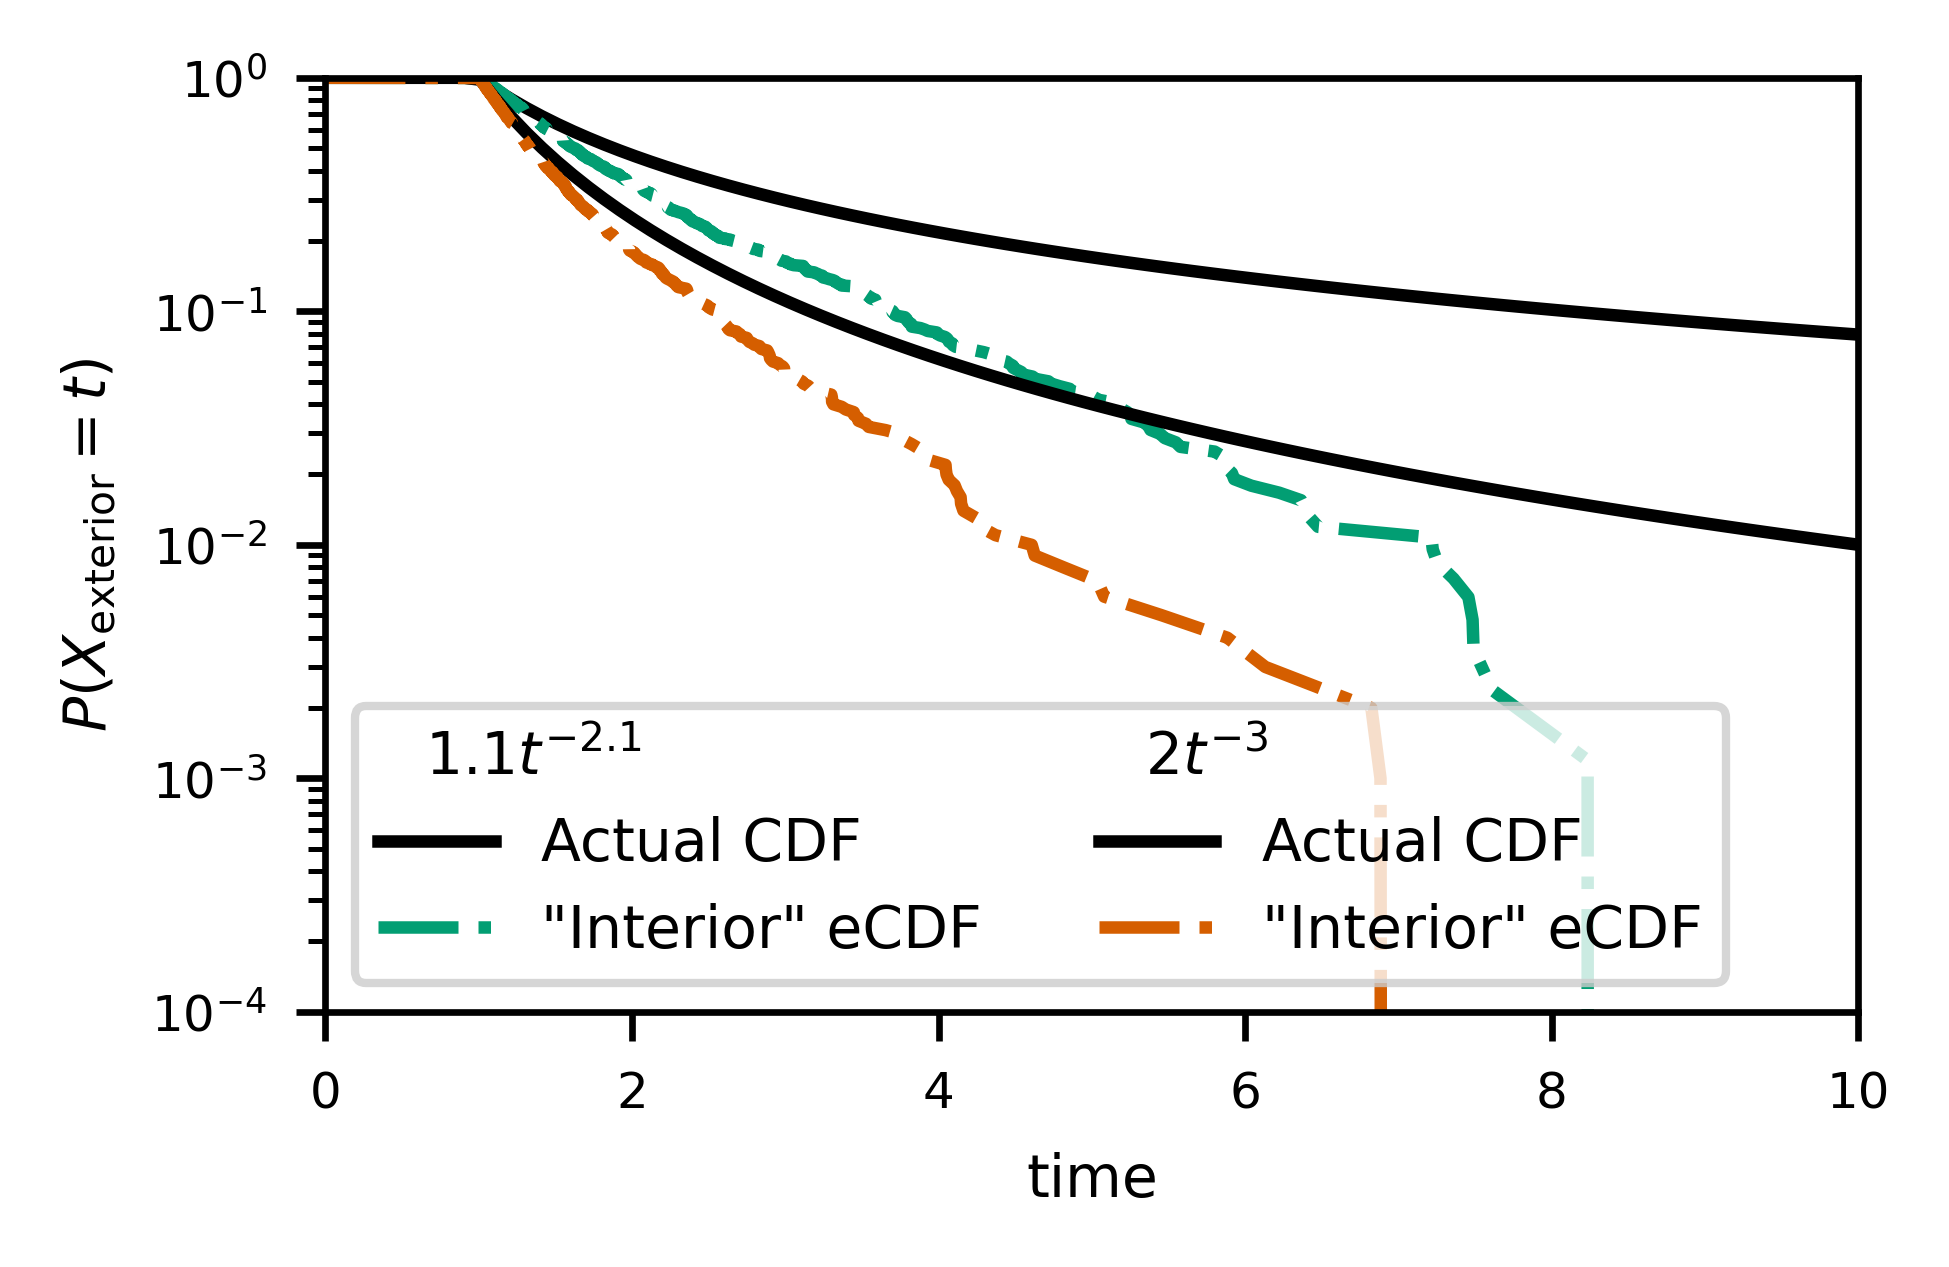

In [22]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)
legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = waits.window_size.max()

for var in wait_vars:
    # plot actual distribution
    t = np.linspace(0, T, 100)
    analytical_l,  = ax.plot(
        t, 1 - var.cdf(t), color='k', label='Actual CDF'
    )
    legend_entries[var.name].append(analytical_l)

    # now compute the empirical distribution of the "interior" times
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        'wait_time'
    ].values
    x, cdf = fw.ecdf(interior, pad_left_at_x=0)
    
    interior_l, = ax.plot(
        x, 1 - cdf, c=var.color, ls=interior_linestyle,
        label='"Interior" eCDF'
    )
    legend_entries[var.name].append(interior_l)

    # prettify the plot
    ax.set_xlim([0, waits.window_size.max()])
    ax.set_ylim([0, 1])
    ax.set_xlabel('time')
    ax.set_ylabel(r'1 - Cumulative probability')


ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{exterior} = t)$')
ax.set_xlim([0, T])
ax.set_yscale('log')
ax.set_ylim([10**(-4), ax.get_ylim()[1]])

handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=2)
    # align bottom of legend 2% ax height above axis, filling full axis width
#     bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#     ncol=1, mode="expand", borderaxespad=0.
# )   
# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)

As far as I can tell at the time of writing this (end of 2020), the most commonly applied solution to this problem in the literature is in fact to  use the "Kaplan-Meier" correction, which can be seen above (in blue, along with 95% (pointwise) confidence
bands) to perform as poorly as the naive histogramming approach.

Why does this tried and tested technique for handling right-censored data fail? If the interval of observation is large enough that
multiple state changes can be observed in one trajectory, then it can be shown that the Kaplan-Meier
correction will under-correct, because there is negative autocorrelation between
"successful" observation of times within a given trajectory (i.e. if we observe
a long time, then we will be near to the end of our observation window, so the
next observation *must* be small). The Meier-Kaplan correction was designed to
work with right-censored data, but only with right-censored data where every
single observed wait time is perfectly independent.

### Exterior Times to Survival function

In order to correctly reproduce the actual underlying distribution, we must instead explicitly handle the "exterior censored" and "interior censored" times specially.

The exterior times are easy, as it can be shown (see "Theoretical Details" section below) that the probability distribution of the exterior times is exactly the survival function of the true waiting time distributions, normalized to one:

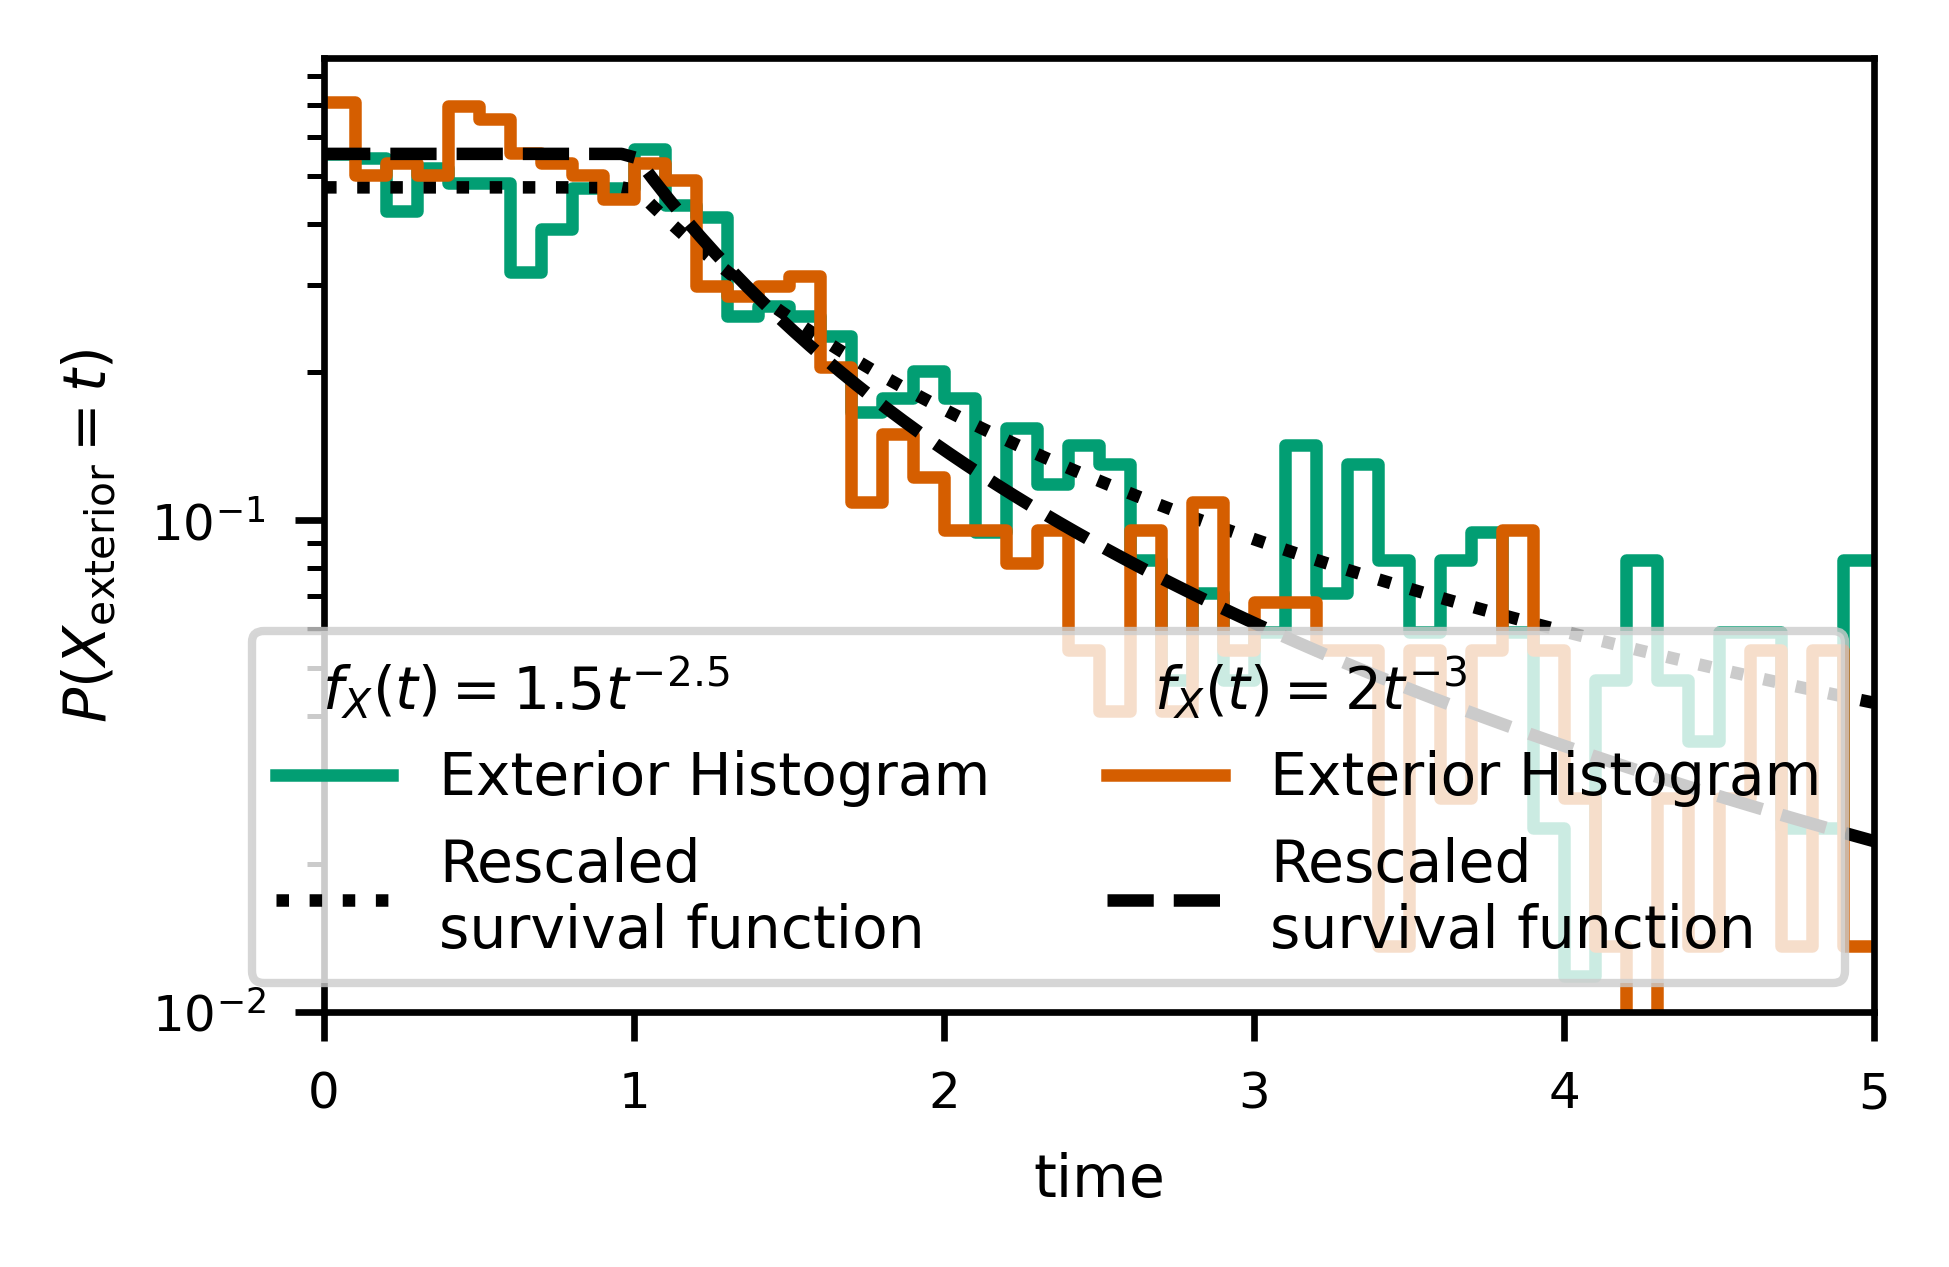

In [62]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)
legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = waits.window_size.max()

for var in wait_vars:
    exterior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] != 'interior') \
        & (waits['wait_type'] != 'full exterior'),
        ['wait_time', 'window_size']
    ]
    
    t_bins = np.linspace(0, np.max(exterior.window_size), 51)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        exterior.wait_time.values, 
        bins=t_bins
    )
    y = y/dt/len(exterior.wait_time)
    X, Y = fw.bars_given_hist(y, t_bins)
    line, = ax.plot(X, Y, c=var.color, label='Exterior Histogram')
    legend_entries[var.name].append(line)
    
    t = np.linspace(0, T, 100)
    scale = T - scipy.integrate.quad(var.cdf, 0, T)[0]
    line, = ax.plot(t, var.sf(t)/scale, c='k', ls=var.ls,
                    label='Rescaled\nsurvival function')
    legend_entries[var.name].append(line)


ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{exterior} = t)$')
ax.set_xlim([0, T])
ax.set_yscale('log')
ax.set_ylim([10**(-2), ax.get_ylim()[1]])

handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=2)
    # align bottom of legend 2% ax height above axis, filling full axis width
#     bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
#     ncol=1, mode="expand", borderaxespad=0.
# )   
# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)

### Interior Times to Likelihood

To handle the interior times, we need simply weight each observed time $t_i$ by $1/(T - t_i)$, which can easily be accomplished using `np.histogram`. (See "Theoretical Details" section below for justification).

Because we only observe times up to $t=T$, we will actually be estimating:

$$ \hat{f}_X(t) \approx P(X = t | X \leq T) = f_X(t) / F_X(T) $$

where $\hat{f}$ is our corrected histogram, and $f_X$ and $F_X$ denote the probability distribution function (PDF) and cumulative distribution functions (CDF) of the random variable $X$, respectively.

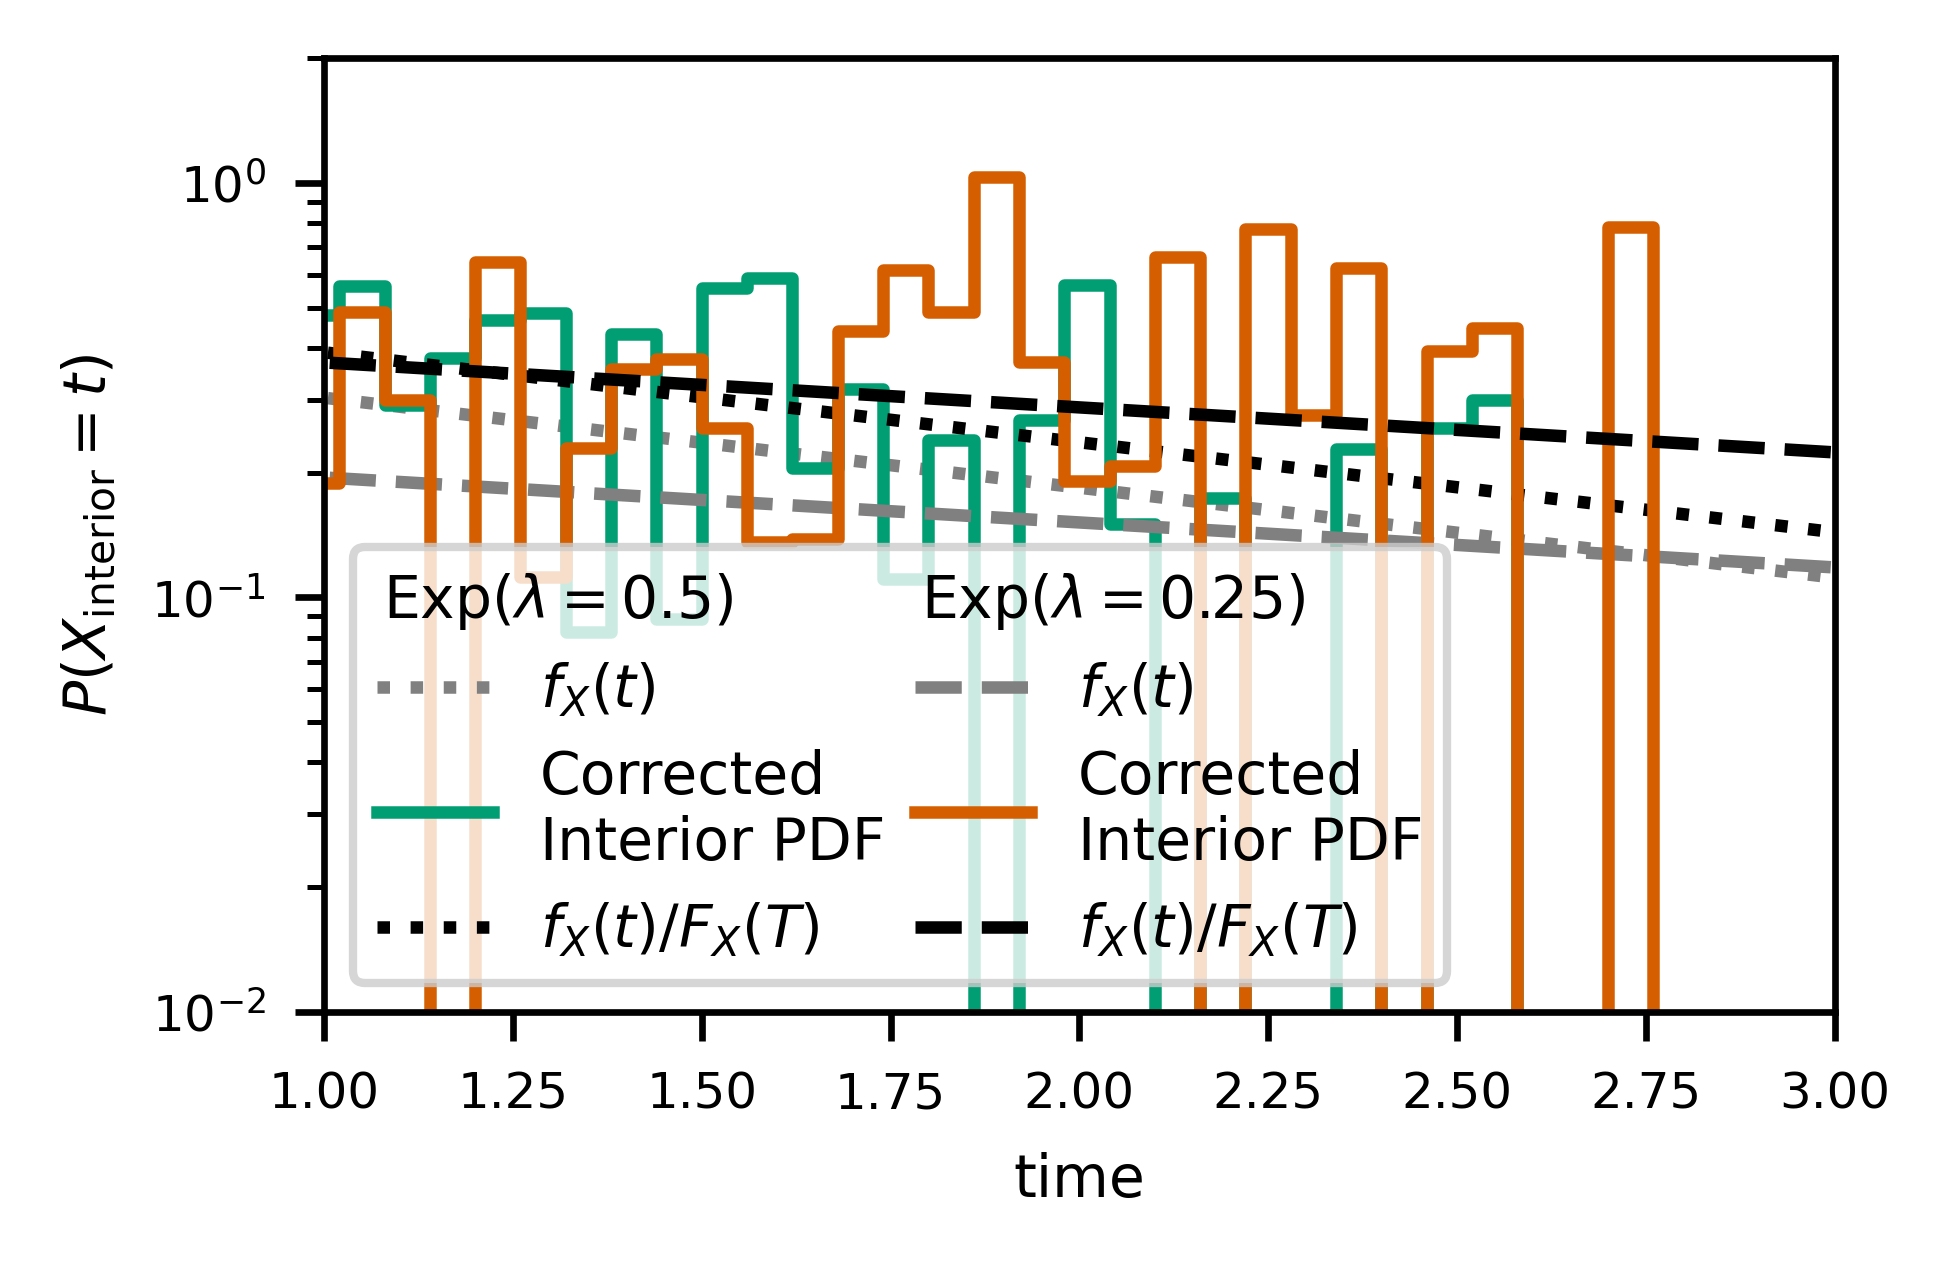

In [208]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = waits.window_size.max()
for var in wait_vars:
    line, = ax.plot(t, var.pdf(t), ls=var.ls,
                    c='0.5', label=f'$f_X(t)$')
    legend_entries[var.name].append(line)
    
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    interior['correction'] = 1/(interior.window_size - interior.wait_time)

    t_bins = np.linspace(0, T, 51)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        interior.wait_time.values, 
        weights=interior.correction / np.sum(interior.correction),
        bins=t_bins
    )
    y = y / dt
    X, Y = fw.bars_given_hist(y, t_bins)
    line, = ax.plot(X, Y, c=var.color, label='Corrected\nInterior PDF')
    legend_entries[var.name].append(line)

    t = np.linspace(0, T, 100)
    line, = ax.plot(t, var.pdf(t)/var.cdf(T), 
                    c='k', ls=var.ls, label=f'$f_X(t)/F_X(T)$')
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{interior} = t)$')
ax.set_xlim([1, T])
ax.set_ylim([10**(-2), 2])
ax.set_yscale('log')
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=2, columnspacing=0.5)

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[4].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

In order to facilitate applying the weights and normalizing correctly for performing the same correction without binning (e.g. to calculate the CDF), you can use the convenience function `fw.ecdf_windowed`:

In [566]:
print(fw.ecdf_windowed.__doc__)

Compute empirical cumulative distribution function (eCDF) from data
    taken within a finite observation interval.

    Parameters
    ----------
    times : (N,) array_like
        "Interior" waiting times.
    window_sizes : float or (N,) array_like
        The window size used. If a single value is passed, the window size is
        assumed to be constant.
    times_allowed : (M,) array_like
        Unique values that the data can take. Mostly useful for adding
        eCDF values at locations where data could or should have been observed
        but none was recorded (i.e. if a movie was taken with a given framerate
        but not all possible window lengths were observed.
    auto_pad_left : bool
        If left False, the data will not have a data value at the point where
        the eCDF equals zero. Use mean inter-data spacing to automatically
        generate an aesthetically reasonable such point.
    pad_left_at_x : bool
        Same as ``auto_pad_left``, but specify the p

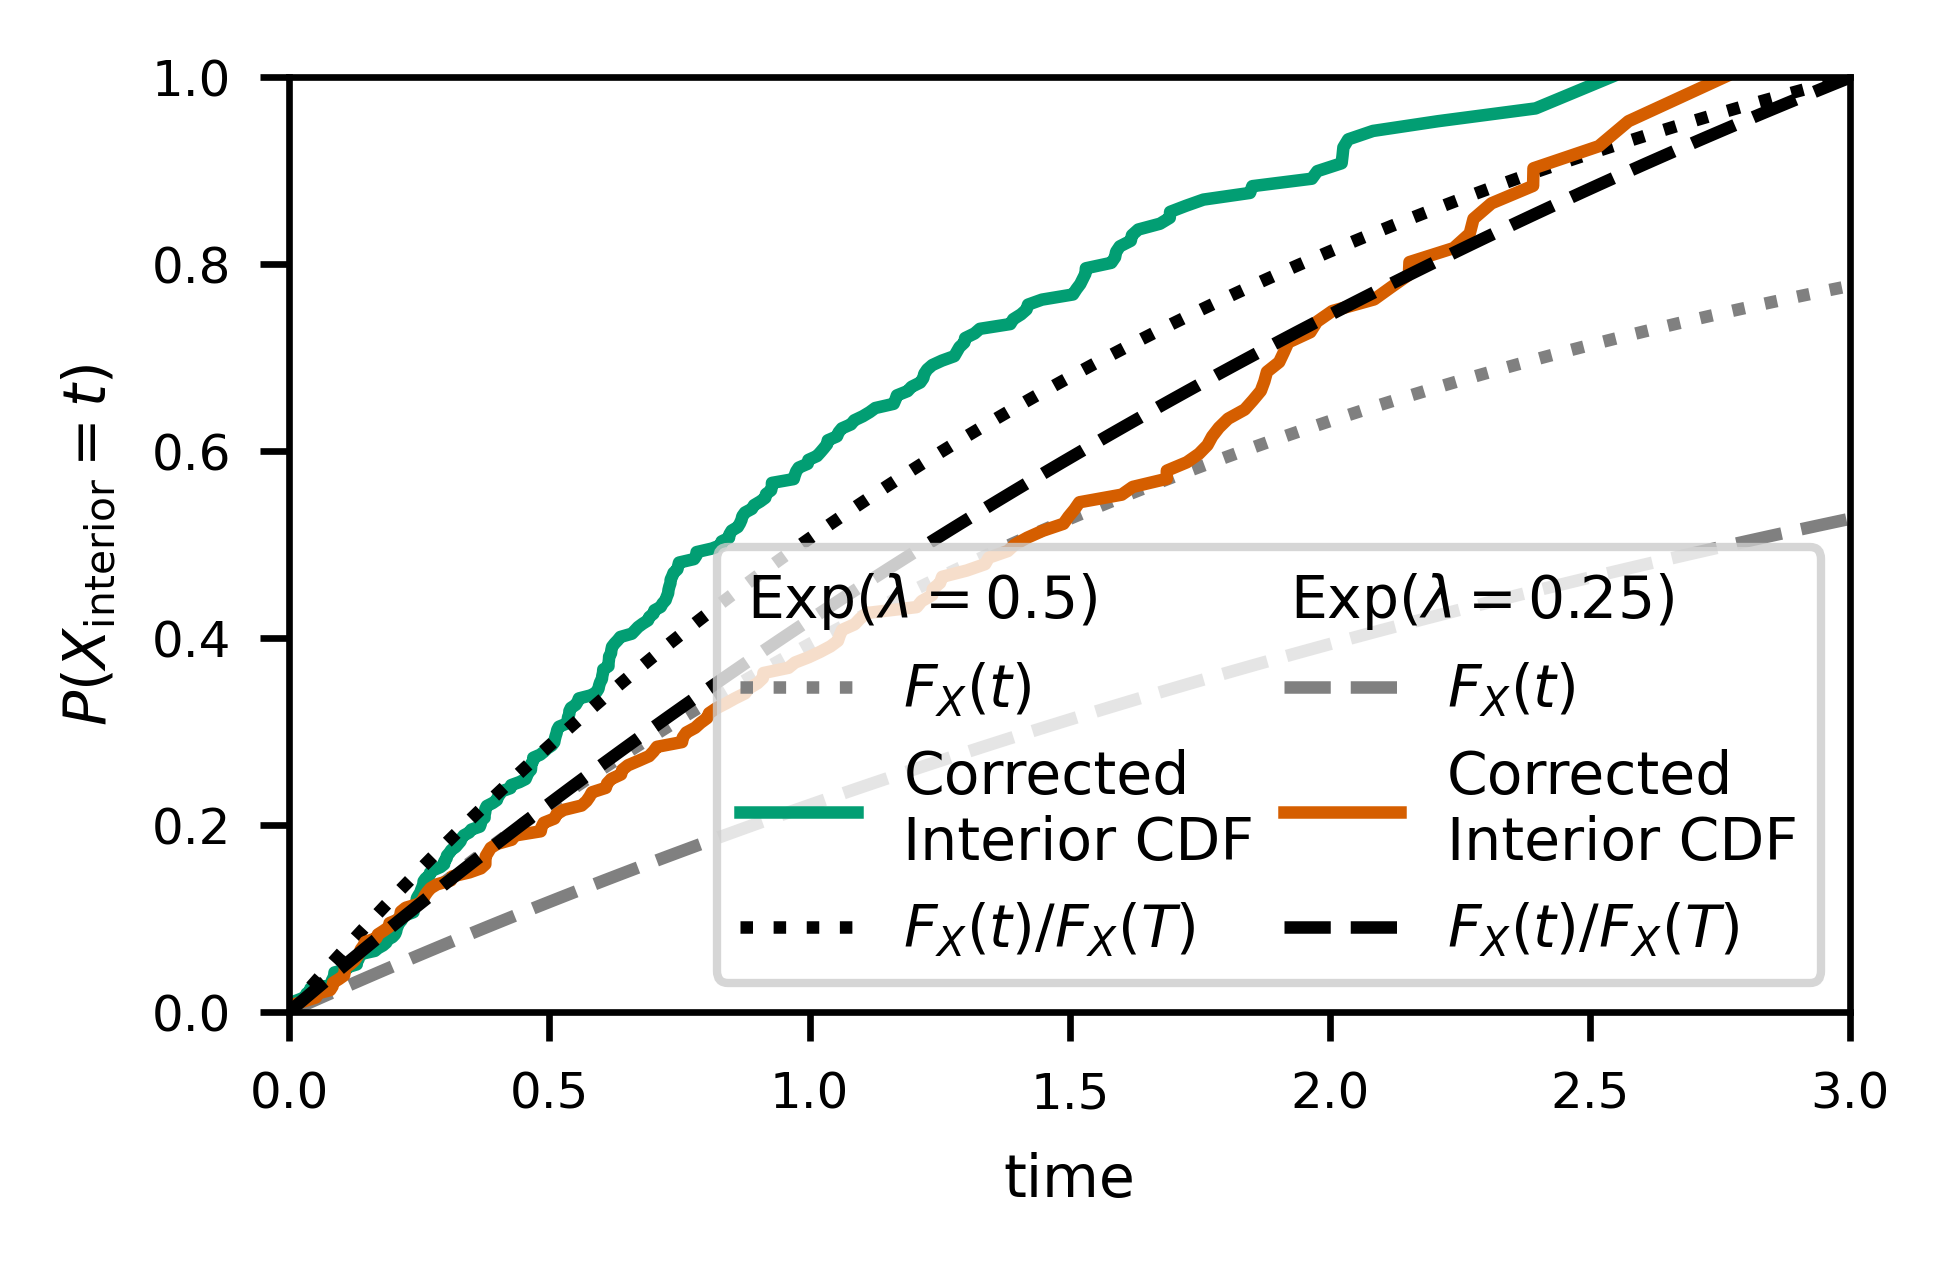

In [209]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = waits.window_size.max()
for var in wait_vars:
    line, = ax.plot(t, var.cdf(t), ls=var.ls,
                    c='0.5', label='$F_X(t)$')
    legend_entries[var.name].append(line)
    
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    x, cdf = fw.ecdf_windowed(
        interior.wait_time.values, 
        interior.window_size.values,
        pad_left_at_x=0
    )
    line, = ax.plot(x, cdf, c=var.color, label='Corrected\nInterior CDF')
    legend_entries[var.name].append(line)

    t = np.linspace(0, T, 100)
    line, = ax.plot(t, var.cdf(t)/var.cdf(T), c='k', ls=var.ls, label='$F_X(t)/F_X(T)$')
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{interior} = t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 1])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=2, columnspacing=0.5)

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[4].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

### Interior *and* Exterior times to "real" distribution

Typically, a likelihood estimate like $\hat{F}$ or $\hat{f}$ is sufficient to do parameter estimation, or at least to get a sense of the shape of the distribution. (For example, to determine the power-law or exponential rate of your system, simply plot this likelihood on a log-log or semi-log scale, respectively, and the constant factor will not affect the estimation).

On the other hand, there are times where it is important to know exactly how much contribution comes from waiting times that are greater than the observation window. In these cases, we can estimate $F_X(T)$ to get a correctly normalized estimate of the ground truth.

There are many ways to estimate this quantity (see "Theoretical Details" section for more), but the most numerically stable one I have found so far is to notice that we have two indepedent ways of computing a function that corresponds to a uniform linear scaling of $F_X(t)$:

1. Histogram of exterior times $\propto S_X(t)$. Let's call it $\hat{f}_\text{ext}(t) = S_X(t) / Z_X$. 
2. The corrected interior times CDF is given by $\hat{F}_X(t) = F_X(t) / F_X(T)$.

So we could in principle divide the height of the last histogram bar by the height of the first histogram bar (since we know $S_X(0)=1$) to get $S_X(T) = 1 - F_X(T)$, but this operation is very sensitive to our choice of histogram binning, and quite noisy.

Instead, we notice $\hat{f}_\text{ext}(t) = a + b*\hat{F}_X(t)$, where $a = 1/Z_X$ and $b = -F_X(T)/Z_X$, so we simply find the $a$ and $b$ which minimize the error 

$$ \| \hat{f}_\text{ext}(t) -  \left(a + b*\hat{F}_X(t) \right) \|_2, $$

then compute $F_X(T) \approx -b/a$.

In fact, to prevent binning artifacts from the fact that $\hat{f}_\text{ext}(t)$ is computed via a histogram, we can instead use the empirical CDF of the exterior times, and minimize:

$$ \| \hat{f}_\text{ext}(t) -  \left(t a + b*\int_0^t \hat{F}_X(t') dt' \right) \|_2. $$

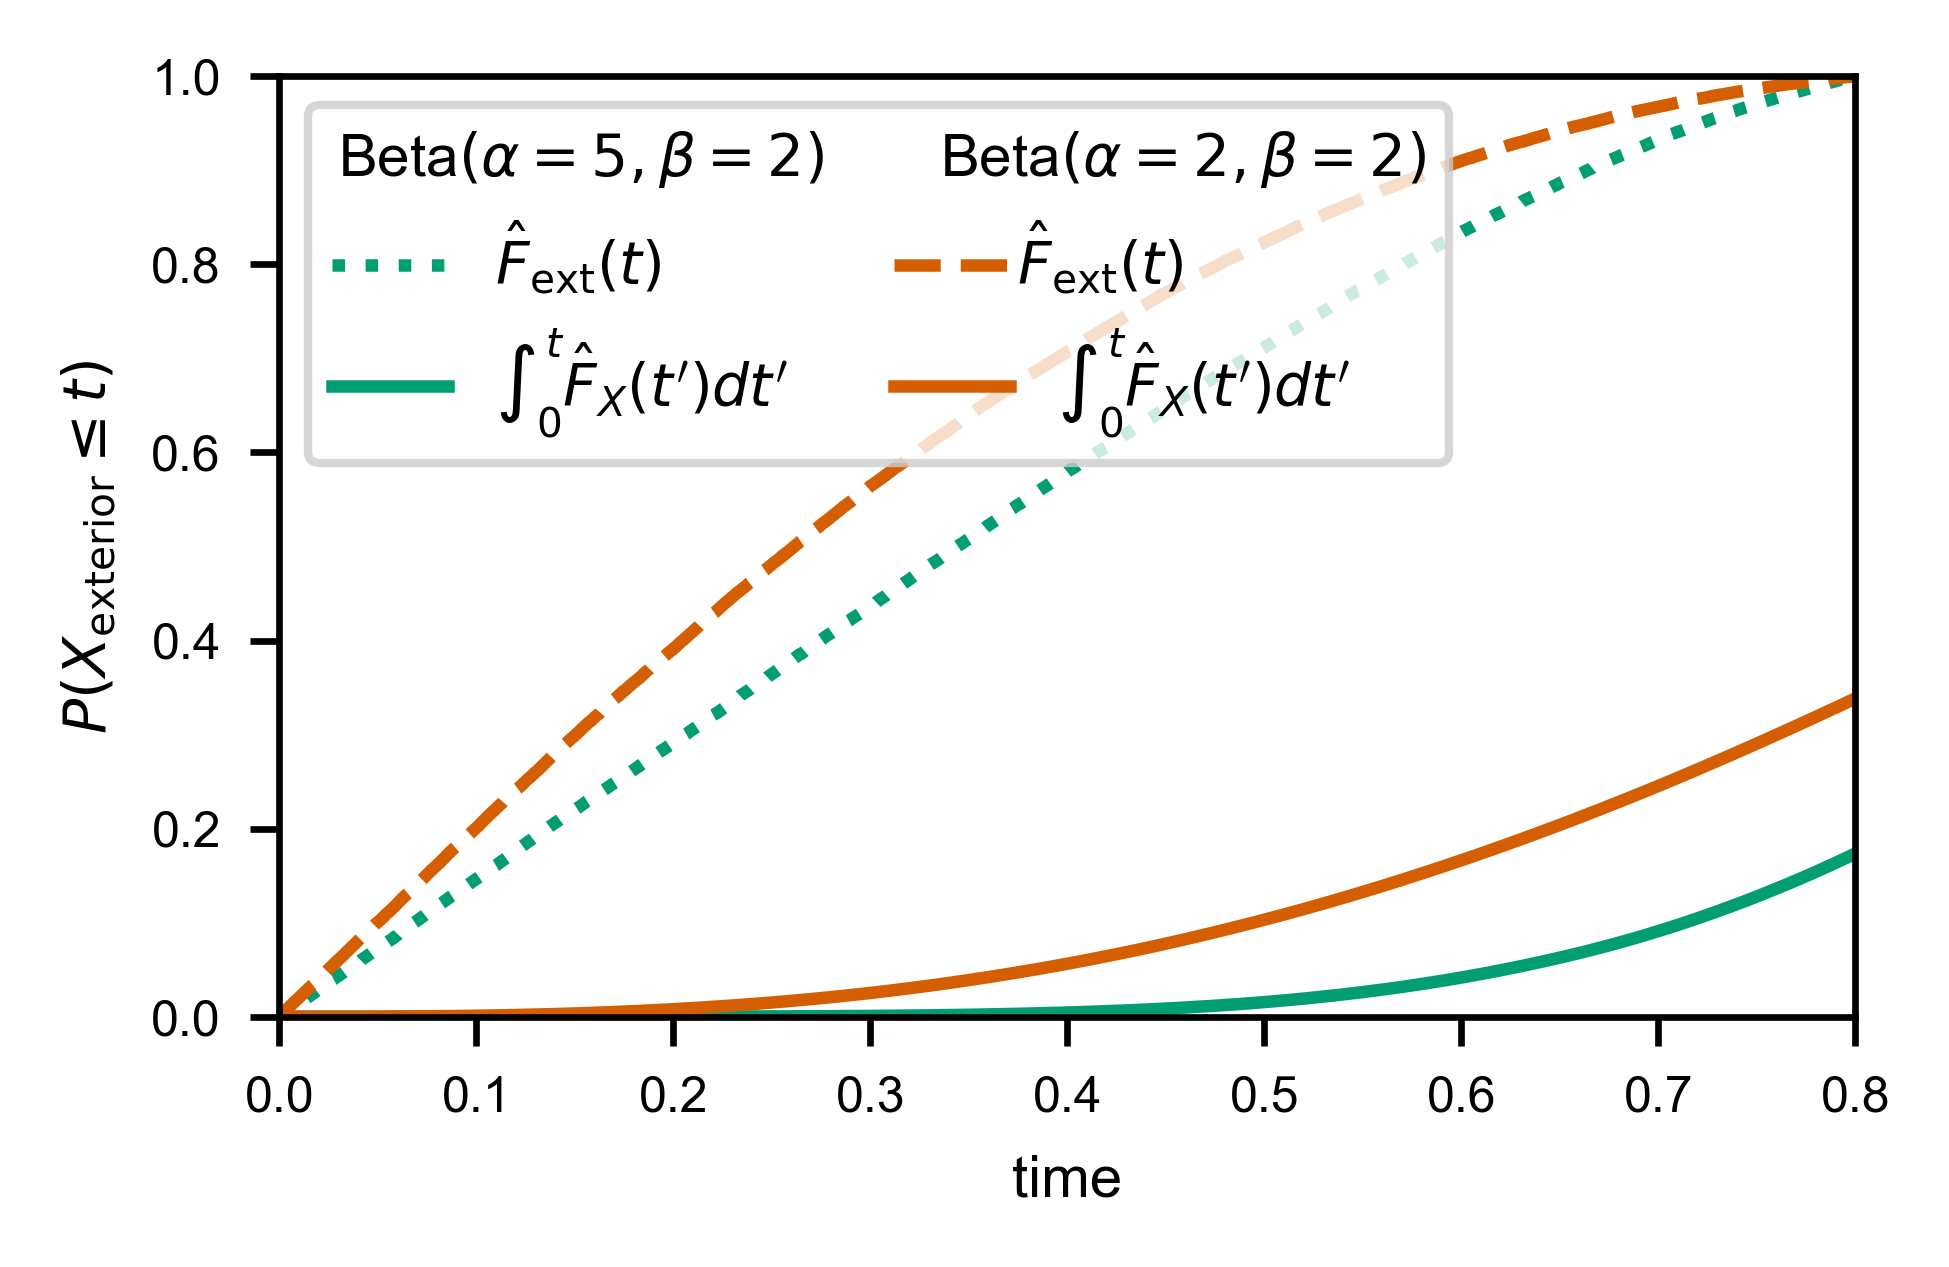

In [667]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = waits.window_size.max()
for var in wait_vars:
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    x_int, cdf_int = fw.ecdf_windowed(
        interior.wait_time.values, 
        interior.window_size.values,
        pad_left_at_x=0
    )
    # now compute integral of CDF w.r.t. 
    cdf_mid = (cdf_int[1:] + cdf_int[:-1]) / 2
    int_cdf = np.zeros_like(cdf_int)
    int_cdf[1:] = np.cumsum(cdf_mid * np.diff(x_int))
    
    exterior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] != 'interior') \
        & (waits['wait_type'] != 'full exterior'),
        ['wait_time', 'window_size']
    ]
    x_ext, cdf_ext = fw.ecdf(
        exterior.wait_time.values, 
        pad_left_at_x=0
    )
    
    line, = ax.plot(x_ext, cdf_ext, c=var.color, ls=var.ls,
                    label='$\hat{F}_\mathrm{ext}(t)$')
    legend_entries[var.name].append(line)
    
    line, = ax.plot(x_int, int_cdf, c=var.color, ls='-',
                    label="$\int_0^t \hat{F}_X(t')dt'$")
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{exterior} \leq t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 1])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, loc='upper left', ncol=2, columnspacing=0.5)

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[4].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

In [212]:
cdf_int_to_ext_cdf = {}

Now we compute the estimate:

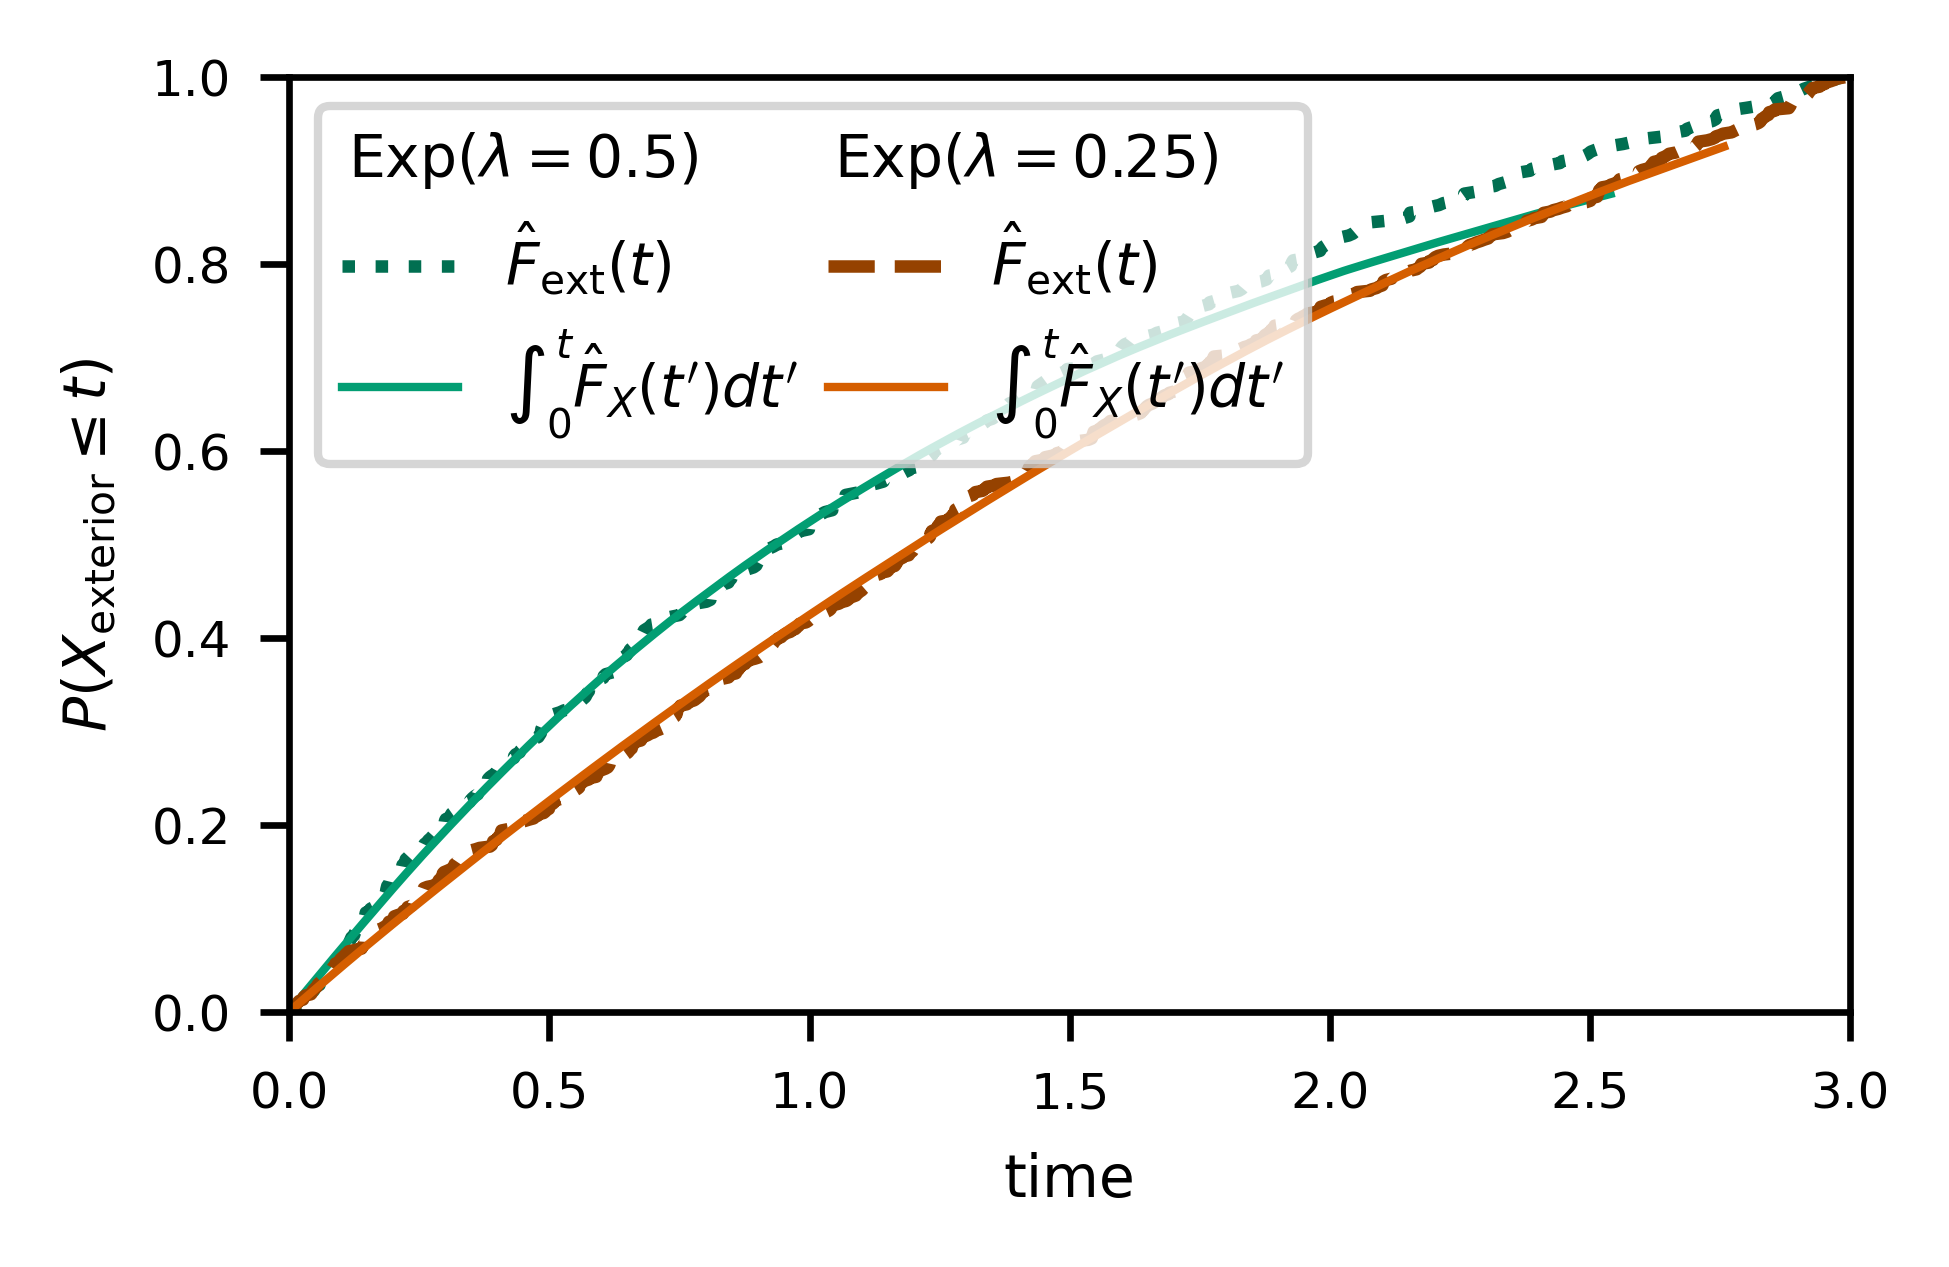

In [213]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = waits.window_size.max()
for var in wait_vars:
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    x_int, cdf_int = fw.ecdf_windowed(
        interior.wait_time.values, 
        interior.window_size.values,
        pad_left_at_x=0
    )
    # now compute integral of CDF w.r.t. 
    cdf_mid = (cdf_int[1:] + cdf_int[:-1]) / 2
    int_cdf = np.zeros_like(cdf_int)
    int_cdf[1:] = np.cumsum(cdf_mid * np.diff(x_int))
    
    exterior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] != 'interior') \
        & (waits['wait_type'] != 'full exterior'),
        ['wait_time', 'window_size']
    ]
    x_ext, cdf_ext = fw.ecdf(
        exterior.wait_time.values, 
        pad_left_at_x=0
    )
    
    t_all = np.sort(np.concatenate((x_int, x_ext)))
    resampled_int_cdf = np.interp(t_all, x_int, int_cdf)
    resampled_ext_cdf = np.interp(t_all, x_ext, cdf_ext)
    def err_f(ab, t, integrated_cdf, exterior_cdf):
        return np.linalg.norm(ab[0] * t + ab[1] * integrated_cdf - exterior_cdf)

    opt_out = scipy.optimize.minimize(
        err_f,
        x0=[1, -1],
        args=(t_all, resampled_int_cdf, resampled_ext_cdf),
        bounds=((0, np.inf), (-np.inf, 0)),
    )
    if not opt_out.success:
        raise ValueError("Unable to compute F_X(T)!")
    a, b = opt_out.x
    cdf_int_to_ext_cdf[var.name] = {'a': a, 'b': b}

    line, = ax.plot(x_ext, cdf_ext, c=0.7*np.array(var.color), ls=var.ls,
                    lw=1.5,
                    label='$\hat{F}_\mathrm{ext}(t)$')
    legend_entries[var.name].append(line)
    
    line, = ax.plot(x_int, a*x_int + b*int_cdf, c=var.color, ls='-',
                    lw=1,
                    label="$\int_0^t \hat{F}_X(t')dt'$")
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{exterior} \leq t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 1])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, loc='upper left', ncol=2, columnspacing=0.5)

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

Here's how well we are able to estimate $Z_X$ and $F_X(T)$ for this particular set of trajectories:

In [693]:
for var in wait_vars:
    a = cdf_int_to_ext_cdf[var.name]['a']
    b = cdf_int_to_ext_cdf[var.name]['b']
    T = waits.window_size.max()
    Z_X = T - scipy.integrate.quad(var.cdf, 0, T)[0]
    print(f'${1/a} \\approx {Z_X}$')
    print(f'${-b/a} \\approx {var.cdf(T)}$')

$0.6865700954866136 \approx 0.6876525714285715$
$0.6574595340157526 \approx 0.6553600000000002$
$0.492113872509153 \approx 0.4927999999999999$
$0.9139015100420814 \approx 0.896$


Now we can compute correctly normalized wait time distributions:

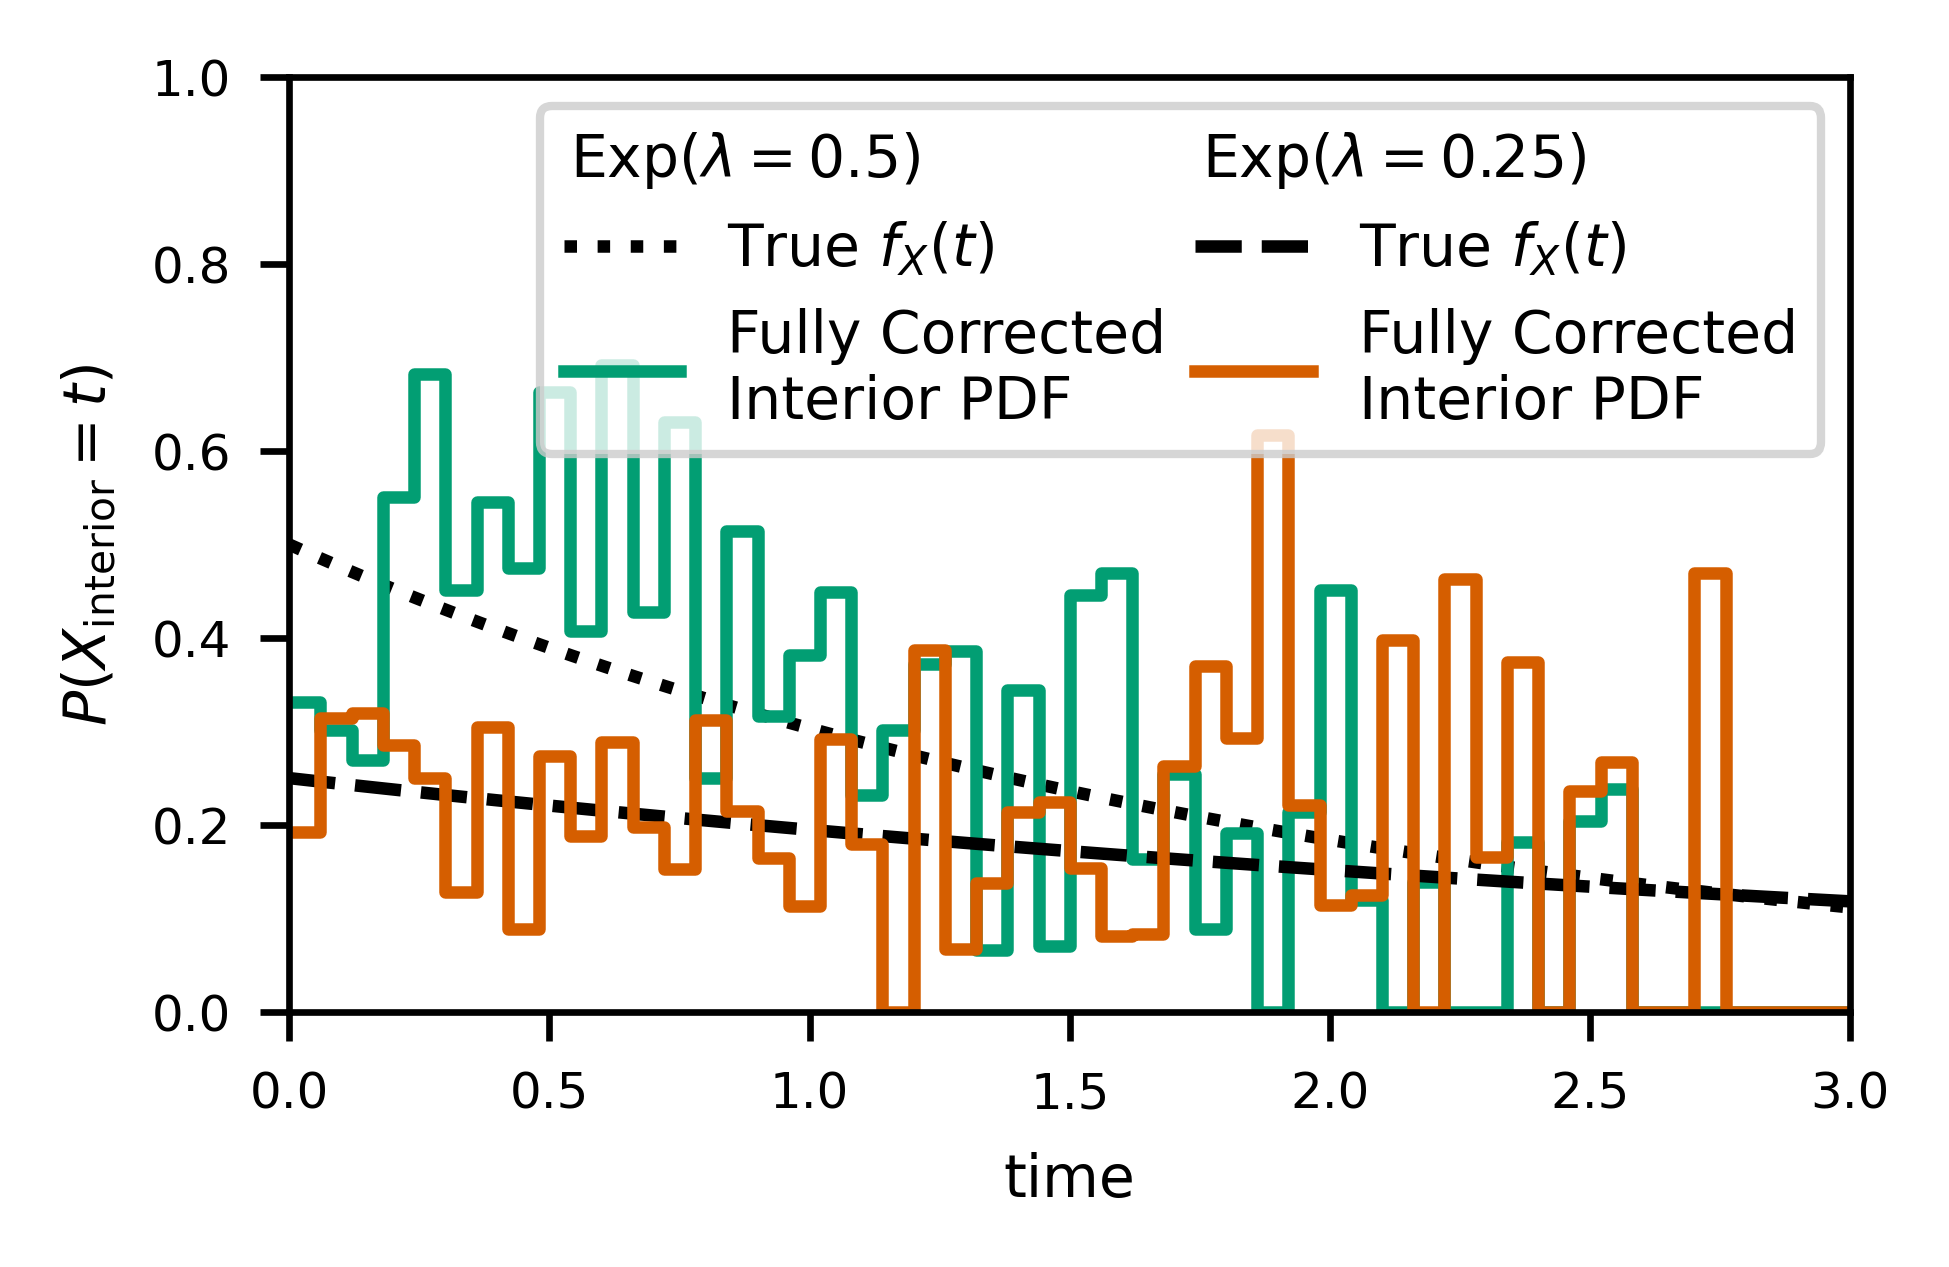

In [215]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = waits.window_size.max()
for var in wait_vars:
    line, = ax.plot(t, var.pdf(t), ls=var.ls,
                    c='k', label=f'True $f_X(t)$')
    legend_entries[var.name].append(line)
    
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    interior['correction'] = 1/(interior.window_size - interior.wait_time)

    t_bins = np.linspace(0, T, 51)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        interior.wait_time.values, 
        weights=interior.correction / np.sum(interior.correction),
        bins=t_bins
    )
    y = y / dt
    X, Y = fw.bars_given_hist(y, t_bins)
    a = cdf_int_to_ext_cdf[var.name]['a']
    b = cdf_int_to_ext_cdf[var.name]['b']
    line, = ax.plot(X, Y*(-b/a), c=var.color, label='Fully Corrected\nInterior PDF')
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{interior} = t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 1])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=2, columnspacing=0.5)

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

### Heterogeneous Window Size

For arbitrary collections of data measured with potentially different window sizes, we simply need to correct for the fraction of trajectories in which each time could have been observed at all.


In [712]:
# generate same distribution, but with three different window sizes
het_trajs = [
    fw.ab_window(
        [var.rvs for var in wait_vars],
        window_size=window, 
        offset=-100*np.sum([var.mean() for var in wait_vars]),
        num_replicates=10_000,  
        states=[var.name for var in wait_vars]
    )
    for window in np.array([1/2, 1, 2])*example_window
]
import pandas as pd
het_trajs = pd.concat(het_trajs, ignore_index=True)
multi_T_waits = het_trajs \
    .groupby(['window_end', 'replicate']) \
    .apply(fw.traj_to_waits)
del multi_T_waits['replicate']
del multi_T_waits['window_end']
multi_T_waits.head()

Notice the only difference is that the weights also include the fraction of **trajectories** that can have even observed the given wait time in the first place.

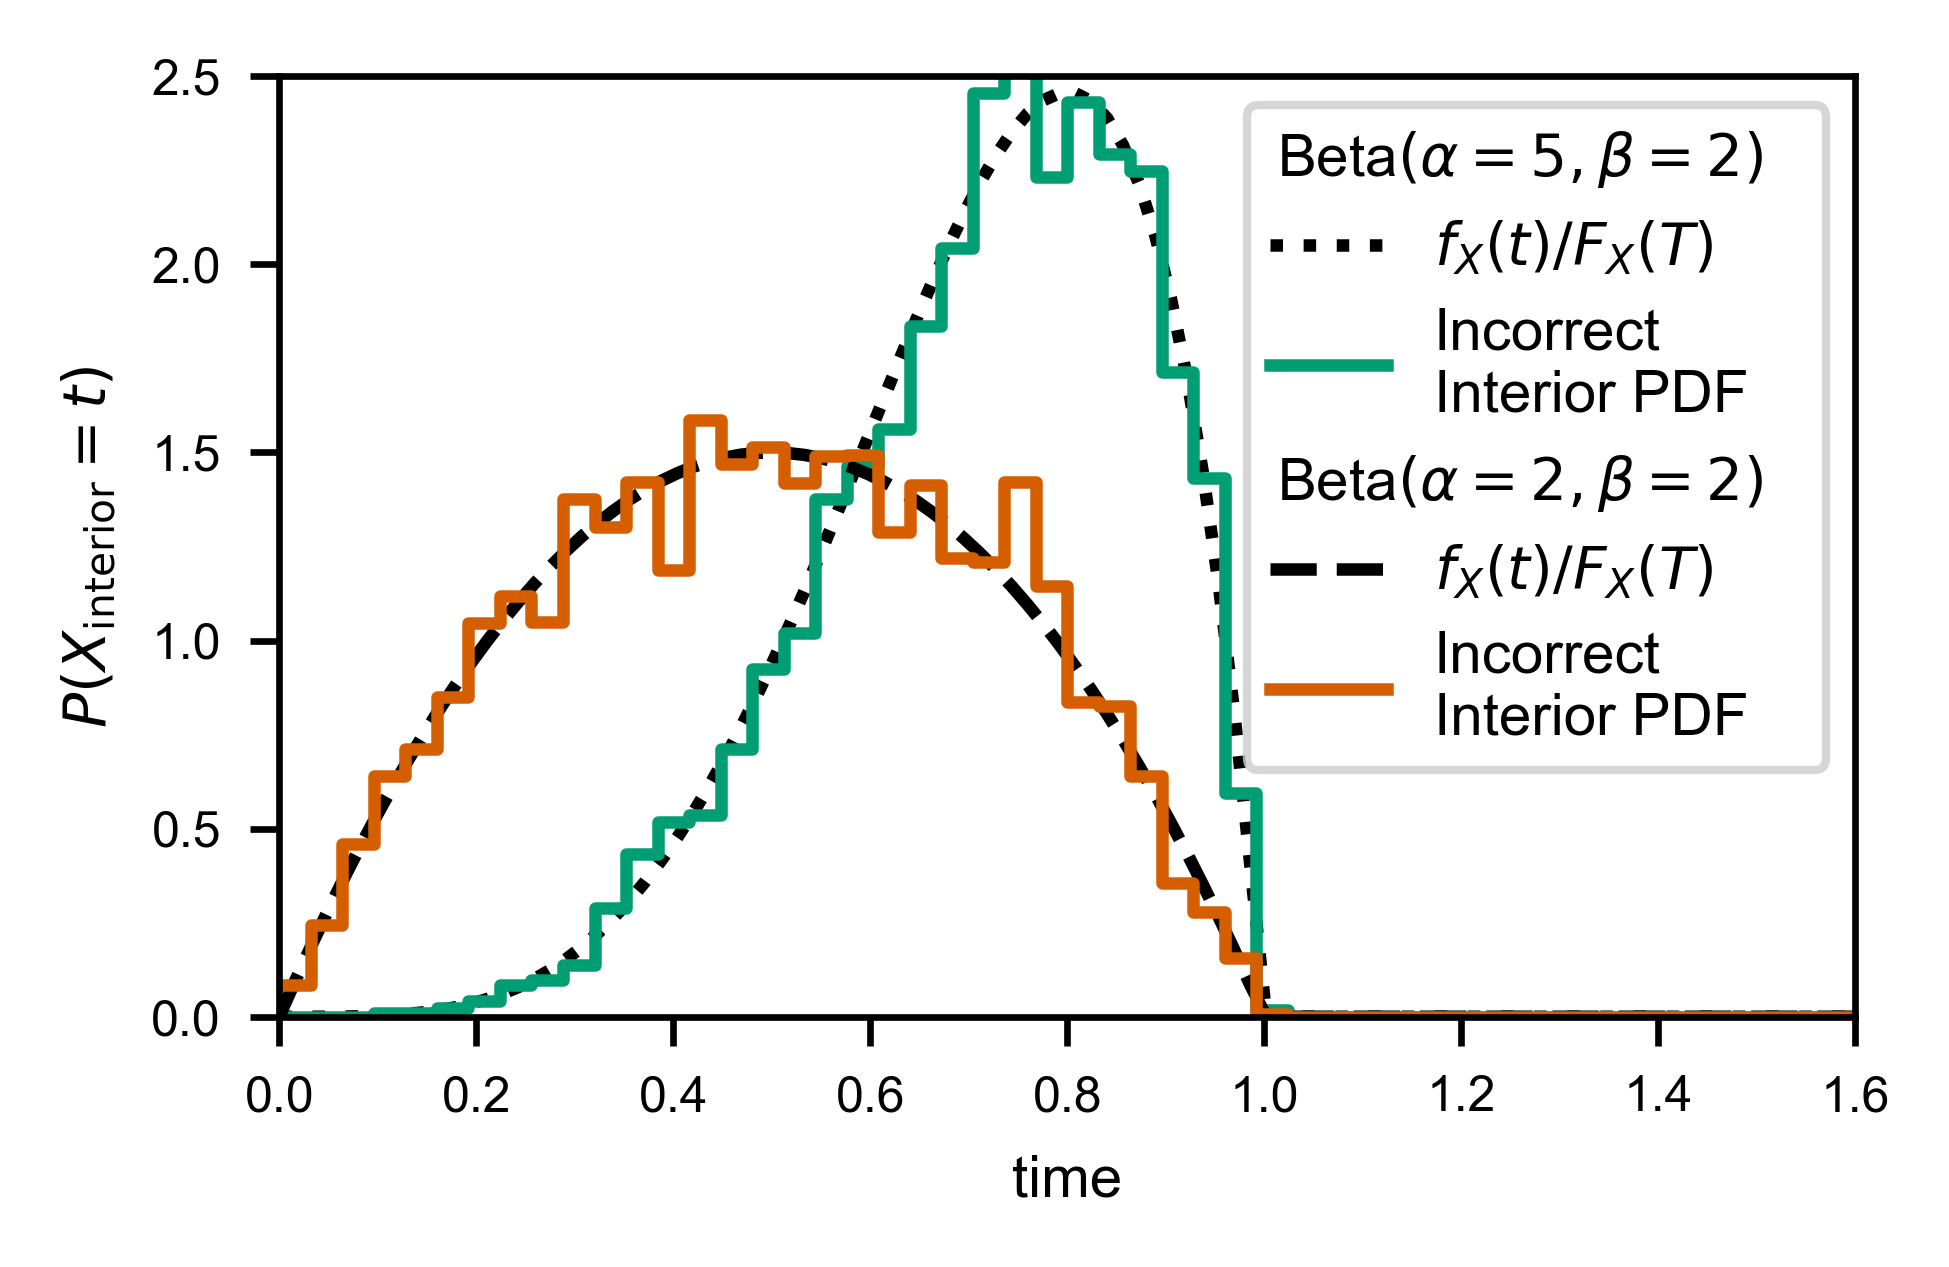

In [737]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = multi_T_waits.window_size.max()
# get fraction of windows that are at *least* of each width
window_sizes, window_cumulant = fw.ecdf(
    multi_T_waits.groupby(['window_end', 'replicate'])['window_size'].first().values, 
    pad_left_at_x=0
)
window_frac_at_least = 1 - window_cumulant
for var in wait_vars:
    t = np.linspace(0, T, 100)

    line, = ax.plot(t, var.pdf(t)/var.cdf(T), ls=var.ls,
                    c='k', label=f'$f_X(t)/F_X(T)$')
    legend_entries[var.name].append(line)
    
    interior = multi_T_waits.loc[
        (multi_T_waits['state'] == var.name) & (multi_T_waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    # for each observed time, we can get number of windows in which it can have been observed
    window_i = np.searchsorted(window_sizes, interior.wait_time) - 1
    frac_trajs_observable = window_frac_at_least[window_i]
    interior['correction'] = 1 / frac_trajs_observable / (interior.window_size - interior.wait_time)
       
    t_bins = np.linspace(0, T, 51)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        interior.wait_time.values, 
        weights=interior.correction / np.sum(interior.correction),
        bins=t_bins
    )
    y = y / dt
    X, Y = fw.bars_given_hist(y, t_bins)
    line, = ax.plot(X, Y, c=var.color, label='Incorrect\nInterior PDF')
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{interior} = t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 2.5])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=1, loc='upper right')

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for i in [0, 3]:
        hpack = vpack.get_children()[i]
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

Here's what it looks like if we don't do the extra correction. Notice the "jumps" at each window size, due to the missing correction factor:

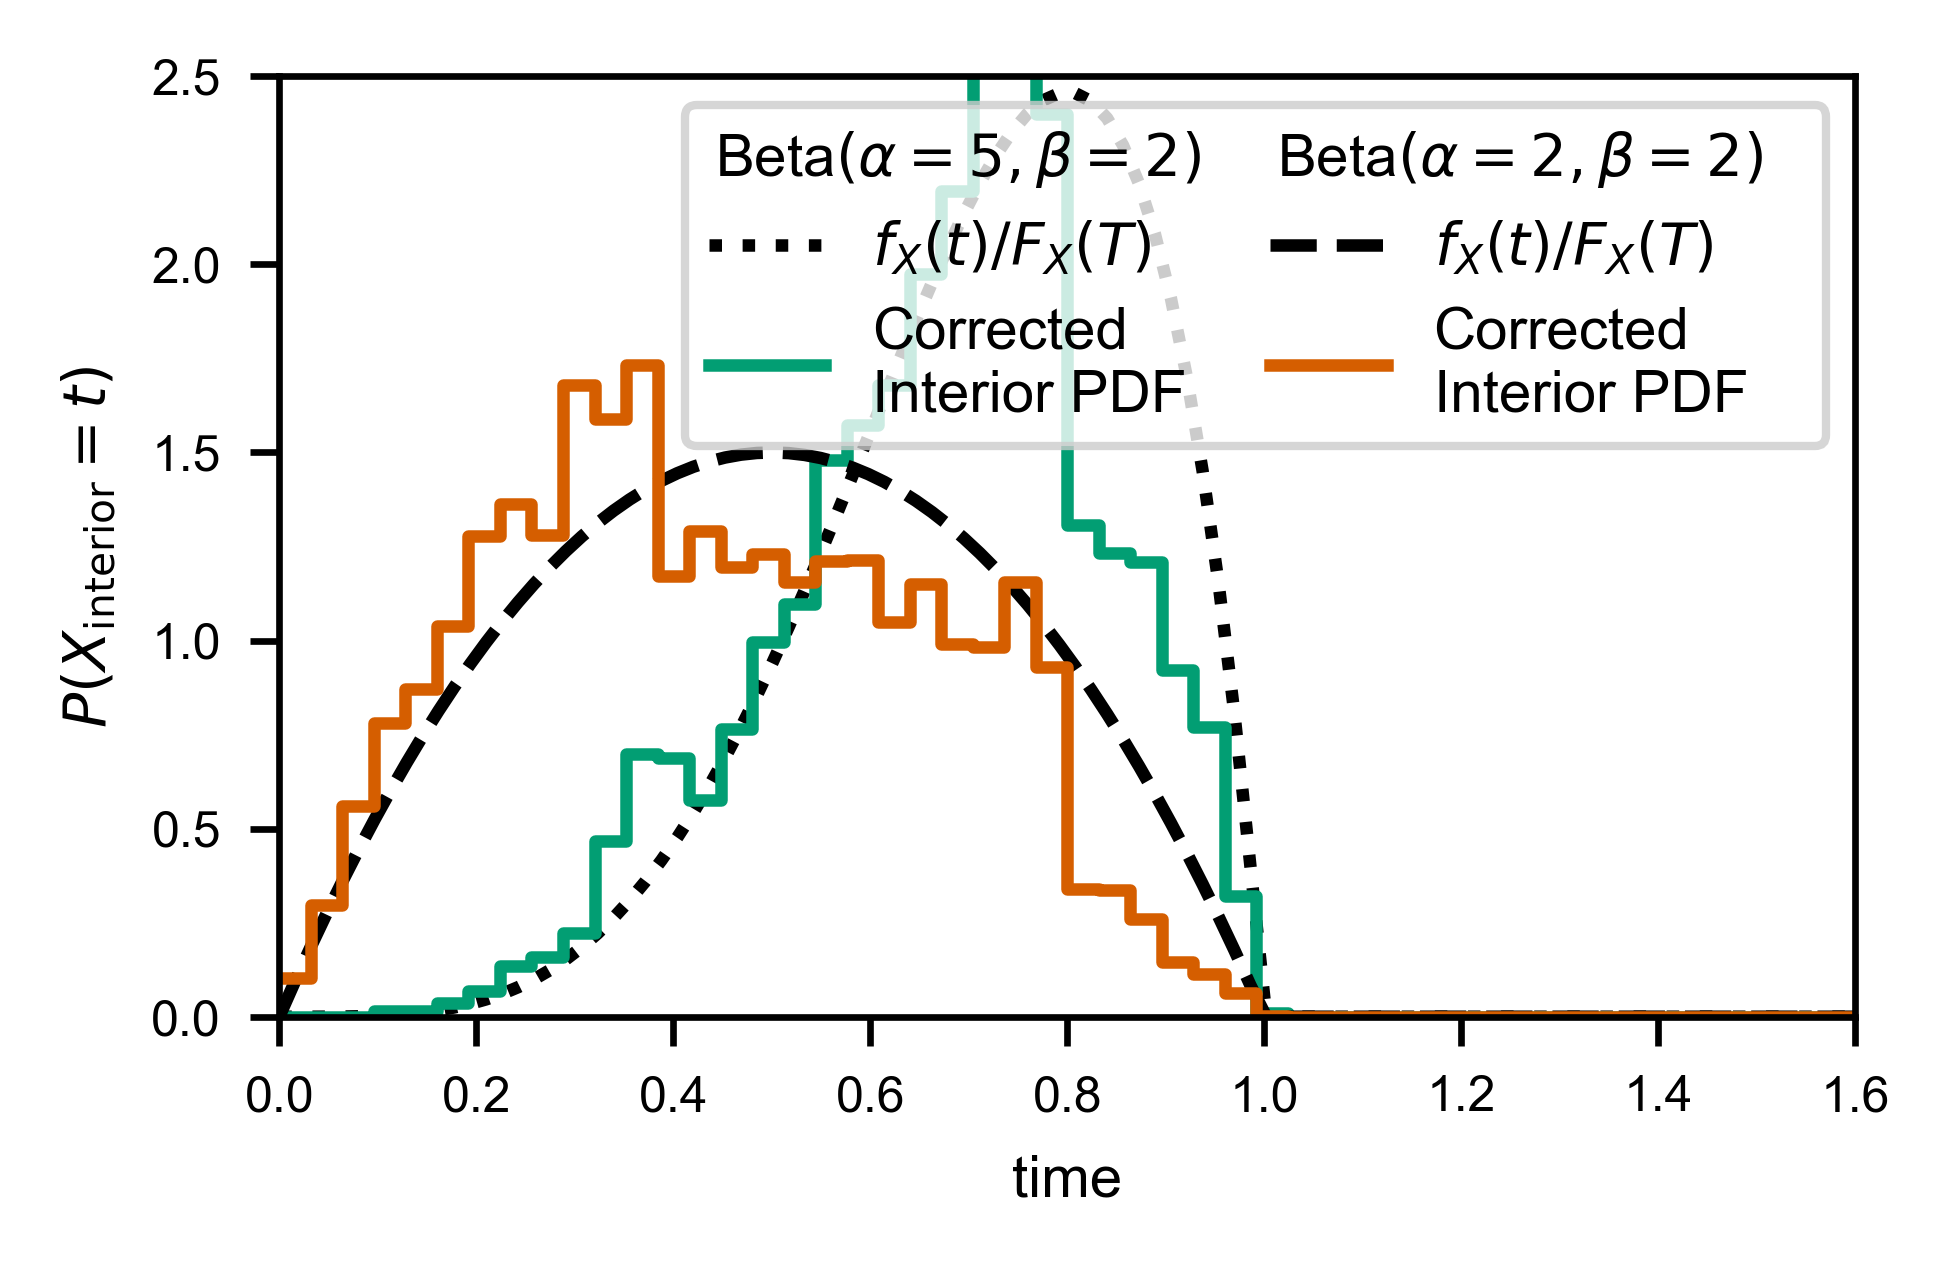

In [760]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = multi_T_waits.window_size.max()
for var in wait_vars:
    t = np.linspace(0, T, 100)

    line, = ax.plot(t, var.pdf(t)/var.cdf(T), ls=var.ls,
                    c='k', label=f'$f_X(t)/F_X(T)$')
    legend_entries[var.name].append(line)
    
    interior = multi_T_waits.loc[
        (multi_T_waits['state'] == var.name) & (multi_T_waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    interior['correction'] = 1/(interior.window_size - interior.wait_time)
       
    t_bins = np.linspace(0, T, 51)
    dt = np.diff(t_bins)
    y, t_bins = np.histogram(
        interior.wait_time.values, 
        weights=interior.correction / np.sum(interior.correction),
        bins=t_bins
    )
    y = y / dt
    X, Y = fw.bars_given_hist(y, t_bins)
    line, = ax.plot(X, Y*(-b/a), c=var.color, label='Corrected\nInterior PDF')
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{interior} = t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 2.5])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=2, columnspacing=0.5)

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

As you might expect, ``fw.ecdf_windowed`` takes a ``window_cumulant`` argument, to allow you to specify how many of each window type there are (since it's not possible to infer that information purely from a list of interior times and corresponding window sizes).

If your window size is drawn randomly, then each window size is effectively unique, and the default value of ``window_cumulant=None`` will do the appropriate computation for you.

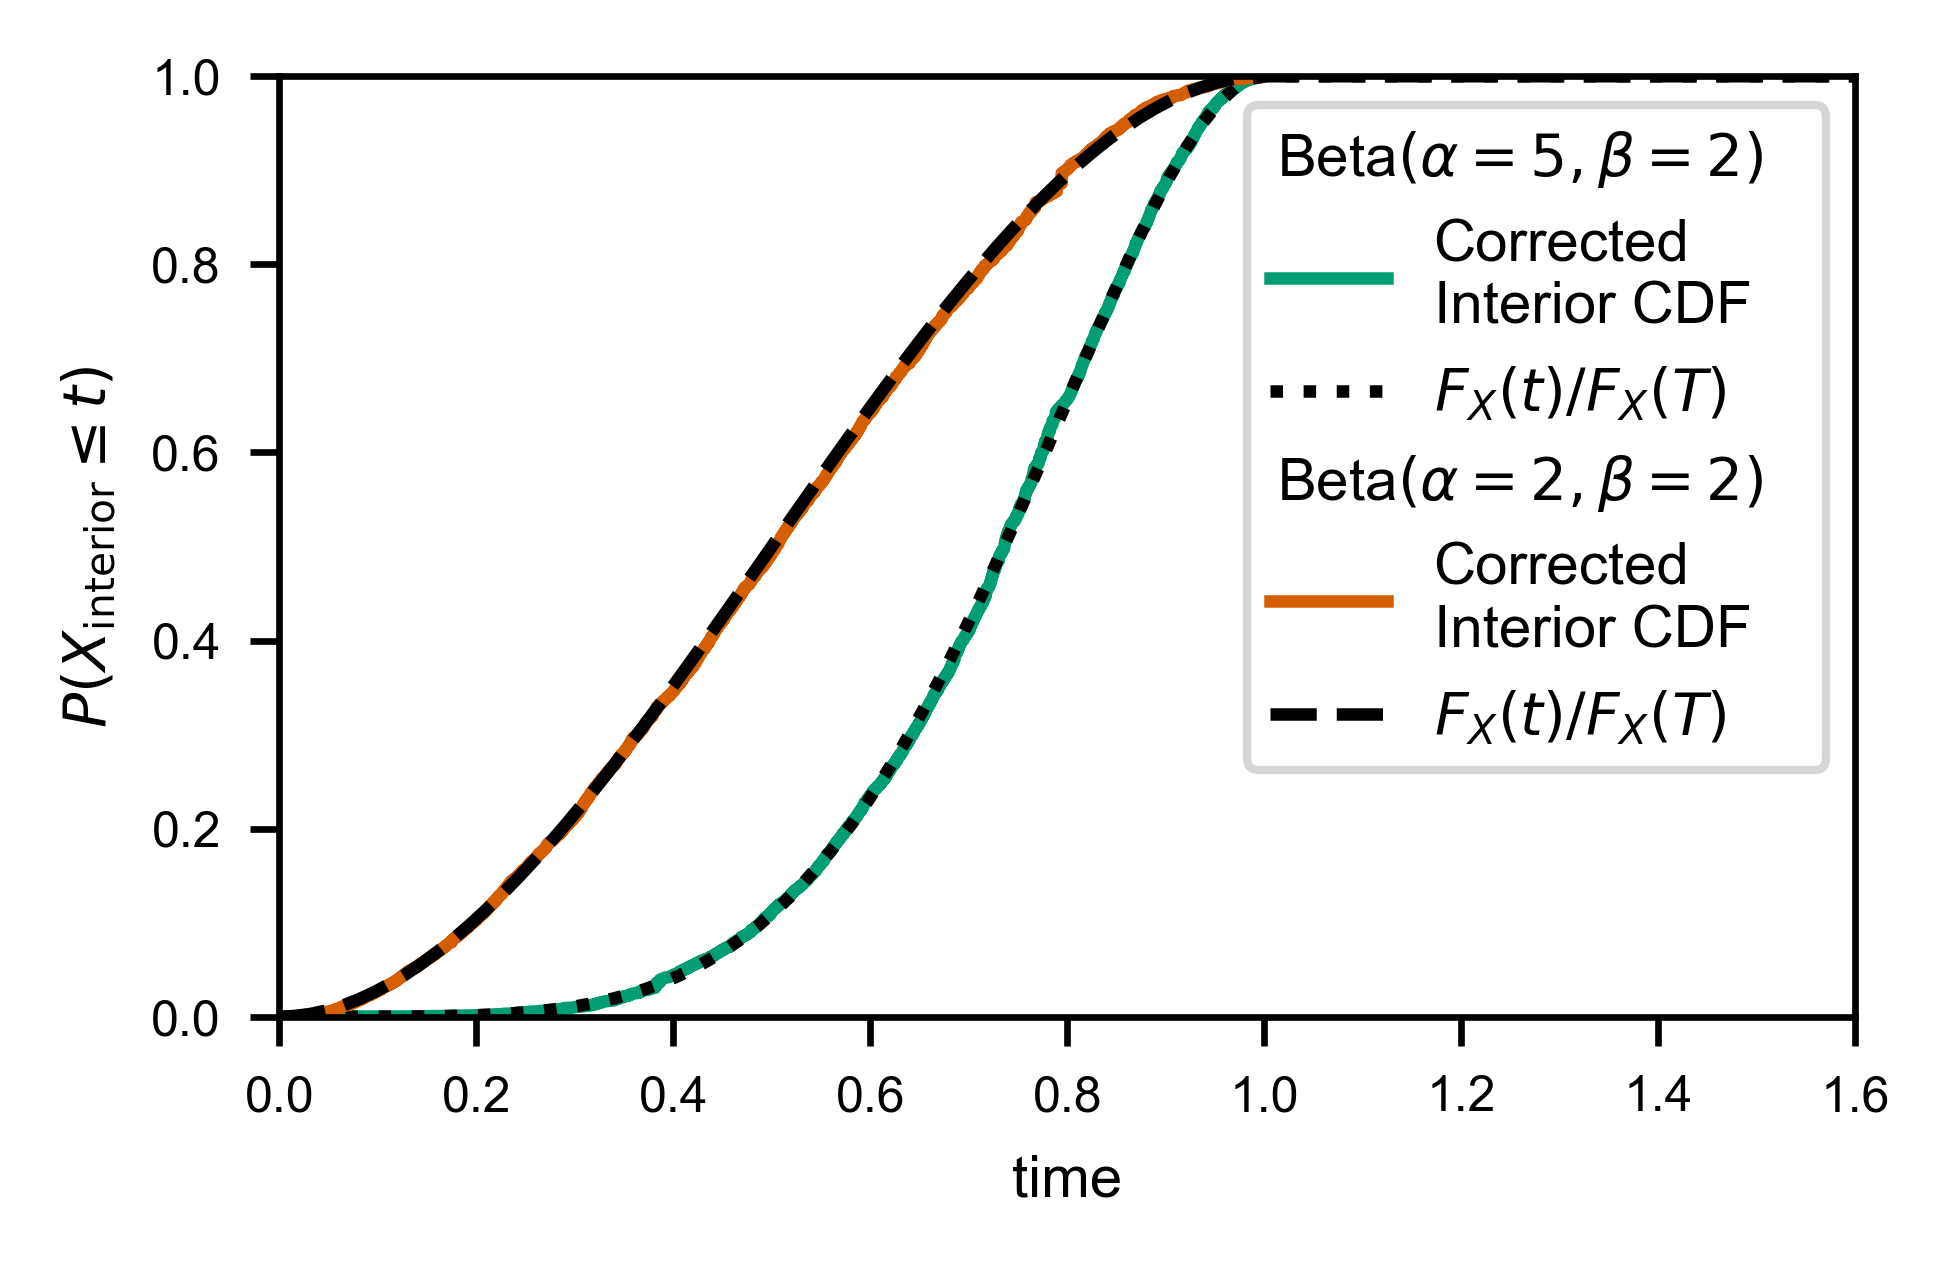

In [759]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = multi_T_waits.window_size.max()
window_sizes, window_cumulant = fw.ecdf(
    multi_T_waits.groupby(['window_end', 'replicate'])['window_size'].first().values, 
    pad_left_at_x=0
)
for var in wait_vars:
    t = np.linspace(0, T, 100)
    
    interior = multi_T_waits.loc[
        (multi_T_waits['state'] == var.name) & (multi_T_waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
       
    x, cdf, weights = fw.ecdf_windowed(
        interior.wait_time, interior.window_size,
        pad_left_at_x=0, window_cumulant=window_cumulant
    )
    line, = ax.plot(x, cdf, c=var.color, label='Corrected\nInterior CDF')
    legend_entries[var.name].append(line)
    
    line, = ax.plot(t, var.cdf(t)/var.cdf(T), ls=var.ls,
                    c='k', label=f'$F_X(t)/F_X(T)$')
    legend_entries[var.name].append(line)

    
ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{interior} \leq t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 1])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=1, loc='upper right')

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for i in [0, 3]:
        hpack = vpack.get_children()[i]
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

### A Caveat for Discrete Movies


While we would ideally have an exact measurement of when transitions between
`A` and `B` states happen, it is more often the case that we have a "movie" of
sorts, where we measure the state of the system at a fixed set of *frames*.

This only provides us with upper and lower bounds for the actual waiting time
that we're trying to observe. For example, consider the trajectory depicted
below.

        A A A A A B B B B B B B A A A A B
        | - - - | - - - | - - - | - - - |  ...
        |                               |
    t = 0s      1s      2s      3s      4s

This trajectory, when measured at the discrete times shown, would look like

```python
pd.Series({0: 'A', 1: 'A', 2: 'B', 3: 'A', 4: 'B'}).head()
    0    A
    1    A
    2    B
    3    A
    4    B
    dtype: object
```

Naively, if you only had this movie in front of you with no knowledge of the
actual underlying state change times, it might seem to suggest that there was an
exterior-censored "A" of length 2, one each interior censored times of length 1,
and one exterior-censored "B" time of length 1. However, by looking at the true
trajctory above, we see that the first "A" wait was much shorter than 2s, and
the first "B" wait was much longer than 1s, whereas the last "A" wait just
happened to match up with our prediction of 1s.

Because our normalization factor depends non-linearly on the observed waiting
time, one might guess that simply using the "naive" times might cause bias. We
will show that this is the case by generating some artificial movies ourselves.

### Generating Discrete Trajectories (Movies)

`multi_locus_analysis.finite_window` includes a convenience method for
generating "movie frames" from the output of the `AB_window*` functions:

In [763]:
print(fw.state_changes_to_movie_frames.__doc__)



    Convert state changes into discrete-time observations of state.

    Takes a Series of state change times into a Series containing
    observations at the times requested. The times become the index.

    Parameters
    ----------
    times : (N,) array_like
        times at which to "measure" what state we're in to make the new
        trajectories.
    traj : pd.DataFrame
        should have `state_col` and `start_times_col` columns. the values of
        `state_col` will be copied over verbatim.
    state_col : string
        name of column containing the state being transitioned out of for each
        measurement in `traj`.
    start_times_col : string
        name of column containing times at which `traj` changed state
    end_times_col : (optional) string
        by default, the function assumes that times after the last start time
        are in the same state. if passed, this column is used to determine at
        what time the last state "finished". times after this wil

This function has an alias for convenience: 
`multi_locus_analysis.finite_window.traj_to_movie`.

In [821]:
T = trajs.window_end.max()
movie_frame_t = np.linspace(0, T, 21)
movies = trajs.groupby('replicate').apply(
    fw.traj_to_movie,
    times=movie_frame_t
)
movies.head()


t,0.00,0.04,0.08,0.12,0.16,0.20,0.24,0.28,0.32,0.36,...,0.44,0.48,0.52,0.56,0.60,0.64,0.68,0.72,0.76,0.80
replicate,,,,,,,,,,,,,,,,,,,,,
0,"Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)",...,"Beta(2, 2)","Beta(2, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)"
1,"Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)",...,"Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(2, 2)","Beta(2, 2)"
2,"Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)",...,"Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)"
3,"Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)",...,"Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)"
4,"Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(5, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)",...,"Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)","Beta(2, 2)"


We can get a long-form DataFrame by simply doing

In [822]:
movies = movies.T.unstack()
movies.name = 'state' # name resulting column from unstack
movies.head()


replicate  t   
0          0.00    Beta(2, 2)
           0.04    Beta(2, 2)
           0.08    Beta(2, 2)
           0.12    Beta(2, 2)
           0.16    Beta(2, 2)
Name: state, dtype: object

For this type of discrete data, there is a separate function for computing the waiting times DataFrame:

In [776]:
print(fw.discrete_trajectory_to_wait_times.__doc__)

Converts a discrete trajectory to a dataframe containing each wait time,
    with its start, end, rank order, and the state it's leaving.

    Discrete here means that the state of the system was observed at finite
    time points (on a lattice in time), as opposed to a system where the exact
    times of transitions between states are known.

    Because a discrete trajectory only bounds the wait times, and does not
    determine their exact lengths (as a continuous trajectory might),
    additional columns are included that explictly bound the wait times, in
    addition to returning the "natural" estimate.

    Parameters
    ----------
    data : pd.DataFrame
        should have at least states_column and time_column columns, and already
        be groupby'd so that there's only one "trajectory" within the
        DataFrame. One row should correspond to an observation at a particular
        time point.
    time_column : string
        the name of the column containing the time of 

Which also has a convenient alias: `multi_locus_analysis.finite_window.movie_to_waits`:

In [825]:
discrete_waits = pd.DataFrame(movies).reset_index().groupby('replicate').apply(fw.movie_to_waits)
discrete_waits.head()

start_time  end_time  wait_time       state  min_waits  \
replicate rank_order                                                           
0         0                 0.00      0.52       0.52  Beta(2, 2)       0.48   
          1                 0.52      0.80       0.28  Beta(5, 2)       0.28   
1         0                 0.00      0.24       0.24  Beta(5, 2)       0.20   
          1                 0.24      0.64       0.40  Beta(2, 2)       0.36   
          2                 0.64      0.76       0.12  Beta(5, 2)       0.08   

                      max_waits       wait_type  window_size  
replicate rank_order                                          
0         0                0.52   left exterior          0.8  
          1                0.32  right exterior          0.8  
1         0                0.24   left exterior          0.8  
          1                0.44        interior          0.8  
          2                0.16        interior          0.8

As described above, notice the difference between the measured "wait times" from the discrete movie and the "real" wait times from the original trajectories:

In [780]:
waits.head()

state  start_time  end_time  window_start  \
replicate rank_order                                                   
0         0           Beta(5, 2)    0.000000  0.500970             0   
          1           Beta(2, 2)    0.500970  0.800000             0   
1         0           Beta(2, 2)    0.000000  0.213959             0   
          1           Beta(5, 2)    0.213959  0.600257             0   
          2           Beta(2, 2)    0.600257  0.758874             0   

                      window_end  wait_time  window_size       wait_type  
replicate rank_order                                                      
0         0                  0.8   0.500970          0.8   left exterior  
          1                  0.8   0.299030          0.8  right exterior  
1         0                  0.8   0.213959          0.8   left exterior  
          1                  0.8   0.386298          0.8        interior  
          2                  0.8   0.158617          0.8        interior

Looks like it works as well as one could hope....

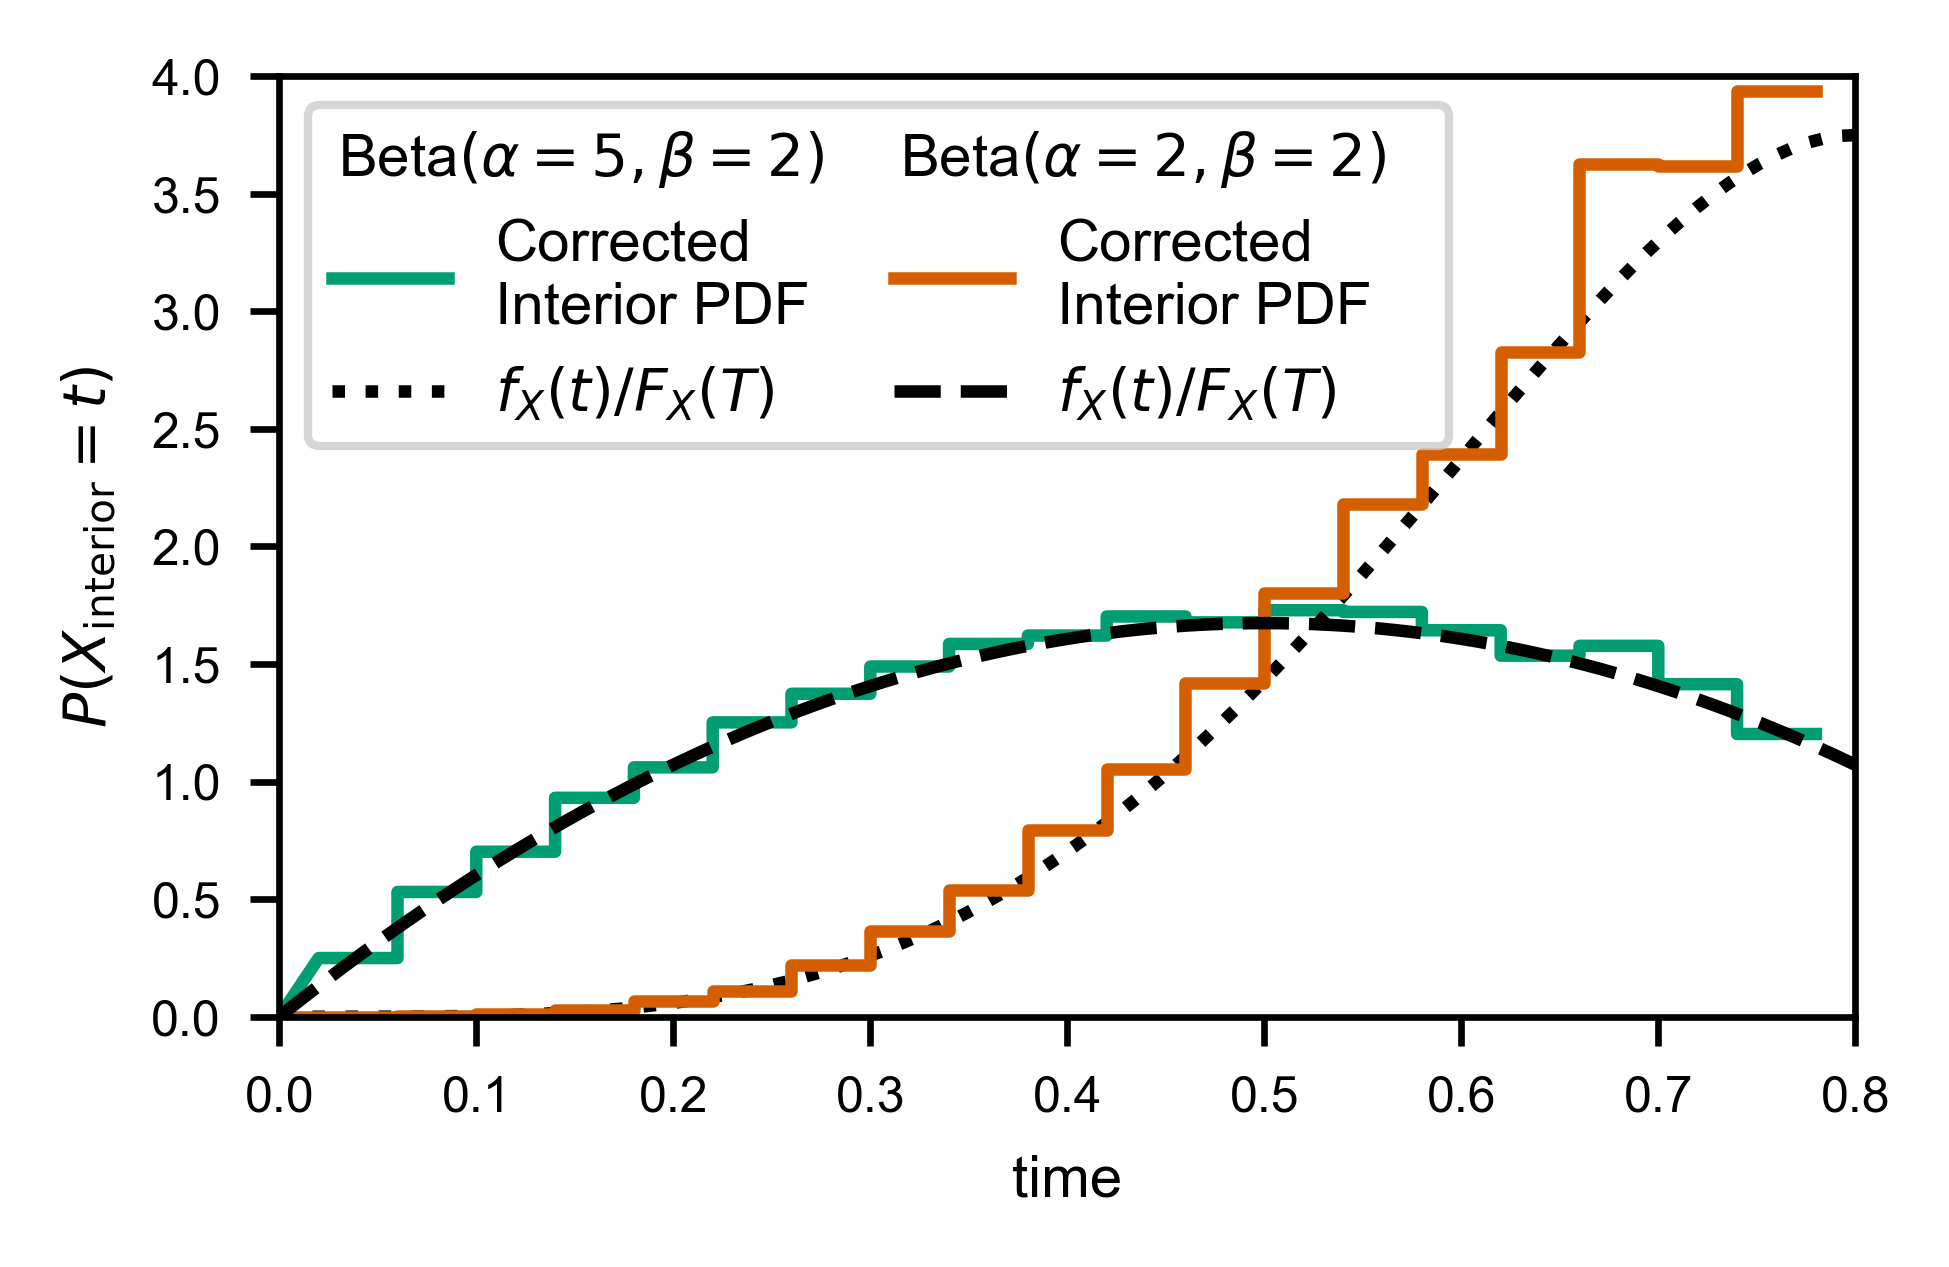

In [833]:
fig, ax = plt.subplots(
    figsize=figure_size['full column'],
    constrained_layout=True
)

legend_entries = {var.name: [mpl.patches.Patch(alpha=0, label=var.pretty_name)] 
                  for var in wait_vars}
T = discrete_waits.window_size.max()
for var in wait_vars:
    interior = discrete_waits.loc[
        (discrete_waits['state'] == var.name) & (discrete_waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ]

    # don't need to bin to create histogram, since we measure only a discrete set of times
    x, cdf = fw.ecdf_windowed(
        interior.wait_time.values, 
        interior.window_size.values,
        times_allowed=movie_frame_t
    )
    # deals with empty final bin, shifting bins over by half a dt, prepending the zero, etc.
    X, Y = fw.bars_given_discrete_cdf(x, cdf)
    line, = ax.plot(X, Y, c=var.color, label='Corrected\nInterior PDF')
    legend_entries[var.name].append(line)

    t = np.linspace(0, T, 100)
    line, = ax.plot(t, var.pdf(t)/var.cdf(T), 
                    c='k', ls=var.ls, label=f'$f_X(t)/F_X(T)$')
    legend_entries[var.name].append(line)

ax.set_xlabel('time')
ax.set_ylabel(r'$P(X_\mathrm{interior} = t)$')
ax.set_xlim([0, T])
ax.set_ylim([0, 4])
handles = [h for _, patches in legend_entries.items() for h in patches]
legend = ax.legend(handles=handles, ncol=2, columnspacing=0.5)

# hack to left-align my "fake" legend column "titles"
for vpack in legend._legend_handle_box.get_children():
    for hpack in vpack.get_children()[:1]:
        hpack.get_children()[0].set_width(0)
# even after the hack, need to move them over to "look" nice
legend.get_texts()[0].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))
legend.get_texts()[3].set_position((-40/600*mpl.rcParams['figure.dpi'], 0))

## Theoretical Details


The following section contains a complete derivation of the framework used to
generate the corrections used in this module.

### Motivating (A)synchronicity

We first motivate our definition of "(a)synchronicity", the critical property
that allows us to correct for the effects of observing in a finite window.

Suppose a process starts at :math:`-t_\text{inf}` (WLOG, assume it starts in
state :math:`A`). For times after :math:`-t_\text{inf} \lll 0`, the process switches
between states :math:`A` and :math:`B`. The distribution of times spent in each
state before switching are IID, and distributed like :math:`f_A(t)` and
:math:`f_B(t)`, respectively. We then are able to observe the process during the
interval of time :math:`[0, T]`.

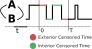

In [86]:
from IPython.core.display import SVG
SVG(filename='./images/waiting-time-base-diagram.svg')

This can be thought of as a renewal(-reward) process that started far in the
past. As long as the starting point, :math:`-t_\text{inf}`, is sufficiently far
in the past, and the distributions :math:`f_*(t)` have finite variance, various
convenient properties hold true for the observed state switching times between
:math:`0` and :math:`T`. We use the same example as in the "tutorial" section in
what follows.

In [ ]:
import scipy.stats
from multi_locus_analysis import finite_window as fw
e44 = scipy.stats.expon(scale=4, loc=4)
e16 = scipy.stats.expon(scale=6, loc=1)
trajs = fw.ab_window([e44.rvs, e16.rvs], window_size=20, offset=-1000,
    num_replicates=10000, states=['exp(4,4)', 'exp(1,6)'])

The first convenient property is that the switching times are uniformly
distributed within the observation interval (as
:math:`-t_\text{inf}\to-\infty`). Intuitively, this just means that
:math:`-t_\text{inf}` is far enough in the past that, independently of the
distribution, we are not biased towards the switching times being early or late
in our observation interval (i.e. we have lost all memory of the "real" start
time).

In [ ]:
plt.figure(figsize=[4,3])
plt.hist(trajs['start_time'].values, 100)
plt.xlim([0, 20])
plt.xlabel('Rate of "creation of left ends"')

Now let's label the observed state switches as :math:`t_0,\ldots{},t_{n-1}`,
with :math:`t_0` and :math:`t_n` corresponding to the "actual" (unobserved)
state switch times flanking the observation interval.
The next useful property is that the start of the observation interval
(:math:`t=0`) is uniformly distributed within :math:`[t_0, t_1]` (similarly, the
end of the observation interval, :math:`t=T`, is uniformly distributed in
:math:`[t_{n-1}, t_n]`.

In [ ]:
plt.figure(figsize=[4,3])
t01 = trajs[trajs['start_time'] < 0]
u = -t01['start_time']/(t01['end_time'] - t01['start_time'])
plt.hist(u, 100)
plt.xlabel('Fraction of way between state changes at $t=0$.')

For the interior times, we can simply use the first fact to derive our interior
time correction. Since we know the starting times of each state are uniformly
distributed, we immediately can tell that if a waiting time of length
$\tau$ has a start time within the interval, then the the fraction of
times that this waiting time will end up being an interior time is just
$(T - \tau)/T$. More precisely, we have that

$$
    P(t_{i+1} \leq T | t_{i+1}-t_i=\tau, t_i \in [0,T]) = \int_0^T 1_{t_i + \tau
    \leq T} f_{\text{Unif}[0,T]}(t_i) dt_i
$$

which is just equal to :math:`(T - \tau)/T`.

This correction factor can be visualized easily as simply counting what fraction
of "start" times of a given length lead to "end" times still inside the
interval. Namely, it's the green part of the interval in the following diagram:

.. image:: images/waiting-time-censored-fraction.svg

    :width: 400
    
    :alt: pictoral demonstration of equation above

On the other hand, we have to be careful about the distribution of exterior
times, even if we do somehow magically have the values
of :math:`t_0` and the state at :math:`t=0`. You can't simply assume that
:math:`t_1 - t_0` is distributed like :math:`f_A(t)` or :math:`f_B(t)`. After
all, in fact it is distributed like :math:`tf_*(t)`. This is because (loosely
speaking) if you fill the real line with a bunch of intervals whose lengths are
distributed like :math:`f(t)`, then you choose a point on the real line at
random, you are more likely to land in an interval of size :math:`t` the longer
that :math:`t` is.

In [ ]:
plt.figure(figsize=[4,3])
a1 = t01[t01['state'] == 'exp(4,4)']
x, cdf = fw.ecdf(a1['end_time'] - a1['start_time'])
kernel = fw.smooth_pdf(x, cdf)
plt.plot(x, kernel(x), label=r'$\hat{f}(t)$: Observed CDF of $t_1 - t_0$')
plt.plot(x, e44.pdf(x), label=r'$f(t)$: Actual CDF of exp(4,4)')
Z = scipy.integrate.quad(lambda x: x*e44.pdf(x), 0, np.inf)
plt.plot(x, x*e44.pdf(x)/Z[0], label=r'$t f(t)/\int_0^\infty t f(t) dt$')
plt.legend()

### (A)synchronicity

While the explicit framework presented above is a useful tool, it is ill-defined
for heavy-tailed processes, in which we are primarily concerned when making
these types of corrections. In order to retain the useful properties of the
system that made it possible to derive the interior and exterior times
distributions, we simply notice that the *real* property that we want to be true
when measuring these systems is *asynchronicity*, or what a physicist might call
"symmetry under time translations" or "time homogeneity". In short, we want to
impose the constraint that we are only interested in scientific measurements
where changing the interval of observation :math:`[0, T]` to
:math:`[0+\tau,T+\tau]` for any :math:`\tau` will not change any properties of
the measurement.

<div class="alert alert-info">

    We leave as an exercise to the reader to show that:

    1. the renewal process of the previous section is a special case of an asynchronous process
    2. this definition of asynchronicity produces all three properties we demonstrated for our renewal process above
   
</div>

On the other extreme from asynchronicity is the situation in which the
Meier-Kaplan correction was originally designed to be used. Namely, we could
imagine that a perfectly *synchronous* process is one where :math:`t_0` is fixed
to be at time :math:`t=0`, meaning that :math:`t_1 - t_0` is distributed as just
:math:`f_*(t)`.

While in principle anything between asynchrony and synchrony is possible, it is
true in general that almost all scientific measurements area already done using
either purely synchronous or asynchronous systems, since it is intuitively clear
that a lack of understanding of the synchronicity of one's system can lead to
uninterpretable results.

### Laplace Formalism


TODO: fill in alternative formulation of system here.

### Checking miscellaneous math

After running the Tutorial above, the following shows how to compute several important intermediate quantities:

compute $E[X|t \leq T]$, turns out either way is similar accuracy here

In [347]:
for var in wait_vars:
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ]
    interior['correction'] = (interior.window_size - interior.wait_time)/interior.window_size
    # check which is more accurate
    t_bins = np.linspace(0, example_window, 51)
    t_midp = (t_bins[1:] + t_bins[:-1]) / 2
    dt = np.diff(t_bins)
    t_y_int, t_bins = np.histogram(
        interior.wait_time.values, 
        weights=1/interior.correction.values,
        density=True, 
        bins=t_bins
    )
    x, cdf = fw.ecdf_windowed(
        interior.wait_time.values,
        interior.window_size.values,
        pad_left_at_x=0
    )
    T = example_window
    print('E[X|t<=T] for X=' + var.name)
    cdf_mid = (cdf[1:] + cdf[:-1]) / 2
    print(np.sum(
        (1 - cdf_mid) * np.diff(x)
    ))
    print((
        scipy.integrate.quad(lambda t: 1 - var.cdf(t)/var.cdf(T), 0, T)[0]
    ))
    print(np.sum(
        t_midp * t_y_int * dt
    ))
    print((
        scipy.integrate.quad(lambda t: t * var.pdf(t) / var.cdf(T), 0, T)[0]
    ))

E[X|t<=T] for X=Beta(2, 2)
0.6264861452210034
0.6285714285714287
0.6265324248162835
0.6285714285714287
E[X|t<=T] for X=Beta(5, 2)
0.4615429611630457
0.45714285714285713
0.4615142086902802
0.45714285714285713


compute $F(T)$

In [429]:
for var in wait_vars:
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ].copy()
    interior['correction'] = 1 / (interior.window_size - interior.wait_time)
    exterior = waits.loc[
        (waits['state'] == var.name) 
        & (waits['wait_type'] != 'interior') 
        & (waits['wait_type'] != 'full exterior'),
        # using both seems better, actually, N=1
#         & (waits['wait_type'] != 'right exterior'),  
        ['wait_time', 'window_size']
    ]
    
    t_bins = np.linspace(0, interior.window_size.max(), 51)
    t_midp = (t_bins[1:] + t_bins[:-1]) / 2
    dt = np.diff(t_bins)
    
    t_y_int, t_bins = np.histogram(
        interior.wait_time,
        weights=interior['correction'] / np.sum(interior['correction']),
        bins=t_bins,
    )
    t_y_int = t_y_int / dt
    E_t_int = np.sum(t_midp * t_y_int * dt)
    x_int, cdf_int = fw.ecdf_windowed(
        interior.wait_time, interior.window_size, pad_left_at_x=0
    )
    cdf_int_mid = (cdf_int[1:] + cdf_int[:-1]) / 2
    dx_int = np.diff(x_int)
    E_t_int_alt = np.sum((1 - cdf_int_mid) * dx_int)
    
    t_y_ext, t_bins = np.histogram(
        exterior.wait_time.values, 
        density=True, 
        bins=t_bins
    )
    # should probably use some kind of averaging like for S_0
    S_T = t_y_ext[-1]
    #TODO: #WARN: in general this mean won't work, need to do line fit...
    S_0 = np.mean(t_y_ext[0:6])
    T = example_window
    print('Estimating F_X(T)')
    print(f'For {var.name} the following four should be identical:')
    print('Using S_0:')
    print(
        (T - 1/S_0) / (T - E_t_int)
    )
    print(
        (T * S_T - 1) / (T*S_T - S_T*E_t_int - 1)
    )
    print('Using S_T:')
    print(
        (1 - T*S_T) / (1 - S_T*np.sum(cdf_int_mid*dx_int))
    )
    print('Averaging two versions together:')
    print((
        (T - 1/S_0) / (T - E_t_int) + (T * S_T - 1) / (T*S_T - S_T*E_t_int - 1)
    )/2)
    print('Actual answer:')
    Z_X = T - scipy.integrate.quad(var.cdf, 0, T)[0]
    E_t_actual = scipy.integrate.quad(
        lambda t: t * var.pdf(t)/var.cdf(T),
        0, T
    )[0]
    S_hat_T = var.sf(T) / Z_X
    print(
        (T*S_hat_T - 1) / (T*S_hat_T - E_t_actual*S_hat_T - 1)
    )
    print(var.cdf(T))
#     print('Because the following ways to calculate Z_X are equivalent:')
#     print(
#         T - scipy.integrate.quad(lambda t: (T - t)*var.pdf(t), 0, T)[0]
#     )
#     print(
#         Z_X
#     )
#     print(scipy.integrate.quad(
#         lambda t:
#         (T*var.pdf(t)/var.cdf(T) - var.cdf(T)*(T - t)*var.pdf(t)/var.cdf(T)),
#         0, T
#     )[0])
#     print('Leading to the following equality:')
#     print(
#         var.sf(T) / Z_X
#     )
#     print(t_y_ext[-1])
    print('COMPONENTS:')
    print('E_X|t<=T')
    print(f'Actual: {E_t_actual}')
    print(f'Integrate interior histogram: {E_t_int}')
    print(f'Integrate interior CDF: {E_t_int_alt}')
    print(f'Integrate exterior histogram (real CDF): '
          f'{np.sum(t_y_ext / np.mean(t_y_ext[:6]) * dt)}')
#     print('\hat{S}(T)')
#     print(S_hat_T)
#     print(S_T)
    


For Beta(2, 2) the following four should be identical:
Using S_0:
0.6764764161308825
0.6287417605594645
Using S_T:
0.6279548491654091
Averaging two versions together:
0.6526090883451735
Actual answer:
0.6553600000000002
0.6553600000000002
COMPONENTS:
E_X|t<=T
Actual: 0.6285714285714287
Integrate interior histogram: 0.6265324248162839
Integrate interior CDF: 0.6264861452210034
Integrate exterior histogram (real CDF): 0.6826532764248053
For Beta(5, 2) the following four should be identical:
Using S_0:
0.8941160803653451
0.8828405783169307
Using S_T:
0.882678018503018
Averaging two versions together:
0.8884783293411379
Actual answer:
0.896
0.896
COMPONENTS:
E_X|t<=T
Actual: 0.45714285714285713
Integrate interior histogram: 0.46151420869027704
Integrate interior CDF: 0.4615429611630457
Integrate exterior histogram (real CDF): 0.49735441101478833


Show equivalence of a critical integration-by-parts step:

In [225]:
for var in wait_vars:
    print(scipy.integrate.quad(var.cdf, 0, example_window)[0]/example_window)
    print(scipy.integrate.quad(lambda t: (example_window - t)/example_window * var.pdf(t),
                               0, example_window)[0])
    print(scipy.integrate.quad(lambda t: (example_window - t)/example_window * var.pdf(t) / var.cdf(example_window),
                               0, example_window)[0])
    interior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] == 'interior'),
        ['wait_time', 'window_size']
    ]
    interior['correction'] = (interior.window_size - interior.wait_time)/interior.window_size
    t_bins = np.linspace(0, example_window, 51)
    t_y, t_bins = np.histogram(
        interior.wait_time.values, 
        weights=1/interior.correction.values,
        density=True, 
        bins=t_bins
    )
    t_midp = (t[1::2] + t[::2]) / 2
    dt = np.diff(t_bins)
    
    cor_bins = np.linspace(0, 1, 51)
    t_cor, cor_bins = np.histogram(
        (interior.window_size - interior.wait_time) / interior.window_size,
        bins=cor_bins,
        density=True
    )
    print(np.sum(
        (example_window - t_midp) / example_window * t_y * dt
    ))


0.14043428571428573
0.14043428571428573
0.2142857142857143
0.21397421109055167
0.3840000000000002
0.38399999999999995
0.4285714285714285
0.42233054458298075


## Scratch Ideas

Maybe it's possible to use many different binnings together, to better estimate $\hat{S}(0)$ and $\hat{S}(T)$?

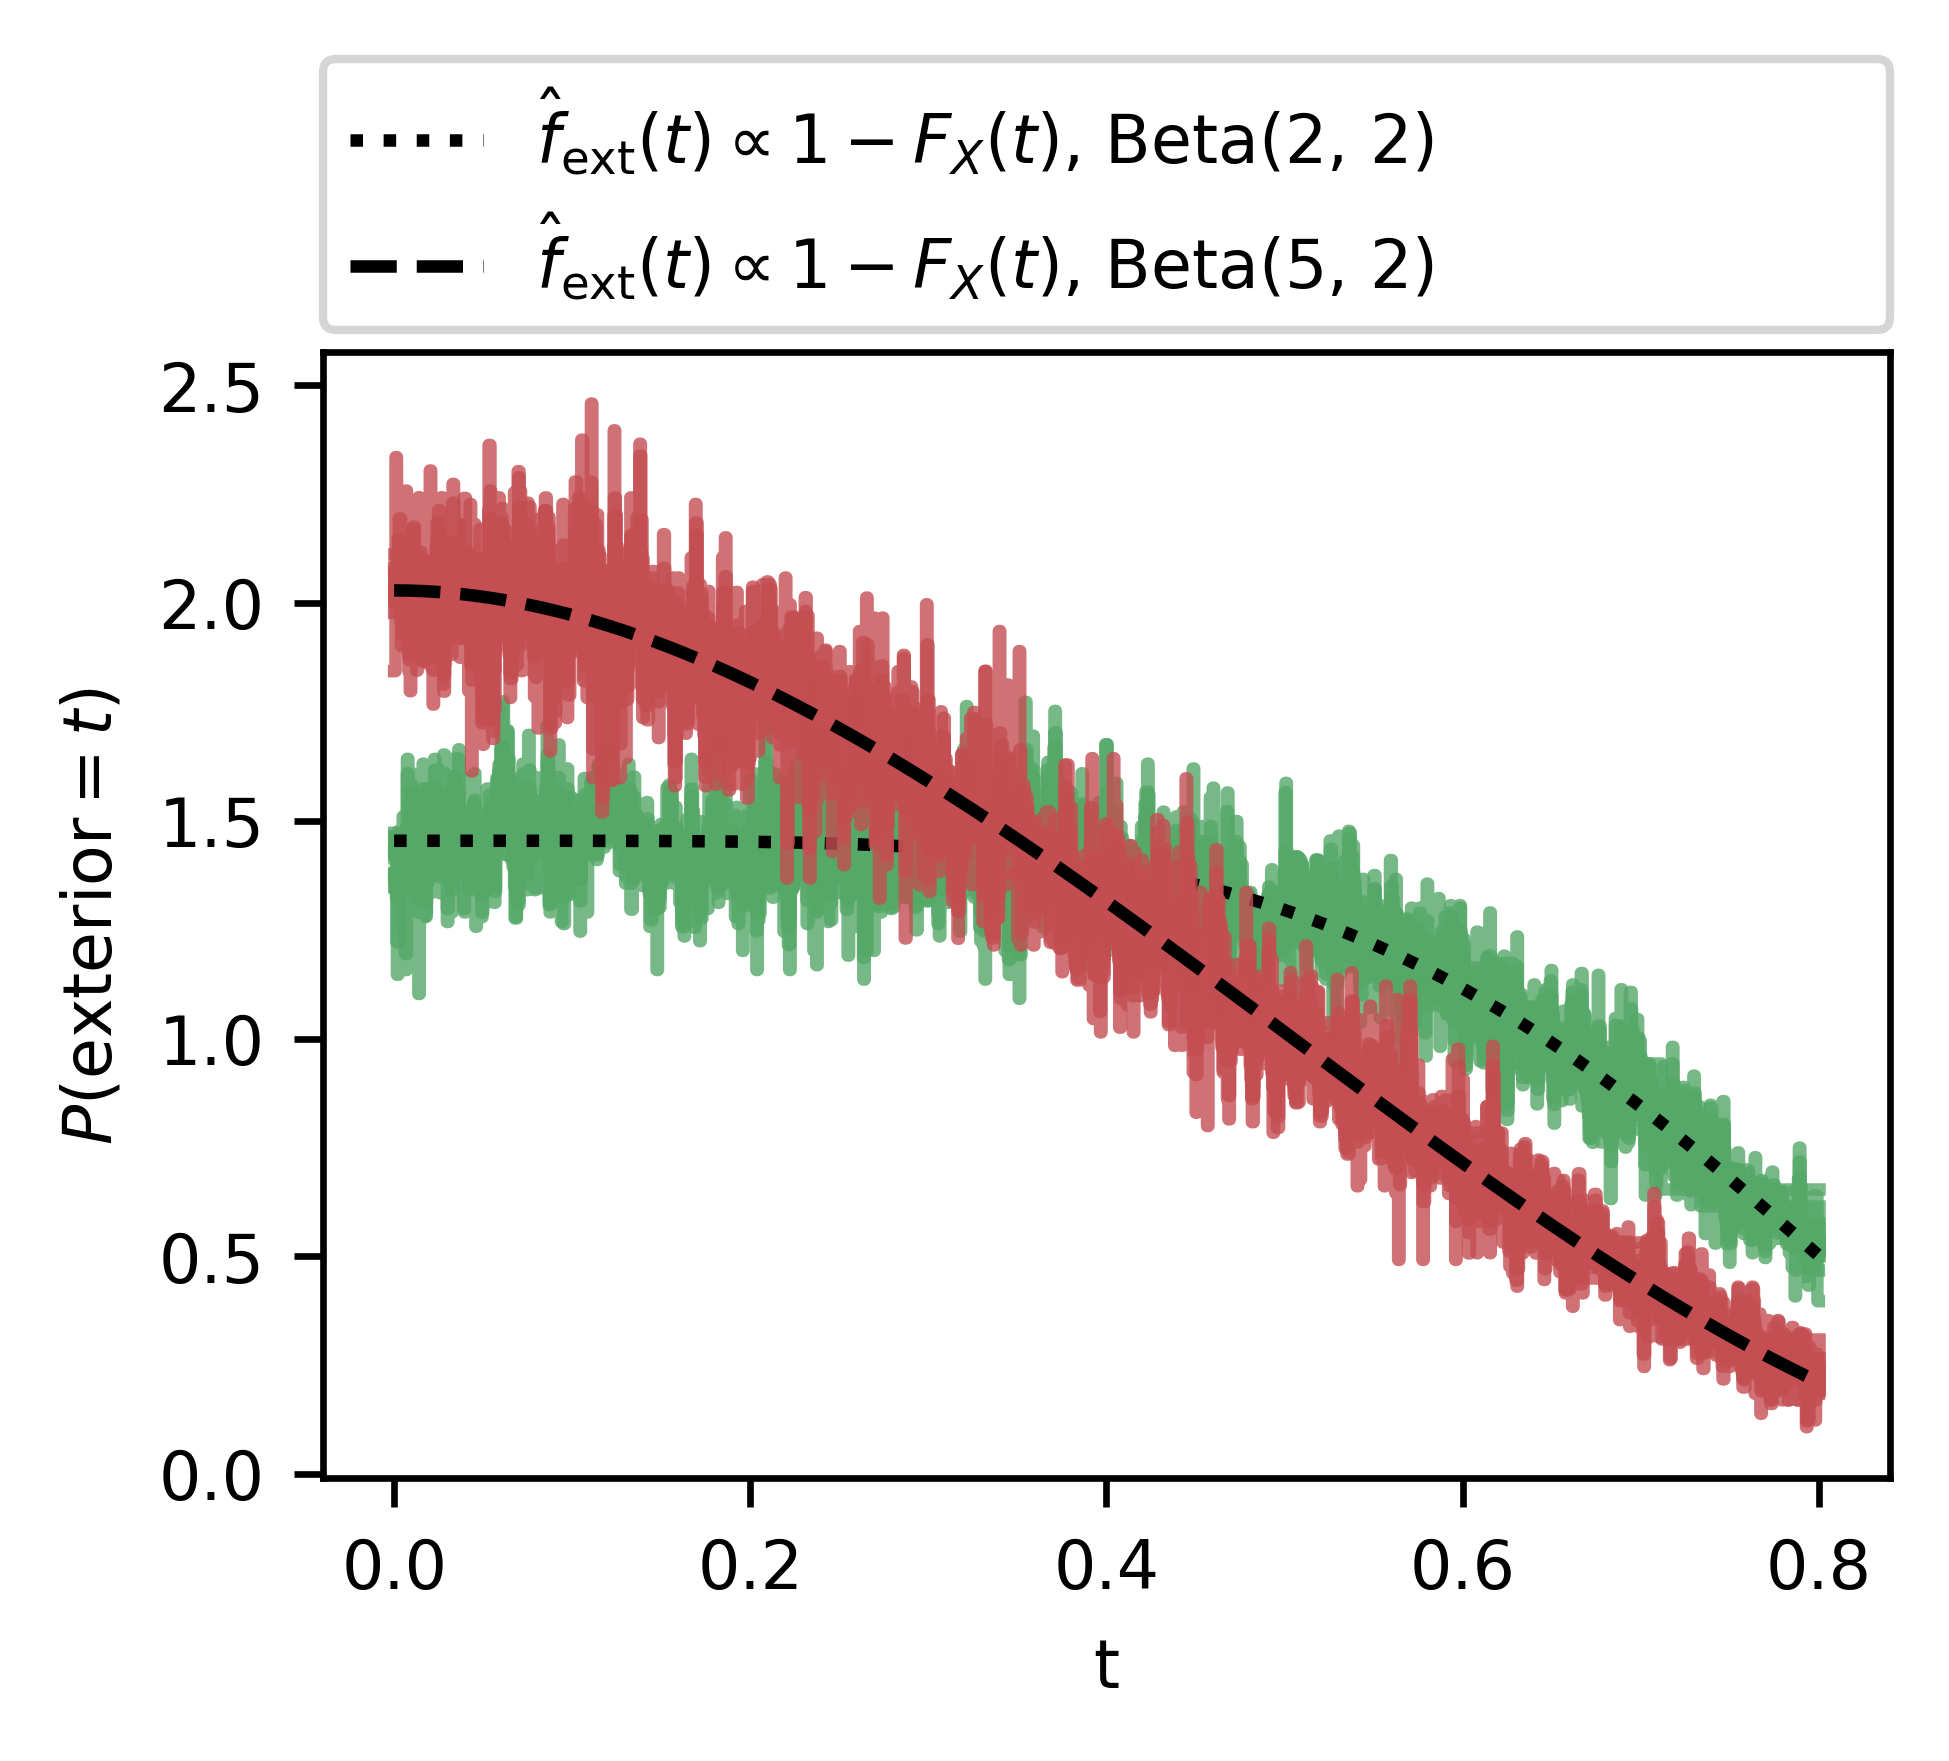

In [391]:
default_figsize = mpl.rcParams['figure.figsize']
fig, ax = plt.subplots(
    figsize=(default_figsize[0], 0.9*default_figsize[0]),
    constrained_layout=True
)

for var in wait_vars:
    exterior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] != 'interior') \
        & (waits['wait_type'] != 'full exterior'),
        ['wait_time', 'window_size']
    ]
    ys = []
    bin_values = np.round(np.logspace(1, 3, 20)).astype(int)
    for n_bins in bin_values:
        t_bins = np.linspace(0, np.max(interior.window_size), n_bins)
        dt = np.diff(t_bins)
        y, t_bins = np.histogram(
            exterior.wait_time.values, 
            bins=t_bins,
        )
        y = y/dt/len(exterior)
        ys.append(y[0])
        X, Y = fw.bars_given_hist(y, t_bins)
        ax.plot(X, Y, c=var.color, alpha=0.8), #ls=var.ls,
#                 label=f'eCDF, exterior times, {var.name}')
#         ax.plot(X, Y/Y[0], c=var.color, alpha=0.5), #ls=var.ls,
#     #             label=f'Corrected interior times, {var.name}')
    
    t = np.linspace(0, example_window, 100)
#     plt.plot(t, var.sf(t), c='k', ls=var.ls, alpha=0.5)#, label=f'Ground truth, {var.name}')
    T = example_window
    scale = T - scipy.integrate.quad(var.cdf, 0, T)[0]
    ax.plot(t, var.sf(t)/scale, c='k', ls=var.ls, 
             label=f'$\hat{{f}}_\mathrm{{ext}}(t) \propto 1 - F_X(t)$, {var.name}')

    ax.set_xlabel('t')
    ax.set_ylabel(r'$P(\mathrm{exterior} = t)$')
    
    # align bottom of legend 2% ax height above axis, filling full axis width
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
              ncol=1, mode="expand", borderaxespad=0.)   

so above it looks like increasing the binning is kinda like generating correlated gaussian noise processes about the true distribution...

not clear that we can actually get anything from this...

below you see that by just looking at the height of the left-most and right-most bins, you see just how hard it is to get a reasonable estimate of $\hat{S}(0)$, but $\hat{S}(T)$ seems like you could fit a line and get a reasonable estimate. Maybe worth comparing to our current method at some point....

Text(0, 0.5, 'Estimate of $\\hat{S}(T)$')

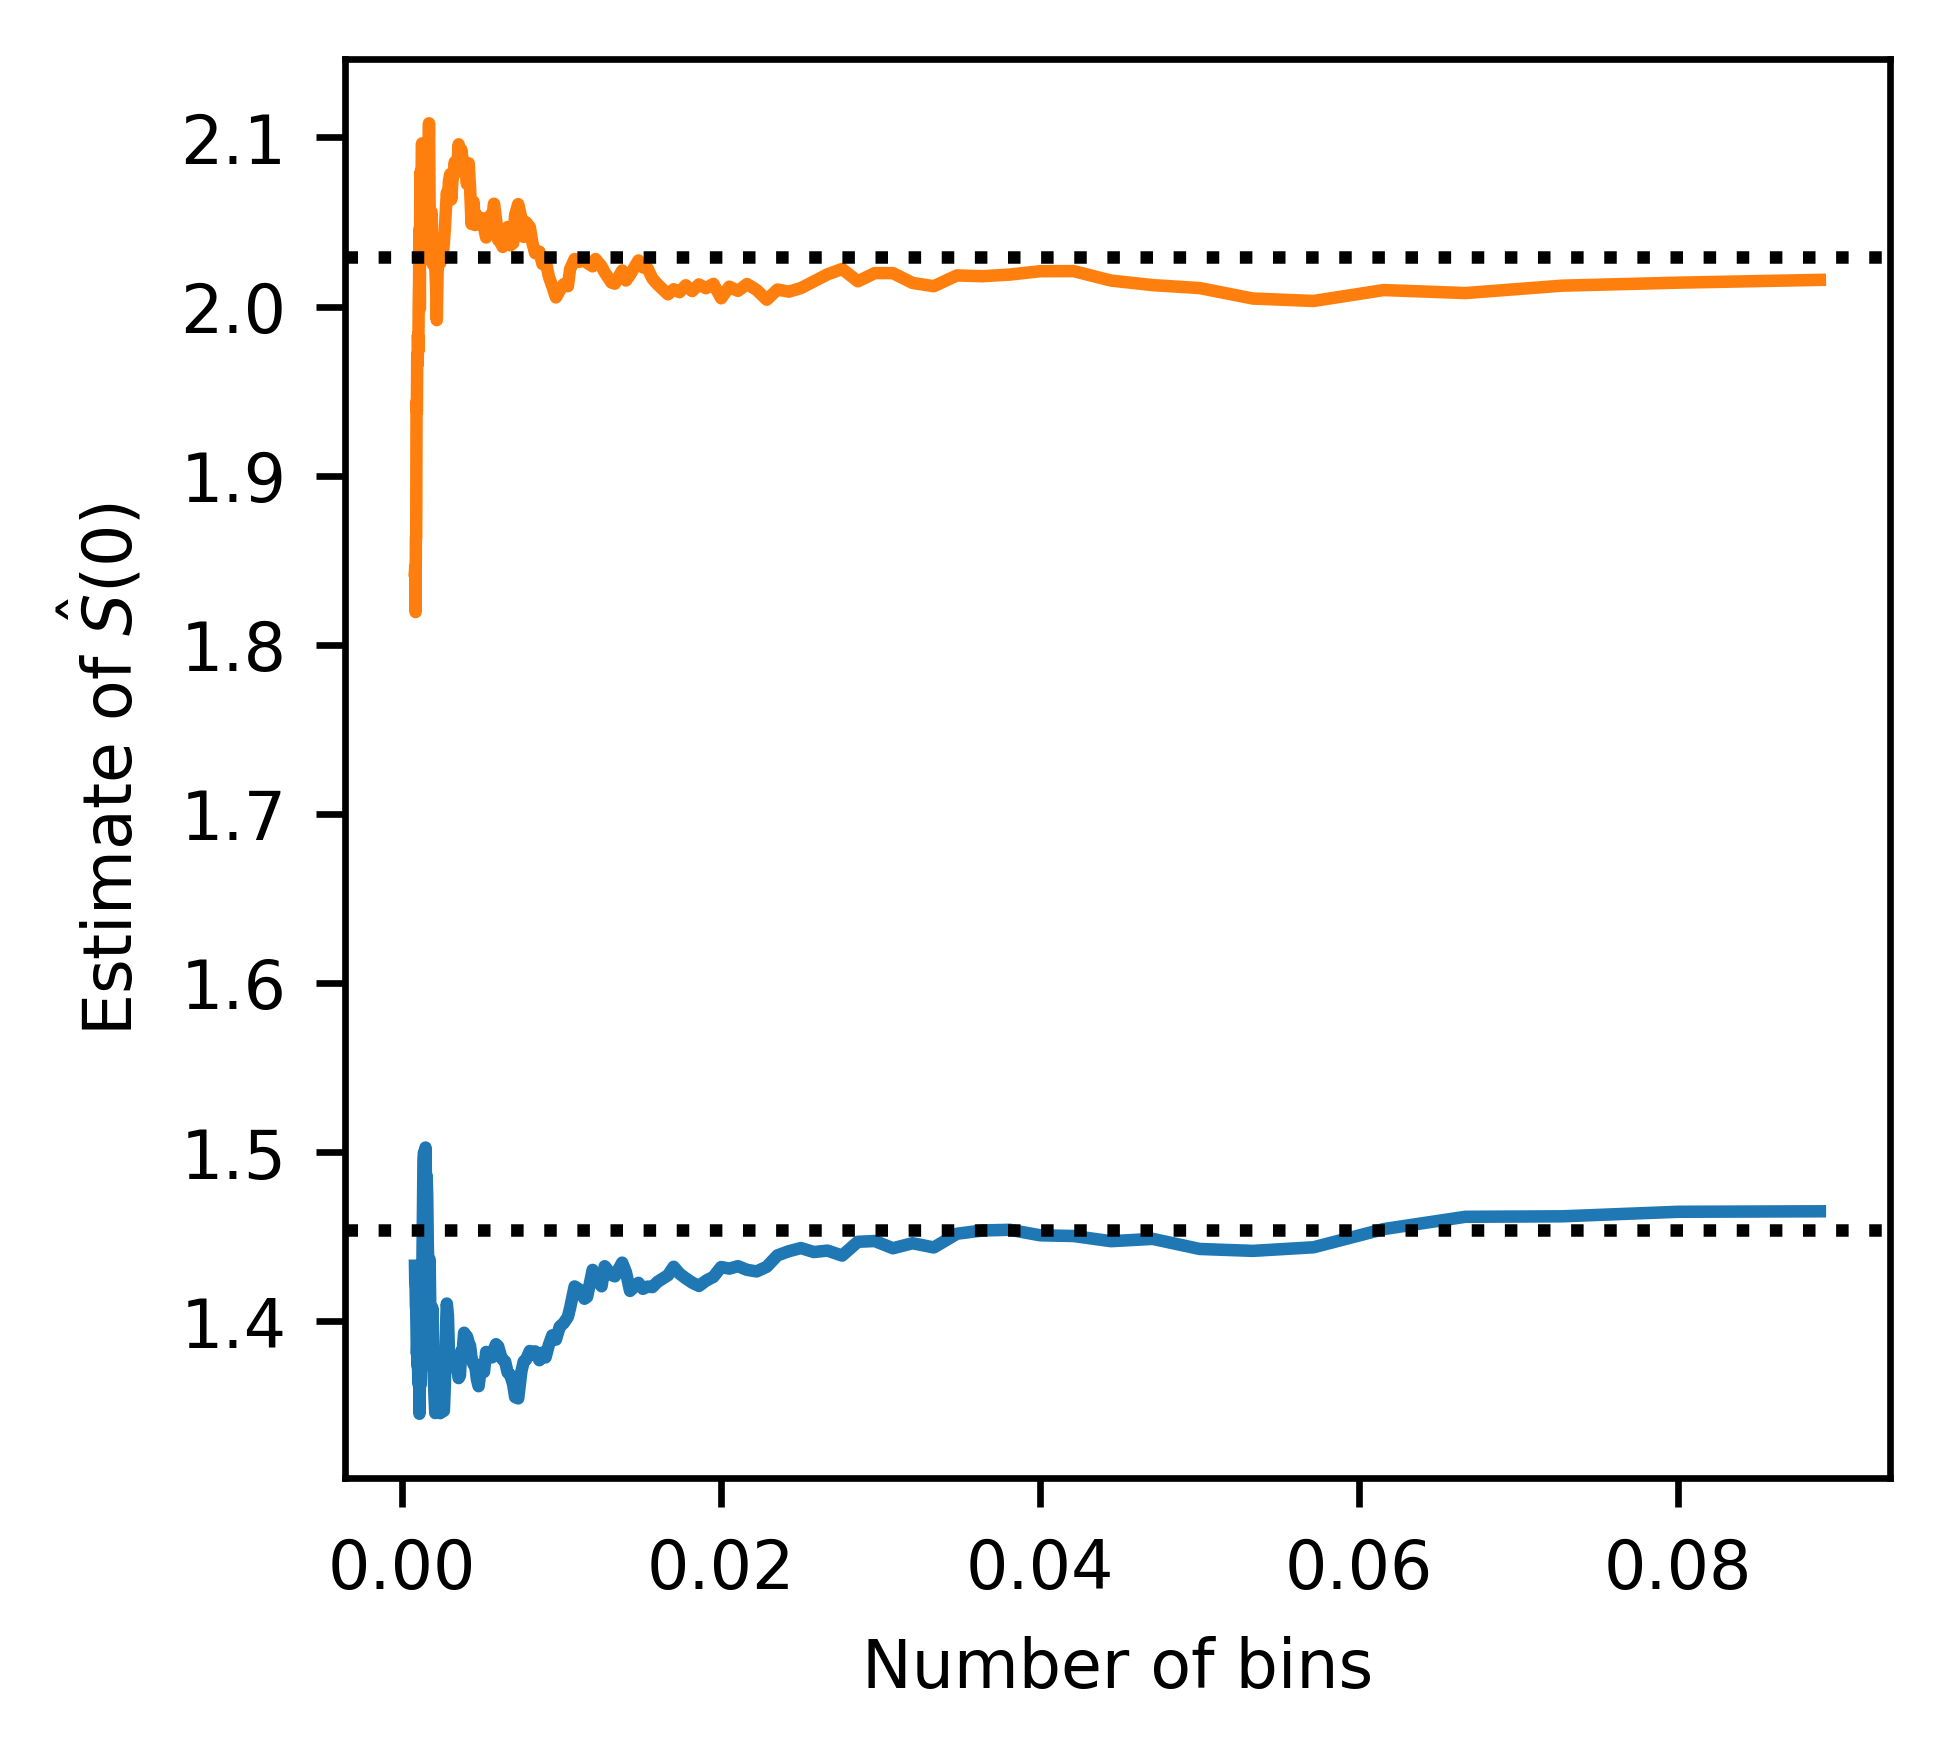

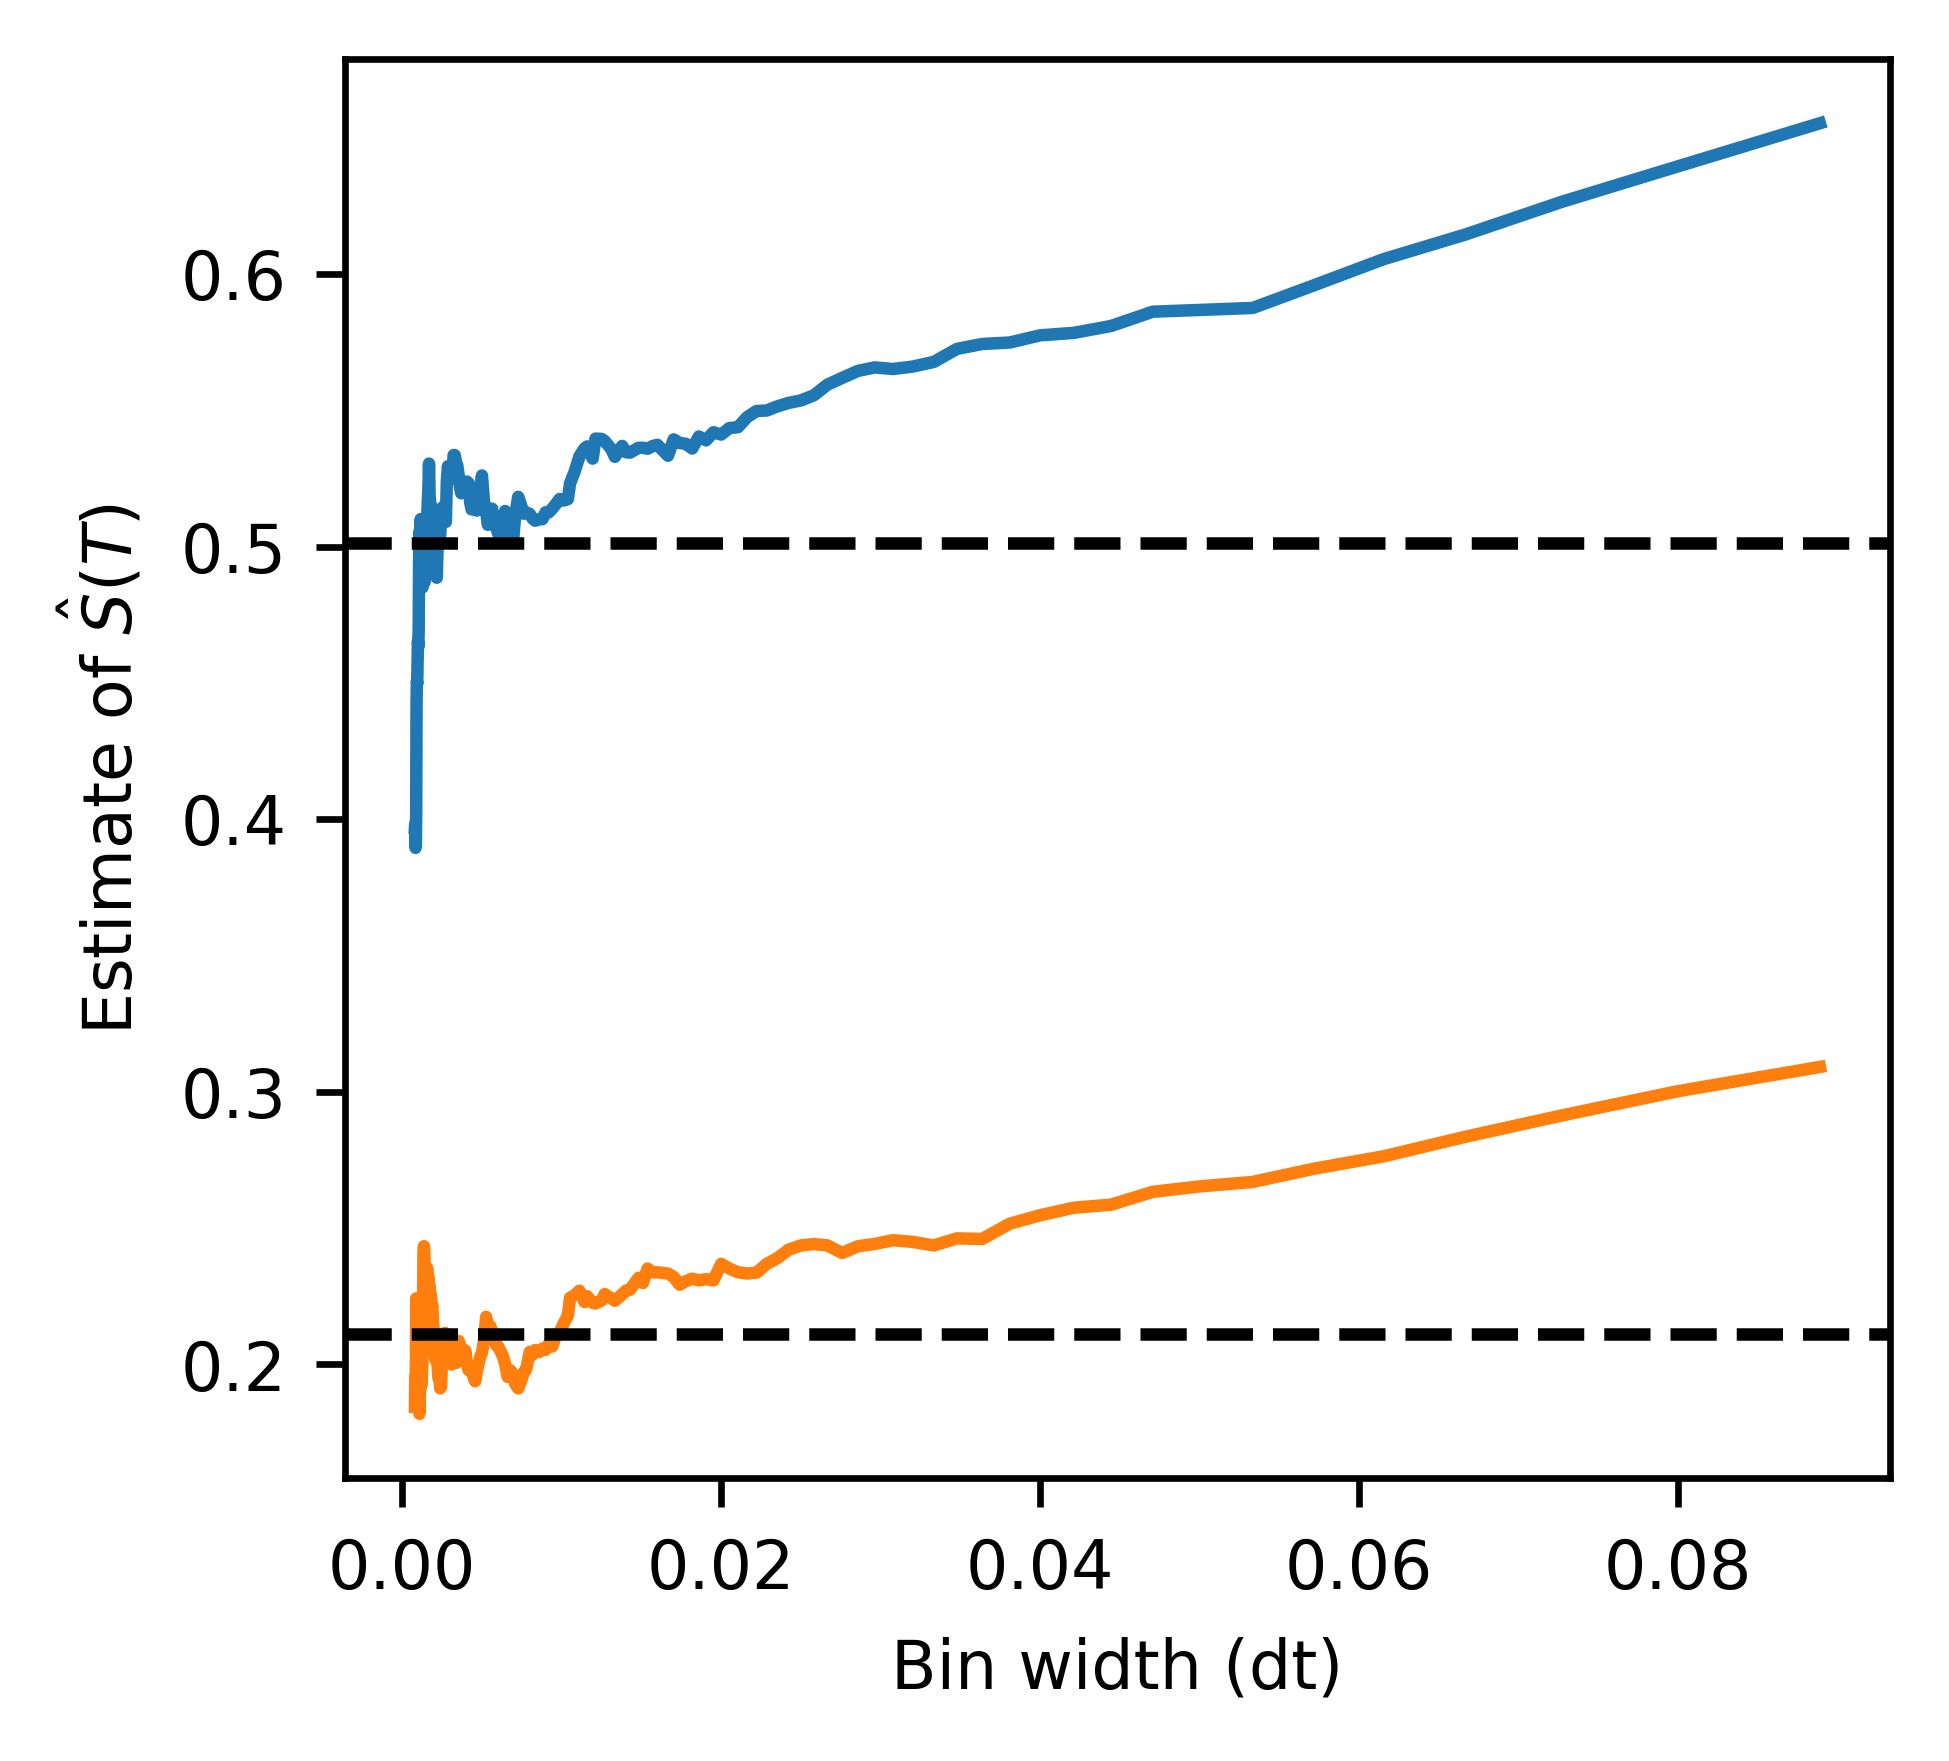

In [434]:
default_figsize = mpl.rcParams['figure.figsize']
fig, ax0 = plt.subplots(
    figsize=(default_figsize[0], 0.9*default_figsize[0]),
    constrained_layout=True
)
fig, axT = plt.subplots(
    figsize=(default_figsize[0], 0.9*default_figsize[0]),
    constrained_layout=True
)

for var in wait_vars:
    exterior = waits.loc[
        (waits['state'] == var.name) & (waits['wait_type'] != 'interior') \
        & (waits['wait_type'] != 'full exterior'),
        ['wait_time', 'window_size']
    ]
    S_0s = []
    S_Ts = []
    bin_values = np.round(np.logspace(1, 3, 200)).astype(int)
    dts = exterior.window_size.max() / (bin_values - 1)
    
    for n_bins in bin_values:
        t_bins = np.linspace(0, np.max(exterior.window_size), n_bins)
        dt = np.diff(t_bins)
        y, _ = np.histogram(
            exterior.wait_time.values, 
            bins=t_bins[:3],  # use two bins so we have half-open first bin
        )
        y = y/dt[:2]/len(exterior)
        S_0s.append(y[0])
        
        y, _ = np.histogram(
            exterior.wait_time.values, 
            bins=t_bins[-2:],  # right-most bin always closed anyways
        )
        y = y / dt[-1] / len(exterior)
        S_Ts.append(y[0])
        
    ax0.plot(dts, S_0s)
    axT.plot(dts, S_Ts)

    Z_X = T - scipy.integrate.quad(var.cdf, 0, T)[0]
    E_t_actual = scipy.integrate.quad(
        lambda t: t * var.pdf(t)/var.cdf(T),
        0, T
    )[0]
    S_hat_T = var.sf(T) / Z_X
    ax0.axhline(1/Z_X, 0, 1, c='k', ls=':')
    axT.axhline(S_hat_T, 0, 1, c='k', ls='--')

ax0.set_xlabel('Bin width (dt)')
ax0.set_ylabel('Estimate of $\hat{S}(0)$')

axT.set_xlabel('Bin width (dt)')
axT.set_ylabel('Estimate of $\hat{S}(T)$')